In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = True
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 100000
lstm_hidden_size = 128
epochs = 20
experiment_id = (
    "classification-max_training_samples-100000-lstm_hidden_size-128-epochs-20"
)


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import load_dataset, load_gen_dataset
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
def get_train_valid():
    train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

    if not enable_orig:
        train_x = []
        train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
    
    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

528245
528245
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x[:max_training_samples]))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


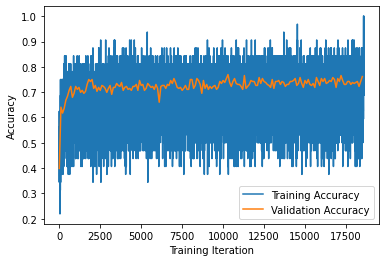

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-samples-{max_training_samples}-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x[:max_training_samples]),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    print(train_x_embeds.shape)
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=256
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.180 Validation Loss: 2.171 Accuracy: 0.195 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.173 Validation Loss: 2.171 Accuracy: 0.238 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.168 Validation Loss: 2.171 Accuracy: 0.245 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.165 Validation Loss: 2.171 Accuracy: 0.242 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.164 Validation Loss: 2.171 Accuracy: 0.236 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.161 Validation Loss: 2.171 Accuracy: 0.247 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.161 Validation Loss: 2.171 Accuracy: 0.240 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.163 Validation Loss: 2.171 Accuracy: 0.229 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.163 Validation Loss: 2.171 Accuracy: 0.231 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.162 Validation Loss: 2.171 Accuracy: 0.233 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.159 Validation Loss: 2.171 Accuracy: 0.241 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.159 Validation Loss: 2.171 Accuracy: 0.231 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.157 Validation Loss: 2.171 Accuracy: 0.234 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.157 Validation Loss: 2.171 Accuracy: 0.230 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.154 Validation Loss: 2.171 Accuracy: 0.239 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.153 Validation Loss: 2.171 Accuracy: 0.232 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.153 Validation Loss: 2.171 Accuracy: 0.234 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.151 Validation Loss: 2.171 Accuracy: 0.247 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.150 Validation Loss: 2.171 Accuracy: 0.249 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.149 Validation Loss: 2.171 Accuracy: 0.250 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.147 Validation Loss: 2.171 Accuracy: 0.254 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 21 Loss: 2.146 Validation Loss: 2.171 Accuracy: 0.255 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 22 Loss: 2.146 Validation Loss: 2.171 Accuracy: 0.245 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 23 Loss: 2.144 Validation Loss: 2.171 Accuracy: 0.255 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 24 Loss: 2.143 Validation Loss: 2.171 Accuracy: 0.252 Validation Accuracy: 0.211:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Iteration: 24 Loss: 2.143 Validation Loss: 2.171 Accuracy: 0.252 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 25 Loss: 2.143 Validation Loss: 2.171 Accuracy: 0.252 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 26 Loss: 2.142 Validation Loss: 2.171 Accuracy: 0.250 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 27 Loss: 2.141 Validation Loss: 2.171 Accuracy: 0.243 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 28 Loss: 2.140 Validation Loss: 2.171 Accuracy: 0.242 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 29 Loss: 2.139 Validation Loss: 2.171 Accuracy: 0.242 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 30 Loss: 2.138 Validation Loss: 2.171 Accuracy: 0.236 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 31 Loss: 2.137 Validation Loss: 2.171 Accuracy: 0.242 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 32 Loss: 2.136 Validation Loss: 2.171 Accuracy: 0.248 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 33 Loss: 2.134 Validation Loss: 2.171 Accuracy: 0.246 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 34 Loss: 2.134 Validation Loss: 2.171 Accuracy: 0.241 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 35 Loss: 2.133 Validation Loss: 2.171 Accuracy: 0.241 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 36 Loss: 2.131 Validation Loss: 2.171 Accuracy: 0.247 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 37 Loss: 2.130 Validation Loss: 2.171 Accuracy: 0.254 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 38 Loss: 2.129 Validation Loss: 2.171 Accuracy: 0.256 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 39 Loss: 2.128 Validation Loss: 2.171 Accuracy: 0.254 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

(100000, 10, 769)


Epoch: 0 Iteration: 40 Loss: 2.127 Validation Loss: 2.171 Accuracy: 0.254 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 41 Loss: 2.127 Validation Loss: 2.171 Accuracy: 0.255 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 42 Loss: 2.125 Validation Loss: 2.171 Accuracy: 0.262 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 43 Loss: 2.123 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 44 Loss: 2.122 Validation Loss: 2.171 Accuracy: 0.272 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 45 Loss: 2.120 Validation Loss: 2.171 Accuracy: 0.276 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 46 Loss: 2.118 Validation Loss: 2.171 Accuracy: 0.277 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 47 Loss: 2.116 Validation Loss: 2.171 Accuracy: 0.270 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 48 Loss: 2.115 Validation Loss: 2.171 Accuracy: 0.263 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 49 Loss: 2.115 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 50 Loss: 2.114 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 51 Loss: 2.111 Validation Loss: 2.171 Accuracy: 0.271 Validation Accuracy: 0.211:   3%|▎         | 25/782 [00:00<00:03, 242.94it/s]

Epoch: 0 Iteration: 51 Loss: 2.111 Validation Loss: 2.171 Accuracy: 0.271 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 52 Loss: 2.109 Validation Loss: 2.171 Accuracy: 0.264 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 53 Loss: 2.109 Validation Loss: 2.171 Accuracy: 0.259 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 54 Loss: 2.108 Validation Loss: 2.171 Accuracy: 0.260 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 55 Loss: 2.107 Validation Loss: 2.171 Accuracy: 0.257 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 56 Loss: 2.106 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 57 Loss: 2.106 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 58 Loss: 2.104 Validation Loss: 2.171 Accuracy: 0.276 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 59 Loss: 2.102 Validation Loss: 2.171 Accuracy: 0.274 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 60 Loss: 2.100 Validation Loss: 2.171 Accuracy: 0.272 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 61 Loss: 2.096 Validation Loss: 2.171 Accuracy: 0.273 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 62 Loss: 2.094 Validation Loss: 2.171 Accuracy: 0.272 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 63 Loss: 2.093 Validation Loss: 2.171 Accuracy: 0.277 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 64 Loss: 2.092 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 65 Loss: 2.091 Validation Loss: 2.171 Accuracy: 0.273 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 66 Loss: 2.090 Validation Loss: 2.171 Accuracy: 0.260 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 67 Loss: 2.088 Validation Loss: 2.171 Accuracy: 0.264 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 68 Loss: 2.087 Validation Loss: 2.171 Accuracy: 0.254 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 69 Loss: 2.082 Validation Loss: 2.171 Accuracy: 0.267 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 70 Loss: 2.082 Validation Loss: 2.171 Accuracy: 0.269 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 71 Loss: 2.082 Validation Loss: 2.171 Accuracy: 0.261 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 72 Loss: 2.080 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 73 Loss: 2.079 Validation Loss: 2.171 Accuracy: 0.255 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 74 Loss: 2.079 Validation Loss: 2.171 Accuracy: 0.263 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 75 Loss: 2.077 Validation Loss: 2.171 Accuracy: 0.256 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 76 Loss: 2.076 Validation Loss: 2.171 Accuracy: 0.263 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 77 Loss: 2.074 Validation Loss: 2.171 Accuracy: 0.266 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 78 Loss: 2.073 Validation Loss: 2.171 Accuracy: 0.280 Validation Accuracy: 0.211:   7%|▋         | 52/782 [00:00<00:02, 253.74it/s]

Epoch: 0 Iteration: 78 Loss: 2.073 Validation Loss: 2.171 Accuracy: 0.280 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 79 Loss: 2.072 Validation Loss: 2.171 Accuracy: 0.272 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 80 Loss: 2.070 Validation Loss: 2.171 Accuracy: 0.279 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 81 Loss: 2.069 Validation Loss: 2.171 Accuracy: 0.277 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 82 Loss: 2.068 Validation Loss: 2.171 Accuracy: 0.272 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 83 Loss: 2.066 Validation Loss: 2.171 Accuracy: 0.279 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 84 Loss: 2.063 Validation Loss: 2.171 Accuracy: 0.280 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 85 Loss: 2.061 Validation Loss: 2.171 Accuracy: 0.291 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 86 Loss: 2.056 Validation Loss: 2.171 Accuracy: 0.295 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 87 Loss: 2.056 Validation Loss: 2.171 Accuracy: 0.296 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 88 Loss: 2.055 Validation Loss: 2.171 Accuracy: 0.285 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 89 Loss: 2.056 Validation Loss: 2.171 Accuracy: 0.289 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 90 Loss: 2.055 Validation Loss: 2.171 Accuracy: 0.281 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 91 Loss: 2.054 Validation Loss: 2.171 Accuracy: 0.285 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 92 Loss: 2.052 Validation Loss: 2.171 Accuracy: 0.297 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 93 Loss: 2.050 Validation Loss: 2.171 Accuracy: 0.302 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 94 Loss: 2.046 Validation Loss: 2.171 Accuracy: 0.316 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 95 Loss: 2.044 Validation Loss: 2.171 Accuracy: 0.315 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 96 Loss: 2.044 Validation Loss: 2.171 Accuracy: 0.306 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 97 Loss: 2.041 Validation Loss: 2.171 Accuracy: 0.307 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 98 Loss: 2.041 Validation Loss: 2.171 Accuracy: 0.307 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 99 Loss: 2.043 Validation Loss: 2.171 Accuracy: 0.299 Validation Accuracy: 0.211:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 100 Loss: 2.040 Validation Loss: 2.034 Accuracy: 0.311 Validation Accuracy: 0.256:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 101 Loss: 2.037 Validation Loss: 2.034 Accuracy: 0.312 Validation Accuracy: 0.256:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 102 Loss: 2.036 Validation Loss: 2.034 Accuracy: 0.307 Validation Accuracy: 0.256:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 103 Loss: 2.033 Validation Loss: 2.034 Accuracy: 0.310 Validation Accuracy: 0.256:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 104 Loss: 2.032 Validation Loss: 2.034 Accuracy: 0.298 Validation Accuracy: 0.256:  10%|█         | 79/782 [00:00<00:02, 257.03it/s]

Epoch: 0 Iteration: 104 Loss: 2.032 Validation Loss: 2.034 Accuracy: 0.298 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 105 Loss: 2.030 Validation Loss: 2.034 Accuracy: 0.299 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 106 Loss: 2.032 Validation Loss: 2.034 Accuracy: 0.306 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 107 Loss: 2.031 Validation Loss: 2.034 Accuracy: 0.305 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 108 Loss: 2.027 Validation Loss: 2.034 Accuracy: 0.318 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 109 Loss: 2.026 Validation Loss: 2.034 Accuracy: 0.317 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 110 Loss: 2.024 Validation Loss: 2.034 Accuracy: 0.311 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 111 Loss: 2.020 Validation Loss: 2.034 Accuracy: 0.319 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 112 Loss: 2.019 Validation Loss: 2.034 Accuracy: 0.322 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 113 Loss: 2.017 Validation Loss: 2.034 Accuracy: 0.323 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 114 Loss: 2.015 Validation Loss: 2.034 Accuracy: 0.336 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 115 Loss: 2.015 Validation Loss: 2.034 Accuracy: 0.334 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 116 Loss: 2.013 Validation Loss: 2.034 Accuracy: 0.337 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 117 Loss: 2.013 Validation Loss: 2.034 Accuracy: 0.345 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 118 Loss: 2.010 Validation Loss: 2.034 Accuracy: 0.340 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 119 Loss: 2.006 Validation Loss: 2.034 Accuracy: 0.353 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 120 Loss: 2.009 Validation Loss: 2.034 Accuracy: 0.354 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 121 Loss: 2.011 Validation Loss: 2.034 Accuracy: 0.338 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 122 Loss: 2.012 Validation Loss: 2.034 Accuracy: 0.348 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 123 Loss: 2.013 Validation Loss: 2.034 Accuracy: 0.345 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 124 Loss: 2.013 Validation Loss: 2.034 Accuracy: 0.336 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 125 Loss: 2.013 Validation Loss: 2.034 Accuracy: 0.339 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 126 Loss: 2.011 Validation Loss: 2.034 Accuracy: 0.341 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 127 Loss: 2.010 Validation Loss: 2.034 Accuracy: 0.334 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 128 Loss: 2.009 Validation Loss: 2.034 Accuracy: 0.341 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 129 Loss: 2.005 Validation Loss: 2.034 Accuracy: 0.342 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 130 Loss: 2.003 Validation Loss: 2.034 Accuracy: 0.346 Validation Accuracy: 0.256:  13%|█▎        | 105/782 [00:00<00:02, 255.42it/s]

Epoch: 0 Iteration: 130 Loss: 2.003 Validation Loss: 2.034 Accuracy: 0.346 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 131 Loss: 2.005 Validation Loss: 2.034 Accuracy: 0.357 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 132 Loss: 2.001 Validation Loss: 2.034 Accuracy: 0.354 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 133 Loss: 1.999 Validation Loss: 2.034 Accuracy: 0.356 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 134 Loss: 2.000 Validation Loss: 2.034 Accuracy: 0.364 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 135 Loss: 1.999 Validation Loss: 2.034 Accuracy: 0.366 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 136 Loss: 1.996 Validation Loss: 2.034 Accuracy: 0.366 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 137 Loss: 1.996 Validation Loss: 2.034 Accuracy: 0.369 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 138 Loss: 1.996 Validation Loss: 2.034 Accuracy: 0.365 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 139 Loss: 1.995 Validation Loss: 2.034 Accuracy: 0.367 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 140 Loss: 1.986 Validation Loss: 2.034 Accuracy: 0.373 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 141 Loss: 1.982 Validation Loss: 2.034 Accuracy: 0.384 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 142 Loss: 1.979 Validation Loss: 2.034 Accuracy: 0.383 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 143 Loss: 1.980 Validation Loss: 2.034 Accuracy: 0.380 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 144 Loss: 1.976 Validation Loss: 2.034 Accuracy: 0.385 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 145 Loss: 1.975 Validation Loss: 2.034 Accuracy: 0.386 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 146 Loss: 1.975 Validation Loss: 2.034 Accuracy: 0.386 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 147 Loss: 1.971 Validation Loss: 2.034 Accuracy: 0.391 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 148 Loss: 1.972 Validation Loss: 2.034 Accuracy: 0.388 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 149 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.380 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 150 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.380 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 151 Loss: 1.968 Validation Loss: 2.034 Accuracy: 0.382 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 152 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.377 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 153 Loss: 1.972 Validation Loss: 2.034 Accuracy: 0.385 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 154 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.386 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 155 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.391 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 156 Loss: 1.968 Validation Loss: 2.034 Accuracy: 0.403 Validation Accuracy: 0.256:  17%|█▋        | 131/782 [00:00<00:02, 250.94it/s]

Epoch: 0 Iteration: 156 Loss: 1.968 Validation Loss: 2.034 Accuracy: 0.403 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 157 Loss: 1.967 Validation Loss: 2.034 Accuracy: 0.408 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 158 Loss: 1.966 Validation Loss: 2.034 Accuracy: 0.412 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 159 Loss: 1.967 Validation Loss: 2.034 Accuracy: 0.416 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 160 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.416 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 161 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.410 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 162 Loss: 1.970 Validation Loss: 2.034 Accuracy: 0.416 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 163 Loss: 1.968 Validation Loss: 2.034 Accuracy: 0.416 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 164 Loss: 1.969 Validation Loss: 2.034 Accuracy: 0.419 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 165 Loss: 1.968 Validation Loss: 2.034 Accuracy: 0.423 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 166 Loss: 1.962 Validation Loss: 2.034 Accuracy: 0.423 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 167 Loss: 1.958 Validation Loss: 2.034 Accuracy: 0.438 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 168 Loss: 1.955 Validation Loss: 2.034 Accuracy: 0.446 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 169 Loss: 1.957 Validation Loss: 2.034 Accuracy: 0.448 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 170 Loss: 1.955 Validation Loss: 2.034 Accuracy: 0.461 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 171 Loss: 1.954 Validation Loss: 2.034 Accuracy: 0.468 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 172 Loss: 1.952 Validation Loss: 2.034 Accuracy: 0.478 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 173 Loss: 1.948 Validation Loss: 2.034 Accuracy: 0.477 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 174 Loss: 1.946 Validation Loss: 2.034 Accuracy: 0.480 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 175 Loss: 1.943 Validation Loss: 2.034 Accuracy: 0.478 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 176 Loss: 1.939 Validation Loss: 2.034 Accuracy: 0.481 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 177 Loss: 1.936 Validation Loss: 2.034 Accuracy: 0.470 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 178 Loss: 1.935 Validation Loss: 2.034 Accuracy: 0.462 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 179 Loss: 1.931 Validation Loss: 2.034 Accuracy: 0.468 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 180 Loss: 1.927 Validation Loss: 2.034 Accuracy: 0.468 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 181 Loss: 1.926 Validation Loss: 2.034 Accuracy: 0.461 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 182 Loss: 1.922 Validation Loss: 2.034 Accuracy: 0.452 Validation Accuracy: 0.256:  20%|██        | 157/782 [00:00<00:02, 251.71it/s]

Epoch: 0 Iteration: 182 Loss: 1.922 Validation Loss: 2.034 Accuracy: 0.452 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 183 Loss: 1.920 Validation Loss: 2.034 Accuracy: 0.455 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 184 Loss: 1.921 Validation Loss: 2.034 Accuracy: 0.446 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 185 Loss: 1.918 Validation Loss: 2.034 Accuracy: 0.447 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 186 Loss: 1.918 Validation Loss: 2.034 Accuracy: 0.445 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 187 Loss: 1.923 Validation Loss: 2.034 Accuracy: 0.450 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 188 Loss: 1.923 Validation Loss: 2.034 Accuracy: 0.456 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 189 Loss: 1.921 Validation Loss: 2.034 Accuracy: 0.451 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 190 Loss: 1.914 Validation Loss: 2.034 Accuracy: 0.455 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 191 Loss: 1.912 Validation Loss: 2.034 Accuracy: 0.460 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 192 Loss: 1.913 Validation Loss: 2.034 Accuracy: 0.463 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 193 Loss: 1.911 Validation Loss: 2.034 Accuracy: 0.461 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 194 Loss: 1.911 Validation Loss: 2.034 Accuracy: 0.472 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 195 Loss: 1.911 Validation Loss: 2.034 Accuracy: 0.470 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 196 Loss: 1.913 Validation Loss: 2.034 Accuracy: 0.466 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 197 Loss: 1.906 Validation Loss: 2.034 Accuracy: 0.477 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 198 Loss: 1.899 Validation Loss: 2.034 Accuracy: 0.491 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 199 Loss: 1.902 Validation Loss: 2.034 Accuracy: 0.497 Validation Accuracy: 0.256:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 200 Loss: 1.903 Validation Loss: 1.897 Accuracy: 0.488 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 201 Loss: 1.900 Validation Loss: 1.897 Accuracy: 0.492 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 202 Loss: 1.896 Validation Loss: 1.897 Accuracy: 0.507 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 203 Loss: 1.893 Validation Loss: 1.897 Accuracy: 0.514 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 204 Loss: 1.892 Validation Loss: 1.897 Accuracy: 0.512 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 205 Loss: 1.891 Validation Loss: 1.897 Accuracy: 0.521 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 206 Loss: 1.891 Validation Loss: 1.897 Accuracy: 0.525 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 207 Loss: 1.889 Validation Loss: 1.897 Accuracy: 0.517 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 208 Loss: 1.886 Validation Loss: 1.897 Accuracy: 0.513 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 209 Loss: 1.882 Validation Loss: 1.897 Accuracy: 0.520 Validation Accuracy: 0.344:  23%|██▎       | 183/782 [00:00<00:02, 252.06it/s]

Epoch: 0 Iteration: 209 Loss: 1.882 Validation Loss: 1.897 Accuracy: 0.520 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 210 Loss: 1.884 Validation Loss: 1.897 Accuracy: 0.527 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 211 Loss: 1.881 Validation Loss: 1.897 Accuracy: 0.537 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 212 Loss: 1.877 Validation Loss: 1.897 Accuracy: 0.532 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 213 Loss: 1.875 Validation Loss: 1.897 Accuracy: 0.533 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 214 Loss: 1.874 Validation Loss: 1.897 Accuracy: 0.537 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 215 Loss: 1.869 Validation Loss: 1.897 Accuracy: 0.540 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 216 Loss: 1.869 Validation Loss: 1.897 Accuracy: 0.539 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 217 Loss: 1.872 Validation Loss: 1.897 Accuracy: 0.542 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 218 Loss: 1.874 Validation Loss: 1.897 Accuracy: 0.542 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 219 Loss: 1.871 Validation Loss: 1.897 Accuracy: 0.546 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 220 Loss: 1.872 Validation Loss: 1.897 Accuracy: 0.543 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 221 Loss: 1.870 Validation Loss: 1.897 Accuracy: 0.541 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 222 Loss: 1.871 Validation Loss: 1.897 Accuracy: 0.542 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 223 Loss: 1.869 Validation Loss: 1.897 Accuracy: 0.545 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 224 Loss: 1.862 Validation Loss: 1.897 Accuracy: 0.548 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 225 Loss: 1.861 Validation Loss: 1.897 Accuracy: 0.541 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 226 Loss: 1.854 Validation Loss: 1.897 Accuracy: 0.557 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 227 Loss: 1.847 Validation Loss: 1.897 Accuracy: 0.562 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 228 Loss: 1.846 Validation Loss: 1.897 Accuracy: 0.559 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 229 Loss: 1.844 Validation Loss: 1.897 Accuracy: 0.560 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 230 Loss: 1.847 Validation Loss: 1.897 Accuracy: 0.559 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 231 Loss: 1.847 Validation Loss: 1.897 Accuracy: 0.552 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 232 Loss: 1.842 Validation Loss: 1.897 Accuracy: 0.558 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 233 Loss: 1.841 Validation Loss: 1.897 Accuracy: 0.558 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 234 Loss: 1.836 Validation Loss: 1.897 Accuracy: 0.561 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 235 Loss: 1.835 Validation Loss: 1.897 Accuracy: 0.571 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 236 Loss: 1.838 Validation Loss: 1.897 Accuracy: 0.551 Validation Accuracy: 0.344:  27%|██▋       | 210/782 [00:00<00:02, 256.15it/s]

Epoch: 0 Iteration: 236 Loss: 1.838 Validation Loss: 1.897 Accuracy: 0.551 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 237 Loss: 1.835 Validation Loss: 1.897 Accuracy: 0.545 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 238 Loss: 1.831 Validation Loss: 1.897 Accuracy: 0.551 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 239 Loss: 1.831 Validation Loss: 1.897 Accuracy: 0.545 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 240 Loss: 1.825 Validation Loss: 1.897 Accuracy: 0.555 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 241 Loss: 1.825 Validation Loss: 1.897 Accuracy: 0.562 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 242 Loss: 1.823 Validation Loss: 1.897 Accuracy: 0.565 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 243 Loss: 1.823 Validation Loss: 1.897 Accuracy: 0.563 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 244 Loss: 1.826 Validation Loss: 1.897 Accuracy: 0.554 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 245 Loss: 1.826 Validation Loss: 1.897 Accuracy: 0.556 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 246 Loss: 1.828 Validation Loss: 1.897 Accuracy: 0.574 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 247 Loss: 1.827 Validation Loss: 1.897 Accuracy: 0.580 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 248 Loss: 1.826 Validation Loss: 1.897 Accuracy: 0.583 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 249 Loss: 1.827 Validation Loss: 1.897 Accuracy: 0.588 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 250 Loss: 1.820 Validation Loss: 1.897 Accuracy: 0.584 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 251 Loss: 1.815 Validation Loss: 1.897 Accuracy: 0.585 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 252 Loss: 1.817 Validation Loss: 1.897 Accuracy: 0.586 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 253 Loss: 1.820 Validation Loss: 1.897 Accuracy: 0.591 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 254 Loss: 1.821 Validation Loss: 1.897 Accuracy: 0.597 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 255 Loss: 1.818 Validation Loss: 1.897 Accuracy: 0.605 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:00<00:02, 258.03it/s]

Epoch: 0 Iteration: 256 Loss: 1.813 Validation Loss: 1.897 Accuracy: 0.589 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 257 Loss: 1.817 Validation Loss: 1.897 Accuracy: 0.591 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 258 Loss: 1.815 Validation Loss: 1.897 Accuracy: 0.595 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 259 Loss: 1.814 Validation Loss: 1.897 Accuracy: 0.598 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 260 Loss: 1.817 Validation Loss: 1.897 Accuracy: 0.598 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 261 Loss: 1.817 Validation Loss: 1.897 Accuracy: 0.597 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 262 Loss: 1.820 Validation Loss: 1.897 Accuracy: 0.591 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 263 Loss: 1.814 Validation Loss: 1.897 Accuracy: 0.597 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 264 Loss: 1.810 Validation Loss: 1.897 Accuracy: 0.601 Validation Accuracy: 0.344:  30%|███       | 237/782 [00:01<00:02, 258.03it/s]

Epoch: 0 Iteration: 264 Loss: 1.810 Validation Loss: 1.897 Accuracy: 0.601 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 265 Loss: 1.806 Validation Loss: 1.897 Accuracy: 0.595 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 266 Loss: 1.809 Validation Loss: 1.897 Accuracy: 0.606 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 267 Loss: 1.809 Validation Loss: 1.897 Accuracy: 0.609 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 268 Loss: 1.811 Validation Loss: 1.897 Accuracy: 0.599 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 269 Loss: 1.807 Validation Loss: 1.897 Accuracy: 0.602 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 270 Loss: 1.805 Validation Loss: 1.897 Accuracy: 0.606 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 271 Loss: 1.806 Validation Loss: 1.897 Accuracy: 0.612 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 272 Loss: 1.803 Validation Loss: 1.897 Accuracy: 0.618 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 273 Loss: 1.801 Validation Loss: 1.897 Accuracy: 0.609 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 274 Loss: 1.802 Validation Loss: 1.897 Accuracy: 0.601 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 275 Loss: 1.805 Validation Loss: 1.897 Accuracy: 0.598 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 276 Loss: 1.801 Validation Loss: 1.897 Accuracy: 0.597 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 277 Loss: 1.796 Validation Loss: 1.897 Accuracy: 0.589 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 278 Loss: 1.796 Validation Loss: 1.897 Accuracy: 0.599 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 279 Loss: 1.793 Validation Loss: 1.897 Accuracy: 0.597 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 280 Loss: 1.788 Validation Loss: 1.897 Accuracy: 0.591 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 281 Loss: 1.782 Validation Loss: 1.897 Accuracy: 0.592 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 282 Loss: 1.778 Validation Loss: 1.897 Accuracy: 0.586 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 283 Loss: 1.778 Validation Loss: 1.897 Accuracy: 0.600 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 284 Loss: 1.777 Validation Loss: 1.897 Accuracy: 0.603 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 285 Loss: 1.776 Validation Loss: 1.897 Accuracy: 0.605 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 286 Loss: 1.771 Validation Loss: 1.897 Accuracy: 0.601 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 287 Loss: 1.770 Validation Loss: 1.897 Accuracy: 0.604 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 288 Loss: 1.762 Validation Loss: 1.897 Accuracy: 0.598 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 289 Loss: 1.760 Validation Loss: 1.897 Accuracy: 0.600 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 290 Loss: 1.761 Validation Loss: 1.897 Accuracy: 0.607 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 291 Loss: 1.759 Validation Loss: 1.897 Accuracy: 0.603 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 292 Loss: 1.756 Validation Loss: 1.897 Accuracy: 0.610 Validation Accuracy: 0.344:  34%|███▍      | 265/782 [00:01<00:01, 262.33it/s]

Epoch: 0 Iteration: 292 Loss: 1.756 Validation Loss: 1.897 Accuracy: 0.610 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 293 Loss: 1.748 Validation Loss: 1.897 Accuracy: 0.605 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 294 Loss: 1.744 Validation Loss: 1.897 Accuracy: 0.609 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 295 Loss: 1.742 Validation Loss: 1.897 Accuracy: 0.602 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 296 Loss: 1.741 Validation Loss: 1.897 Accuracy: 0.608 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 297 Loss: 1.743 Validation Loss: 1.897 Accuracy: 0.604 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 298 Loss: 1.742 Validation Loss: 1.897 Accuracy: 0.608 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 299 Loss: 1.739 Validation Loss: 1.897 Accuracy: 0.612 Validation Accuracy: 0.344:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 300 Loss: 1.737 Validation Loss: 1.747 Accuracy: 0.609 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 301 Loss: 1.739 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 302 Loss: 1.737 Validation Loss: 1.747 Accuracy: 0.613 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 303 Loss: 1.737 Validation Loss: 1.747 Accuracy: 0.611 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 304 Loss: 1.736 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 305 Loss: 1.737 Validation Loss: 1.747 Accuracy: 0.619 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 306 Loss: 1.737 Validation Loss: 1.747 Accuracy: 0.620 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 307 Loss: 1.740 Validation Loss: 1.747 Accuracy: 0.627 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 308 Loss: 1.741 Validation Loss: 1.747 Accuracy: 0.622 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 309 Loss: 1.746 Validation Loss: 1.747 Accuracy: 0.620 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 310 Loss: 1.744 Validation Loss: 1.747 Accuracy: 0.618 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 311 Loss: 1.745 Validation Loss: 1.747 Accuracy: 0.615 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 312 Loss: 1.746 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 313 Loss: 1.746 Validation Loss: 1.747 Accuracy: 0.625 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 314 Loss: 1.748 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 315 Loss: 1.741 Validation Loss: 1.747 Accuracy: 0.627 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 316 Loss: 1.740 Validation Loss: 1.747 Accuracy: 0.634 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 317 Loss: 1.735 Validation Loss: 1.747 Accuracy: 0.636 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 318 Loss: 1.732 Validation Loss: 1.747 Accuracy: 0.643 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 319 Loss: 1.725 Validation Loss: 1.747 Accuracy: 0.652 Validation Accuracy: 0.412:  37%|███▋      | 293/782 [00:01<00:01, 265.46it/s]

Epoch: 0 Iteration: 319 Loss: 1.725 Validation Loss: 1.747 Accuracy: 0.652 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 320 Loss: 1.724 Validation Loss: 1.747 Accuracy: 0.662 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 321 Loss: 1.723 Validation Loss: 1.747 Accuracy: 0.665 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 322 Loss: 1.721 Validation Loss: 1.747 Accuracy: 0.662 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 323 Loss: 1.721 Validation Loss: 1.747 Accuracy: 0.657 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 324 Loss: 1.721 Validation Loss: 1.747 Accuracy: 0.659 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 325 Loss: 1.715 Validation Loss: 1.747 Accuracy: 0.653 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 326 Loss: 1.712 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 327 Loss: 1.703 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 328 Loss: 1.701 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 329 Loss: 1.692 Validation Loss: 1.747 Accuracy: 0.644 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 330 Loss: 1.693 Validation Loss: 1.747 Accuracy: 0.633 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 331 Loss: 1.688 Validation Loss: 1.747 Accuracy: 0.628 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 332 Loss: 1.690 Validation Loss: 1.747 Accuracy: 0.625 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 333 Loss: 1.689 Validation Loss: 1.747 Accuracy: 0.623 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 334 Loss: 1.683 Validation Loss: 1.747 Accuracy: 0.628 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 335 Loss: 1.687 Validation Loss: 1.747 Accuracy: 0.620 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 336 Loss: 1.684 Validation Loss: 1.747 Accuracy: 0.619 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 337 Loss: 1.687 Validation Loss: 1.747 Accuracy: 0.613 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 338 Loss: 1.686 Validation Loss: 1.747 Accuracy: 0.606 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 339 Loss: 1.690 Validation Loss: 1.747 Accuracy: 0.595 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 340 Loss: 1.690 Validation Loss: 1.747 Accuracy: 0.596 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 341 Loss: 1.687 Validation Loss: 1.747 Accuracy: 0.598 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 342 Loss: 1.684 Validation Loss: 1.747 Accuracy: 0.605 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 343 Loss: 1.678 Validation Loss: 1.747 Accuracy: 0.605 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 344 Loss: 1.676 Validation Loss: 1.747 Accuracy: 0.598 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 345 Loss: 1.675 Validation Loss: 1.747 Accuracy: 0.607 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 346 Loss: 1.671 Validation Loss: 1.747 Accuracy: 0.615 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 347 Loss: 1.671 Validation Loss: 1.747 Accuracy: 0.621 Validation Accuracy: 0.412:  41%|████      | 320/782 [00:01<00:01, 263.14it/s]

Epoch: 0 Iteration: 347 Loss: 1.671 Validation Loss: 1.747 Accuracy: 0.621 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 348 Loss: 1.673 Validation Loss: 1.747 Accuracy: 0.621 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 349 Loss: 1.672 Validation Loss: 1.747 Accuracy: 0.631 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 350 Loss: 1.665 Validation Loss: 1.747 Accuracy: 0.645 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 351 Loss: 1.664 Validation Loss: 1.747 Accuracy: 0.647 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 352 Loss: 1.659 Validation Loss: 1.747 Accuracy: 0.641 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 353 Loss: 1.659 Validation Loss: 1.747 Accuracy: 0.643 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 354 Loss: 1.656 Validation Loss: 1.747 Accuracy: 0.656 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 355 Loss: 1.649 Validation Loss: 1.747 Accuracy: 0.662 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 356 Loss: 1.652 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 357 Loss: 1.647 Validation Loss: 1.747 Accuracy: 0.645 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 358 Loss: 1.646 Validation Loss: 1.747 Accuracy: 0.651 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 359 Loss: 1.641 Validation Loss: 1.747 Accuracy: 0.650 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 360 Loss: 1.632 Validation Loss: 1.747 Accuracy: 0.645 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 361 Loss: 1.636 Validation Loss: 1.747 Accuracy: 0.637 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 362 Loss: 1.635 Validation Loss: 1.747 Accuracy: 0.644 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 363 Loss: 1.637 Validation Loss: 1.747 Accuracy: 0.649 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 364 Loss: 1.630 Validation Loss: 1.747 Accuracy: 0.639 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 365 Loss: 1.630 Validation Loss: 1.747 Accuracy: 0.627 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 366 Loss: 1.624 Validation Loss: 1.747 Accuracy: 0.639 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 367 Loss: 1.623 Validation Loss: 1.747 Accuracy: 0.637 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 368 Loss: 1.619 Validation Loss: 1.747 Accuracy: 0.630 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 369 Loss: 1.621 Validation Loss: 1.747 Accuracy: 0.625 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 370 Loss: 1.625 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 371 Loss: 1.624 Validation Loss: 1.747 Accuracy: 0.620 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 372 Loss: 1.625 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 373 Loss: 1.622 Validation Loss: 1.747 Accuracy: 0.612 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 374 Loss: 1.624 Validation Loss: 1.747 Accuracy: 0.609 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 375 Loss: 1.620 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  45%|████▍     | 348/782 [00:01<00:01, 265.81it/s]

Epoch: 0 Iteration: 375 Loss: 1.620 Validation Loss: 1.747 Accuracy: 0.616 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 376 Loss: 1.613 Validation Loss: 1.747 Accuracy: 0.610 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 377 Loss: 1.611 Validation Loss: 1.747 Accuracy: 0.613 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 378 Loss: 1.606 Validation Loss: 1.747 Accuracy: 0.620 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 379 Loss: 1.608 Validation Loss: 1.747 Accuracy: 0.613 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 380 Loss: 1.611 Validation Loss: 1.747 Accuracy: 0.619 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 381 Loss: 1.606 Validation Loss: 1.747 Accuracy: 0.623 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 382 Loss: 1.603 Validation Loss: 1.747 Accuracy: 0.619 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 383 Loss: 1.602 Validation Loss: 1.747 Accuracy: 0.618 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 384 Loss: 1.607 Validation Loss: 1.747 Accuracy: 0.624 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 385 Loss: 1.602 Validation Loss: 1.747 Accuracy: 0.627 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 386 Loss: 1.603 Validation Loss: 1.747 Accuracy: 0.637 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 387 Loss: 1.605 Validation Loss: 1.747 Accuracy: 0.636 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 388 Loss: 1.601 Validation Loss: 1.747 Accuracy: 0.639 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 389 Loss: 1.601 Validation Loss: 1.747 Accuracy: 0.646 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 390 Loss: 1.600 Validation Loss: 1.747 Accuracy: 0.643 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 391 Loss: 1.598 Validation Loss: 1.747 Accuracy: 0.641 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 392 Loss: 1.588 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 393 Loss: 1.586 Validation Loss: 1.747 Accuracy: 0.648 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 394 Loss: 1.578 Validation Loss: 1.747 Accuracy: 0.652 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 395 Loss: 1.580 Validation Loss: 1.747 Accuracy: 0.647 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 396 Loss: 1.574 Validation Loss: 1.747 Accuracy: 0.637 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 397 Loss: 1.576 Validation Loss: 1.747 Accuracy: 0.637 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 398 Loss: 1.573 Validation Loss: 1.747 Accuracy: 0.631 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 399 Loss: 1.566 Validation Loss: 1.747 Accuracy: 0.630 Validation Accuracy: 0.412:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 400 Loss: 1.561 Validation Loss: 1.566 Accuracy: 0.637 Validation Accuracy: 0.459:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 401 Loss: 1.558 Validation Loss: 1.566 Accuracy: 0.639 Validation Accuracy: 0.459:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 402 Loss: 1.554 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  48%|████▊     | 376/782 [00:01<00:01, 267.67it/s]

Epoch: 0 Iteration: 402 Loss: 1.554 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 403 Loss: 1.551 Validation Loss: 1.566 Accuracy: 0.641 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 404 Loss: 1.538 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 405 Loss: 1.542 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 406 Loss: 1.545 Validation Loss: 1.566 Accuracy: 0.652 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 407 Loss: 1.538 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 408 Loss: 1.538 Validation Loss: 1.566 Accuracy: 0.653 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 409 Loss: 1.534 Validation Loss: 1.566 Accuracy: 0.654 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 410 Loss: 1.527 Validation Loss: 1.566 Accuracy: 0.652 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 411 Loss: 1.530 Validation Loss: 1.566 Accuracy: 0.642 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 412 Loss: 1.535 Validation Loss: 1.566 Accuracy: 0.636 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 413 Loss: 1.536 Validation Loss: 1.566 Accuracy: 0.630 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 414 Loss: 1.538 Validation Loss: 1.566 Accuracy: 0.626 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 415 Loss: 1.534 Validation Loss: 1.566 Accuracy: 0.624 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 416 Loss: 1.537 Validation Loss: 1.566 Accuracy: 0.627 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 417 Loss: 1.540 Validation Loss: 1.566 Accuracy: 0.617 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 418 Loss: 1.542 Validation Loss: 1.566 Accuracy: 0.616 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 419 Loss: 1.544 Validation Loss: 1.566 Accuracy: 0.620 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 420 Loss: 1.543 Validation Loss: 1.566 Accuracy: 0.617 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 421 Loss: 1.540 Validation Loss: 1.566 Accuracy: 0.634 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 422 Loss: 1.541 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 423 Loss: 1.538 Validation Loss: 1.566 Accuracy: 0.641 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 424 Loss: 1.543 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 425 Loss: 1.540 Validation Loss: 1.566 Accuracy: 0.635 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 426 Loss: 1.534 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 427 Loss: 1.533 Validation Loss: 1.566 Accuracy: 0.651 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 428 Loss: 1.528 Validation Loss: 1.566 Accuracy: 0.662 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 429 Loss: 1.526 Validation Loss: 1.566 Accuracy: 0.660 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 430 Loss: 1.526 Validation Loss: 1.566 Accuracy: 0.659 Validation Accuracy: 0.459:  52%|█████▏    | 403/782 [00:01<00:01, 267.71it/s]

Epoch: 0 Iteration: 430 Loss: 1.526 Validation Loss: 1.566 Accuracy: 0.659 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 431 Loss: 1.524 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 432 Loss: 1.522 Validation Loss: 1.566 Accuracy: 0.643 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 433 Loss: 1.517 Validation Loss: 1.566 Accuracy: 0.647 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 434 Loss: 1.516 Validation Loss: 1.566 Accuracy: 0.644 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 435 Loss: 1.516 Validation Loss: 1.566 Accuracy: 0.641 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 436 Loss: 1.514 Validation Loss: 1.566 Accuracy: 0.636 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 437 Loss: 1.501 Validation Loss: 1.566 Accuracy: 0.634 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 438 Loss: 1.494 Validation Loss: 1.566 Accuracy: 0.635 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 439 Loss: 1.491 Validation Loss: 1.566 Accuracy: 0.637 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 440 Loss: 1.493 Validation Loss: 1.566 Accuracy: 0.637 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 441 Loss: 1.492 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 442 Loss: 1.494 Validation Loss: 1.566 Accuracy: 0.644 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 443 Loss: 1.489 Validation Loss: 1.566 Accuracy: 0.652 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 444 Loss: 1.486 Validation Loss: 1.566 Accuracy: 0.656 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 445 Loss: 1.484 Validation Loss: 1.566 Accuracy: 0.659 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 446 Loss: 1.484 Validation Loss: 1.566 Accuracy: 0.664 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 447 Loss: 1.484 Validation Loss: 1.566 Accuracy: 0.666 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 448 Loss: 1.477 Validation Loss: 1.566 Accuracy: 0.659 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 449 Loss: 1.470 Validation Loss: 1.566 Accuracy: 0.662 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 450 Loss: 1.469 Validation Loss: 1.566 Accuracy: 0.663 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 451 Loss: 1.464 Validation Loss: 1.566 Accuracy: 0.659 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 452 Loss: 1.460 Validation Loss: 1.566 Accuracy: 0.666 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 453 Loss: 1.461 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 454 Loss: 1.459 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 455 Loss: 1.455 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 456 Loss: 1.452 Validation Loss: 1.566 Accuracy: 0.647 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 457 Loss: 1.456 Validation Loss: 1.566 Accuracy: 0.647 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 458 Loss: 1.460 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  55%|█████▌    | 431/782 [00:01<00:01, 269.23it/s]

Epoch: 0 Iteration: 458 Loss: 1.460 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 459 Loss: 1.458 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 460 Loss: 1.451 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 461 Loss: 1.451 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 462 Loss: 1.442 Validation Loss: 1.566 Accuracy: 0.652 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 463 Loss: 1.447 Validation Loss: 1.566 Accuracy: 0.666 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 464 Loss: 1.443 Validation Loss: 1.566 Accuracy: 0.670 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 465 Loss: 1.437 Validation Loss: 1.566 Accuracy: 0.666 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 466 Loss: 1.436 Validation Loss: 1.566 Accuracy: 0.660 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 467 Loss: 1.434 Validation Loss: 1.566 Accuracy: 0.656 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 468 Loss: 1.442 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 469 Loss: 1.448 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 470 Loss: 1.445 Validation Loss: 1.566 Accuracy: 0.642 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 471 Loss: 1.445 Validation Loss: 1.566 Accuracy: 0.637 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 472 Loss: 1.444 Validation Loss: 1.566 Accuracy: 0.633 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 473 Loss: 1.442 Validation Loss: 1.566 Accuracy: 0.628 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 474 Loss: 1.438 Validation Loss: 1.566 Accuracy: 0.627 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 475 Loss: 1.439 Validation Loss: 1.566 Accuracy: 0.627 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 476 Loss: 1.440 Validation Loss: 1.566 Accuracy: 0.628 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 477 Loss: 1.438 Validation Loss: 1.566 Accuracy: 0.630 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 478 Loss: 1.432 Validation Loss: 1.566 Accuracy: 0.639 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 479 Loss: 1.425 Validation Loss: 1.566 Accuracy: 0.642 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 480 Loss: 1.428 Validation Loss: 1.566 Accuracy: 0.635 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 481 Loss: 1.421 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 482 Loss: 1.420 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 483 Loss: 1.417 Validation Loss: 1.566 Accuracy: 0.653 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 484 Loss: 1.413 Validation Loss: 1.566 Accuracy: 0.656 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 485 Loss: 1.413 Validation Loss: 1.566 Accuracy: 0.657 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 486 Loss: 1.409 Validation Loss: 1.566 Accuracy: 0.656 Validation Accuracy: 0.459:  59%|█████▊    | 459/782 [00:01<00:01, 270.57it/s]

Epoch: 0 Iteration: 486 Loss: 1.409 Validation Loss: 1.566 Accuracy: 0.656 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 487 Loss: 1.407 Validation Loss: 1.566 Accuracy: 0.655 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 488 Loss: 1.403 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 489 Loss: 1.400 Validation Loss: 1.566 Accuracy: 0.641 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 490 Loss: 1.397 Validation Loss: 1.566 Accuracy: 0.644 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 491 Loss: 1.389 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 492 Loss: 1.386 Validation Loss: 1.566 Accuracy: 0.637 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 493 Loss: 1.380 Validation Loss: 1.566 Accuracy: 0.640 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 494 Loss: 1.379 Validation Loss: 1.566 Accuracy: 0.638 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 495 Loss: 1.378 Validation Loss: 1.566 Accuracy: 0.639 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 496 Loss: 1.376 Validation Loss: 1.566 Accuracy: 0.638 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 497 Loss: 1.376 Validation Loss: 1.566 Accuracy: 0.638 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 498 Loss: 1.377 Validation Loss: 1.566 Accuracy: 0.645 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 499 Loss: 1.379 Validation Loss: 1.566 Accuracy: 0.648 Validation Accuracy: 0.459:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 500 Loss: 1.372 Validation Loss: 1.366 Accuracy: 0.652 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 501 Loss: 1.377 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 502 Loss: 1.378 Validation Loss: 1.366 Accuracy: 0.649 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 503 Loss: 1.373 Validation Loss: 1.366 Accuracy: 0.653 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 504 Loss: 1.375 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 505 Loss: 1.376 Validation Loss: 1.366 Accuracy: 0.645 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 506 Loss: 1.378 Validation Loss: 1.366 Accuracy: 0.646 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 507 Loss: 1.373 Validation Loss: 1.366 Accuracy: 0.646 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 508 Loss: 1.367 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 509 Loss: 1.360 Validation Loss: 1.366 Accuracy: 0.650 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 510 Loss: 1.360 Validation Loss: 1.366 Accuracy: 0.647 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 511 Loss: 1.357 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 512 Loss: 1.355 Validation Loss: 1.366 Accuracy: 0.652 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 513 Loss: 1.355 Validation Loss: 1.366 Accuracy: 0.647 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 514 Loss: 1.362 Validation Loss: 1.366 Accuracy: 0.644 Validation Accuracy: 0.490:  62%|██████▏   | 487/782 [00:01<00:01, 270.95it/s]

Epoch: 0 Iteration: 514 Loss: 1.362 Validation Loss: 1.366 Accuracy: 0.644 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 515 Loss: 1.358 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 516 Loss: 1.349 Validation Loss: 1.366 Accuracy: 0.651 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 517 Loss: 1.346 Validation Loss: 1.366 Accuracy: 0.650 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 518 Loss: 1.346 Validation Loss: 1.366 Accuracy: 0.646 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 519 Loss: 1.343 Validation Loss: 1.366 Accuracy: 0.644 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 520 Loss: 1.343 Validation Loss: 1.366 Accuracy: 0.645 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 521 Loss: 1.332 Validation Loss: 1.366 Accuracy: 0.646 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 522 Loss: 1.331 Validation Loss: 1.366 Accuracy: 0.642 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 523 Loss: 1.330 Validation Loss: 1.366 Accuracy: 0.643 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 524 Loss: 1.328 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 525 Loss: 1.324 Validation Loss: 1.366 Accuracy: 0.649 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:01<00:00, 269.91it/s]

Epoch: 0 Iteration: 526 Loss: 1.316 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 527 Loss: 1.319 Validation Loss: 1.366 Accuracy: 0.644 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 528 Loss: 1.323 Validation Loss: 1.366 Accuracy: 0.641 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 529 Loss: 1.325 Validation Loss: 1.366 Accuracy: 0.640 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 530 Loss: 1.321 Validation Loss: 1.366 Accuracy: 0.638 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 531 Loss: 1.319 Validation Loss: 1.366 Accuracy: 0.634 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 532 Loss: 1.325 Validation Loss: 1.366 Accuracy: 0.627 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 533 Loss: 1.325 Validation Loss: 1.366 Accuracy: 0.630 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 534 Loss: 1.318 Validation Loss: 1.366 Accuracy: 0.631 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 535 Loss: 1.312 Validation Loss: 1.366 Accuracy: 0.634 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 536 Loss: 1.314 Validation Loss: 1.366 Accuracy: 0.638 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 537 Loss: 1.308 Validation Loss: 1.366 Accuracy: 0.647 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 538 Loss: 1.304 Validation Loss: 1.366 Accuracy: 0.652 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 539 Loss: 1.305 Validation Loss: 1.366 Accuracy: 0.651 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 540 Loss: 1.301 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 541 Loss: 1.306 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 542 Loss: 1.299 Validation Loss: 1.366 Accuracy: 0.670 Validation Accuracy: 0.490:  66%|██████▌   | 515/782 [00:02<00:00, 269.91it/s]

Epoch: 0 Iteration: 542 Loss: 1.299 Validation Loss: 1.366 Accuracy: 0.670 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 543 Loss: 1.300 Validation Loss: 1.366 Accuracy: 0.665 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 544 Loss: 1.302 Validation Loss: 1.366 Accuracy: 0.666 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 545 Loss: 1.306 Validation Loss: 1.366 Accuracy: 0.654 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 546 Loss: 1.304 Validation Loss: 1.366 Accuracy: 0.648 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 547 Loss: 1.300 Validation Loss: 1.366 Accuracy: 0.645 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 548 Loss: 1.299 Validation Loss: 1.366 Accuracy: 0.637 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 549 Loss: 1.296 Validation Loss: 1.366 Accuracy: 0.642 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 550 Loss: 1.287 Validation Loss: 1.366 Accuracy: 0.649 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 551 Loss: 1.285 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 552 Loss: 1.281 Validation Loss: 1.366 Accuracy: 0.652 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 553 Loss: 1.277 Validation Loss: 1.366 Accuracy: 0.656 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 554 Loss: 1.275 Validation Loss: 1.366 Accuracy: 0.651 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 555 Loss: 1.279 Validation Loss: 1.366 Accuracy: 0.656 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 556 Loss: 1.278 Validation Loss: 1.366 Accuracy: 0.662 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 557 Loss: 1.281 Validation Loss: 1.366 Accuracy: 0.662 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 558 Loss: 1.275 Validation Loss: 1.366 Accuracy: 0.672 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 559 Loss: 1.274 Validation Loss: 1.366 Accuracy: 0.666 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 560 Loss: 1.276 Validation Loss: 1.366 Accuracy: 0.656 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 561 Loss: 1.274 Validation Loss: 1.366 Accuracy: 0.643 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 562 Loss: 1.279 Validation Loss: 1.366 Accuracy: 0.641 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 563 Loss: 1.279 Validation Loss: 1.366 Accuracy: 0.634 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 564 Loss: 1.268 Validation Loss: 1.366 Accuracy: 0.645 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 565 Loss: 1.262 Validation Loss: 1.366 Accuracy: 0.641 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 566 Loss: 1.263 Validation Loss: 1.366 Accuracy: 0.638 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 567 Loss: 1.262 Validation Loss: 1.366 Accuracy: 0.637 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 568 Loss: 1.254 Validation Loss: 1.366 Accuracy: 0.632 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 569 Loss: 1.253 Validation Loss: 1.366 Accuracy: 0.632 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 570 Loss: 1.260 Validation Loss: 1.366 Accuracy: 0.635 Validation Accuracy: 0.490:  69%|██████▉   | 543/782 [00:02<00:00, 270.61it/s]

Epoch: 0 Iteration: 570 Loss: 1.260 Validation Loss: 1.366 Accuracy: 0.635 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 571 Loss: 1.266 Validation Loss: 1.366 Accuracy: 0.638 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 572 Loss: 1.264 Validation Loss: 1.366 Accuracy: 0.637 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 573 Loss: 1.260 Validation Loss: 1.366 Accuracy: 0.645 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 574 Loss: 1.253 Validation Loss: 1.366 Accuracy: 0.636 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 575 Loss: 1.255 Validation Loss: 1.366 Accuracy: 0.633 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 576 Loss: 1.251 Validation Loss: 1.366 Accuracy: 0.634 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 577 Loss: 1.244 Validation Loss: 1.366 Accuracy: 0.637 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 578 Loss: 1.246 Validation Loss: 1.366 Accuracy: 0.636 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 579 Loss: 1.245 Validation Loss: 1.366 Accuracy: 0.635 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 580 Loss: 1.236 Validation Loss: 1.366 Accuracy: 0.641 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 581 Loss: 1.235 Validation Loss: 1.366 Accuracy: 0.642 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 582 Loss: 1.228 Validation Loss: 1.366 Accuracy: 0.643 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 583 Loss: 1.222 Validation Loss: 1.366 Accuracy: 0.640 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 584 Loss: 1.224 Validation Loss: 1.366 Accuracy: 0.647 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 585 Loss: 1.222 Validation Loss: 1.366 Accuracy: 0.656 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 586 Loss: 1.218 Validation Loss: 1.366 Accuracy: 0.659 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 587 Loss: 1.206 Validation Loss: 1.366 Accuracy: 0.670 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 588 Loss: 1.207 Validation Loss: 1.366 Accuracy: 0.673 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 589 Loss: 1.206 Validation Loss: 1.366 Accuracy: 0.677 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 590 Loss: 1.203 Validation Loss: 1.366 Accuracy: 0.667 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 591 Loss: 1.197 Validation Loss: 1.366 Accuracy: 0.668 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 592 Loss: 1.195 Validation Loss: 1.366 Accuracy: 0.662 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 593 Loss: 1.197 Validation Loss: 1.366 Accuracy: 0.662 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 594 Loss: 1.193 Validation Loss: 1.366 Accuracy: 0.664 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 595 Loss: 1.188 Validation Loss: 1.366 Accuracy: 0.665 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 596 Loss: 1.186 Validation Loss: 1.366 Accuracy: 0.665 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 597 Loss: 1.184 Validation Loss: 1.366 Accuracy: 0.653 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 598 Loss: 1.182 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  73%|███████▎  | 571/782 [00:02<00:00, 270.47it/s]

Epoch: 0 Iteration: 598 Loss: 1.182 Validation Loss: 1.366 Accuracy: 0.655 Validation Accuracy: 0.490:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 599 Loss: 1.180 Validation Loss: 1.366 Accuracy: 0.654 Validation Accuracy: 0.490:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 600 Loss: 1.188 Validation Loss: 1.176 Accuracy: 0.649 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 601 Loss: 1.185 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 602 Loss: 1.187 Validation Loss: 1.176 Accuracy: 0.662 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 603 Loss: 1.191 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 604 Loss: 1.193 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 605 Loss: 1.188 Validation Loss: 1.176 Accuracy: 0.650 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 606 Loss: 1.187 Validation Loss: 1.176 Accuracy: 0.647 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 607 Loss: 1.195 Validation Loss: 1.176 Accuracy: 0.650 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 608 Loss: 1.189 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 609 Loss: 1.188 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 610 Loss: 1.182 Validation Loss: 1.176 Accuracy: 0.664 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 611 Loss: 1.188 Validation Loss: 1.176 Accuracy: 0.648 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 612 Loss: 1.185 Validation Loss: 1.176 Accuracy: 0.648 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 613 Loss: 1.179 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 614 Loss: 1.186 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 615 Loss: 1.182 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 616 Loss: 1.183 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 617 Loss: 1.180 Validation Loss: 1.176 Accuracy: 0.659 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 618 Loss: 1.178 Validation Loss: 1.176 Accuracy: 0.656 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 619 Loss: 1.178 Validation Loss: 1.176 Accuracy: 0.653 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 620 Loss: 1.173 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 621 Loss: 1.174 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 622 Loss: 1.170 Validation Loss: 1.176 Accuracy: 0.660 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 623 Loss: 1.163 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 624 Loss: 1.159 Validation Loss: 1.176 Accuracy: 0.664 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 625 Loss: 1.161 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 626 Loss: 1.161 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  77%|███████▋  | 599/782 [00:02<00:00, 270.38it/s]

Epoch: 0 Iteration: 626 Loss: 1.161 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 627 Loss: 1.155 Validation Loss: 1.176 Accuracy: 0.659 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 628 Loss: 1.158 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 629 Loss: 1.162 Validation Loss: 1.176 Accuracy: 0.647 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 630 Loss: 1.163 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 631 Loss: 1.153 Validation Loss: 1.176 Accuracy: 0.659 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 632 Loss: 1.154 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 633 Loss: 1.153 Validation Loss: 1.176 Accuracy: 0.656 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 634 Loss: 1.147 Validation Loss: 1.176 Accuracy: 0.654 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 635 Loss: 1.148 Validation Loss: 1.176 Accuracy: 0.661 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 636 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.659 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 637 Loss: 1.148 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 638 Loss: 1.150 Validation Loss: 1.176 Accuracy: 0.654 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 639 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.660 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 640 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 641 Loss: 1.145 Validation Loss: 1.176 Accuracy: 0.653 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 642 Loss: 1.144 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 643 Loss: 1.145 Validation Loss: 1.176 Accuracy: 0.656 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 644 Loss: 1.145 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 645 Loss: 1.147 Validation Loss: 1.176 Accuracy: 0.648 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 646 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.653 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 647 Loss: 1.147 Validation Loss: 1.176 Accuracy: 0.654 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 648 Loss: 1.144 Validation Loss: 1.176 Accuracy: 0.656 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 649 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 650 Loss: 1.145 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 651 Loss: 1.146 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 652 Loss: 1.142 Validation Loss: 1.176 Accuracy: 0.648 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 653 Loss: 1.147 Validation Loss: 1.176 Accuracy: 0.647 Validation Accuracy: 0.516:  80%|████████  | 627/782 [00:02<00:00, 267.41it/s]

Epoch: 0 Iteration: 653 Loss: 1.147 Validation Loss: 1.176 Accuracy: 0.647 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 654 Loss: 1.151 Validation Loss: 1.176 Accuracy: 0.640 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 655 Loss: 1.149 Validation Loss: 1.176 Accuracy: 0.648 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 656 Loss: 1.144 Validation Loss: 1.176 Accuracy: 0.646 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 657 Loss: 1.148 Validation Loss: 1.176 Accuracy: 0.641 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 658 Loss: 1.143 Validation Loss: 1.176 Accuracy: 0.644 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 659 Loss: 1.141 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 660 Loss: 1.140 Validation Loss: 1.176 Accuracy: 0.647 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 661 Loss: 1.136 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 662 Loss: 1.138 Validation Loss: 1.176 Accuracy: 0.653 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 663 Loss: 1.138 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 664 Loss: 1.136 Validation Loss: 1.176 Accuracy: 0.662 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 665 Loss: 1.132 Validation Loss: 1.176 Accuracy: 0.659 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 666 Loss: 1.131 Validation Loss: 1.176 Accuracy: 0.657 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 667 Loss: 1.131 Validation Loss: 1.176 Accuracy: 0.667 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 668 Loss: 1.128 Validation Loss: 1.176 Accuracy: 0.672 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 669 Loss: 1.121 Validation Loss: 1.176 Accuracy: 0.673 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 670 Loss: 1.123 Validation Loss: 1.176 Accuracy: 0.676 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 671 Loss: 1.120 Validation Loss: 1.176 Accuracy: 0.676 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 672 Loss: 1.114 Validation Loss: 1.176 Accuracy: 0.677 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 673 Loss: 1.111 Validation Loss: 1.176 Accuracy: 0.680 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 674 Loss: 1.108 Validation Loss: 1.176 Accuracy: 0.676 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 675 Loss: 1.110 Validation Loss: 1.176 Accuracy: 0.675 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 676 Loss: 1.117 Validation Loss: 1.176 Accuracy: 0.670 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 677 Loss: 1.104 Validation Loss: 1.176 Accuracy: 0.667 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 678 Loss: 1.109 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 679 Loss: 1.110 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 680 Loss: 1.110 Validation Loss: 1.176 Accuracy: 0.650 Validation Accuracy: 0.516:  84%|████████▎ | 654/782 [00:02<00:00, 263.37it/s]

Epoch: 0 Iteration: 680 Loss: 1.110 Validation Loss: 1.176 Accuracy: 0.650 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 681 Loss: 1.109 Validation Loss: 1.176 Accuracy: 0.646 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 682 Loss: 1.106 Validation Loss: 1.176 Accuracy: 0.643 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 683 Loss: 1.098 Validation Loss: 1.176 Accuracy: 0.651 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 684 Loss: 1.096 Validation Loss: 1.176 Accuracy: 0.652 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 685 Loss: 1.098 Validation Loss: 1.176 Accuracy: 0.653 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 686 Loss: 1.102 Validation Loss: 1.176 Accuracy: 0.655 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 687 Loss: 1.098 Validation Loss: 1.176 Accuracy: 0.658 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 688 Loss: 1.094 Validation Loss: 1.176 Accuracy: 0.666 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 689 Loss: 1.092 Validation Loss: 1.176 Accuracy: 0.671 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 690 Loss: 1.087 Validation Loss: 1.176 Accuracy: 0.679 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 691 Loss: 1.089 Validation Loss: 1.176 Accuracy: 0.679 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 692 Loss: 1.094 Validation Loss: 1.176 Accuracy: 0.680 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 693 Loss: 1.090 Validation Loss: 1.176 Accuracy: 0.675 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 694 Loss: 1.085 Validation Loss: 1.176 Accuracy: 0.674 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 695 Loss: 1.075 Validation Loss: 1.176 Accuracy: 0.684 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 696 Loss: 1.072 Validation Loss: 1.176 Accuracy: 0.689 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 697 Loss: 1.082 Validation Loss: 1.176 Accuracy: 0.680 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 698 Loss: 1.077 Validation Loss: 1.176 Accuracy: 0.676 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 699 Loss: 1.068 Validation Loss: 1.176 Accuracy: 0.684 Validation Accuracy: 0.516:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 700 Loss: 1.065 Validation Loss: 1.037 Accuracy: 0.677 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 701 Loss: 1.059 Validation Loss: 1.037 Accuracy: 0.684 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 702 Loss: 1.057 Validation Loss: 1.037 Accuracy: 0.687 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 703 Loss: 1.067 Validation Loss: 1.037 Accuracy: 0.682 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 704 Loss: 1.071 Validation Loss: 1.037 Accuracy: 0.679 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 705 Loss: 1.060 Validation Loss: 1.037 Accuracy: 0.679 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 706 Loss: 1.053 Validation Loss: 1.037 Accuracy: 0.679 Validation Accuracy: 0.535:  87%|████████▋ | 681/782 [00:02<00:00, 256.72it/s]

Epoch: 0 Iteration: 706 Loss: 1.053 Validation Loss: 1.037 Accuracy: 0.679 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 707 Loss: 1.060 Validation Loss: 1.037 Accuracy: 0.677 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 708 Loss: 1.065 Validation Loss: 1.037 Accuracy: 0.678 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 709 Loss: 1.064 Validation Loss: 1.037 Accuracy: 0.666 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 710 Loss: 1.063 Validation Loss: 1.037 Accuracy: 0.668 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 711 Loss: 1.052 Validation Loss: 1.037 Accuracy: 0.674 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 712 Loss: 1.054 Validation Loss: 1.037 Accuracy: 0.666 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 713 Loss: 1.053 Validation Loss: 1.037 Accuracy: 0.670 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 714 Loss: 1.053 Validation Loss: 1.037 Accuracy: 0.671 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 715 Loss: 1.057 Validation Loss: 1.037 Accuracy: 0.666 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 716 Loss: 1.054 Validation Loss: 1.037 Accuracy: 0.666 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 717 Loss: 1.044 Validation Loss: 1.037 Accuracy: 0.681 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 718 Loss: 1.042 Validation Loss: 1.037 Accuracy: 0.683 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 719 Loss: 1.043 Validation Loss: 1.037 Accuracy: 0.692 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 720 Loss: 1.040 Validation Loss: 1.037 Accuracy: 0.695 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 721 Loss: 1.042 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 722 Loss: 1.044 Validation Loss: 1.037 Accuracy: 0.692 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 723 Loss: 1.029 Validation Loss: 1.037 Accuracy: 0.698 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 724 Loss: 1.029 Validation Loss: 1.037 Accuracy: 0.695 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 725 Loss: 1.031 Validation Loss: 1.037 Accuracy: 0.695 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 726 Loss: 1.031 Validation Loss: 1.037 Accuracy: 0.694 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 727 Loss: 1.020 Validation Loss: 1.037 Accuracy: 0.691 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 728 Loss: 1.018 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 729 Loss: 1.021 Validation Loss: 1.037 Accuracy: 0.677 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 730 Loss: 1.016 Validation Loss: 1.037 Accuracy: 0.685 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 731 Loss: 1.028 Validation Loss: 1.037 Accuracy: 0.678 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 732 Loss: 1.017 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  90%|█████████ | 707/782 [00:02<00:00, 254.18it/s]

Epoch: 0 Iteration: 732 Loss: 1.017 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 733 Loss: 1.014 Validation Loss: 1.037 Accuracy: 0.684 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 734 Loss: 1.010 Validation Loss: 1.037 Accuracy: 0.695 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 735 Loss: 1.007 Validation Loss: 1.037 Accuracy: 0.697 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 736 Loss: 1.005 Validation Loss: 1.037 Accuracy: 0.697 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 737 Loss: 1.004 Validation Loss: 1.037 Accuracy: 0.698 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 738 Loss: 1.004 Validation Loss: 1.037 Accuracy: 0.702 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 739 Loss: 1.004 Validation Loss: 1.037 Accuracy: 0.708 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 740 Loss: 0.997 Validation Loss: 1.037 Accuracy: 0.707 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 741 Loss: 0.993 Validation Loss: 1.037 Accuracy: 0.716 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 742 Loss: 0.988 Validation Loss: 1.037 Accuracy: 0.708 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 743 Loss: 0.998 Validation Loss: 1.037 Accuracy: 0.703 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 744 Loss: 0.991 Validation Loss: 1.037 Accuracy: 0.698 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 745 Loss: 0.993 Validation Loss: 1.037 Accuracy: 0.693 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 746 Loss: 0.993 Validation Loss: 1.037 Accuracy: 0.694 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 747 Loss: 0.998 Validation Loss: 1.037 Accuracy: 0.683 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 748 Loss: 0.992 Validation Loss: 1.037 Accuracy: 0.687 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 749 Loss: 0.990 Validation Loss: 1.037 Accuracy: 0.683 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 750 Loss: 0.998 Validation Loss: 1.037 Accuracy: 0.671 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 751 Loss: 0.989 Validation Loss: 1.037 Accuracy: 0.671 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 752 Loss: 0.994 Validation Loss: 1.037 Accuracy: 0.669 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 753 Loss: 0.999 Validation Loss: 1.037 Accuracy: 0.671 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 754 Loss: 1.012 Validation Loss: 1.037 Accuracy: 0.661 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 755 Loss: 1.010 Validation Loss: 1.037 Accuracy: 0.670 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 756 Loss: 1.011 Validation Loss: 1.037 Accuracy: 0.665 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 757 Loss: 1.023 Validation Loss: 1.037 Accuracy: 0.662 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 758 Loss: 1.020 Validation Loss: 1.037 Accuracy: 0.661 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 759 Loss: 1.025 Validation Loss: 1.037 Accuracy: 0.662 Validation Accuracy: 0.535:  94%|█████████▎| 733/782 [00:02<00:00, 255.63it/s]

Epoch: 0 Iteration: 759 Loss: 1.025 Validation Loss: 1.037 Accuracy: 0.662 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 760 Loss: 1.031 Validation Loss: 1.037 Accuracy: 0.665 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 761 Loss: 1.028 Validation Loss: 1.037 Accuracy: 0.667 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 762 Loss: 1.023 Validation Loss: 1.037 Accuracy: 0.673 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 763 Loss: 1.019 Validation Loss: 1.037 Accuracy: 0.673 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 764 Loss: 1.007 Validation Loss: 1.037 Accuracy: 0.697 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 765 Loss: 1.008 Validation Loss: 1.037 Accuracy: 0.693 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 766 Loss: 1.006 Validation Loss: 1.037 Accuracy: 0.698 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 767 Loss: 1.003 Validation Loss: 1.037 Accuracy: 0.713 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 768 Loss: 1.004 Validation Loss: 1.037 Accuracy: 0.710 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 769 Loss: 1.001 Validation Loss: 1.037 Accuracy: 0.712 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 770 Loss: 1.004 Validation Loss: 1.037 Accuracy: 0.707 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 771 Loss: 1.007 Validation Loss: 1.037 Accuracy: 0.702 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 772 Loss: 1.007 Validation Loss: 1.037 Accuracy: 0.696 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 773 Loss: 0.995 Validation Loss: 1.037 Accuracy: 0.709 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 774 Loss: 0.985 Validation Loss: 1.037 Accuracy: 0.694 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 775 Loss: 0.992 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 776 Loss: 0.992 Validation Loss: 1.037 Accuracy: 0.686 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 777 Loss: 0.983 Validation Loss: 1.037 Accuracy: 0.680 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 778 Loss: 0.976 Validation Loss: 1.037 Accuracy: 0.688 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 779 Loss: 0.974 Validation Loss: 1.037 Accuracy: 0.695 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 780 Loss: 0.972 Validation Loss: 1.037 Accuracy: 0.700 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 781 Loss: 0.975 Validation Loss: 1.037 Accuracy: 0.702 Validation Accuracy: 0.535:  97%|█████████▋| 760/782 [00:02<00:00, 259.05it/s]

Epoch: 0 Iteration: 781 Loss: 0.975 Validation Loss: 1.037 Accuracy: 0.702 Validation Accuracy: 0.535: 100%|██████████| 782/782 [00:02<00:00, 262.19it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.985 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.986 Validation Loss: 0.960 Accuracy: 0.691 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.994 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.993 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.989 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.987 Validation Loss: 0.960 Accuracy: 0.710 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.981 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.986 Validation Loss: 0.960 Accuracy: 0.695 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.976 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.964 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.963 Validation Loss: 0.960 Accuracy: 0.710 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.972 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.965 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.958 Validation Loss: 0.960 Accuracy: 0.713 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.951 Validation Loss: 0.960 Accuracy: 0.713 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.950 Validation Loss: 0.960 Accuracy: 0.708 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.700 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.955 Validation Loss: 0.960 Accuracy: 0.706 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.953 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.951 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.950 Validation Loss: 0.960 Accuracy: 0.699 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.945 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 22 Loss: 0.950 Validation Loss: 0.960 Accuracy: 0.697 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 23 Loss: 0.948 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 24 Loss: 0.950 Validation Loss: 0.960 Accuracy: 0.701 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 25 Loss: 0.950 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 26 Loss: 0.963 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Iteration: 26 Loss: 0.963 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 27 Loss: 0.955 Validation Loss: 0.960 Accuracy: 0.706 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 28 Loss: 0.961 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 29 Loss: 0.970 Validation Loss: 0.960 Accuracy: 0.695 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 30 Loss: 0.964 Validation Loss: 0.960 Accuracy: 0.700 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 31 Loss: 0.961 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 32 Loss: 0.962 Validation Loss: 0.960 Accuracy: 0.704 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 33 Loss: 0.962 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 34 Loss: 0.963 Validation Loss: 0.960 Accuracy: 0.699 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 35 Loss: 0.962 Validation Loss: 0.960 Accuracy: 0.699 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 36 Loss: 0.962 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 37 Loss: 0.958 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 38 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.715 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 39 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.714 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 40 Loss: 0.954 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 41 Loss: 0.960 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 42 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 43 Loss: 0.951 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 44 Loss: 0.954 Validation Loss: 0.960 Accuracy: 0.696 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 45 Loss: 0.959 Validation Loss: 0.960 Accuracy: 0.692 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 46 Loss: 0.946 Validation Loss: 0.960 Accuracy: 0.700 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 47 Loss: 0.943 Validation Loss: 0.960 Accuracy: 0.700 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 48 Loss: 0.938 Validation Loss: 0.960 Accuracy: 0.699 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 49 Loss: 0.934 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 50 Loss: 0.941 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 51 Loss: 0.944 Validation Loss: 0.960 Accuracy: 0.701 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 52 Loss: 0.944 Validation Loss: 0.960 Accuracy: 0.707 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 53 Loss: 0.948 Validation Loss: 0.960 Accuracy: 0.703 Validation Accuracy: 0.551:   3%|▎         | 27/782 [00:00<00:02, 261.13it/s]

Epoch: 1 Iteration: 53 Loss: 0.948 Validation Loss: 0.960 Accuracy: 0.703 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 54 Loss: 0.949 Validation Loss: 0.960 Accuracy: 0.710 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 55 Loss: 0.946 Validation Loss: 0.960 Accuracy: 0.714 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 56 Loss: 0.945 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 57 Loss: 0.946 Validation Loss: 0.960 Accuracy: 0.702 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 58 Loss: 0.942 Validation Loss: 0.960 Accuracy: 0.707 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 59 Loss: 0.936 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 60 Loss: 0.937 Validation Loss: 0.960 Accuracy: 0.713 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 61 Loss: 0.930 Validation Loss: 0.960 Accuracy: 0.719 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 62 Loss: 0.927 Validation Loss: 0.960 Accuracy: 0.716 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 63 Loss: 0.931 Validation Loss: 0.960 Accuracy: 0.718 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 64 Loss: 0.927 Validation Loss: 0.960 Accuracy: 0.715 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 65 Loss: 0.918 Validation Loss: 0.960 Accuracy: 0.717 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 66 Loss: 0.919 Validation Loss: 0.960 Accuracy: 0.725 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 67 Loss: 0.916 Validation Loss: 0.960 Accuracy: 0.729 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 68 Loss: 0.915 Validation Loss: 0.960 Accuracy: 0.722 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 69 Loss: 0.917 Validation Loss: 0.960 Accuracy: 0.719 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 70 Loss: 0.920 Validation Loss: 0.960 Accuracy: 0.713 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 71 Loss: 0.919 Validation Loss: 0.960 Accuracy: 0.710 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 72 Loss: 0.920 Validation Loss: 0.960 Accuracy: 0.710 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 73 Loss: 0.919 Validation Loss: 0.960 Accuracy: 0.709 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 74 Loss: 0.920 Validation Loss: 0.960 Accuracy: 0.708 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 75 Loss: 0.924 Validation Loss: 0.960 Accuracy: 0.705 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 76 Loss: 0.923 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 77 Loss: 0.926 Validation Loss: 0.960 Accuracy: 0.694 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 78 Loss: 0.932 Validation Loss: 0.960 Accuracy: 0.695 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 79 Loss: 0.944 Validation Loss: 0.960 Accuracy: 0.685 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 80 Loss: 0.942 Validation Loss: 0.960 Accuracy: 0.691 Validation Accuracy: 0.551:   7%|▋         | 54/782 [00:00<00:02, 263.51it/s]

Epoch: 1 Iteration: 80 Loss: 0.942 Validation Loss: 0.960 Accuracy: 0.691 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 81 Loss: 0.945 Validation Loss: 0.960 Accuracy: 0.692 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 82 Loss: 0.948 Validation Loss: 0.960 Accuracy: 0.688 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 83 Loss: 0.944 Validation Loss: 0.960 Accuracy: 0.689 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 84 Loss: 0.943 Validation Loss: 0.960 Accuracy: 0.694 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 85 Loss: 0.951 Validation Loss: 0.960 Accuracy: 0.690 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 86 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.693 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 87 Loss: 0.960 Validation Loss: 0.960 Accuracy: 0.692 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 88 Loss: 0.968 Validation Loss: 0.960 Accuracy: 0.683 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 89 Loss: 0.968 Validation Loss: 0.960 Accuracy: 0.690 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 90 Loss: 0.961 Validation Loss: 0.960 Accuracy: 0.688 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 91 Loss: 0.958 Validation Loss: 0.960 Accuracy: 0.691 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 92 Loss: 0.956 Validation Loss: 0.960 Accuracy: 0.695 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 93 Loss: 0.955 Validation Loss: 0.960 Accuracy: 0.694 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 94 Loss: 0.945 Validation Loss: 0.960 Accuracy: 0.698 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 95 Loss: 0.946 Validation Loss: 0.960 Accuracy: 0.697 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 96 Loss: 0.942 Validation Loss: 0.960 Accuracy: 0.699 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 97 Loss: 0.934 Validation Loss: 0.960 Accuracy: 0.708 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 98 Loss: 0.930 Validation Loss: 0.960 Accuracy: 0.719 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 99 Loss: 0.931 Validation Loss: 0.960 Accuracy: 0.713 Validation Accuracy: 0.551:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 100 Loss: 0.927 Validation Loss: 0.898 Accuracy: 0.713 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 101 Loss: 0.923 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 102 Loss: 0.916 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 103 Loss: 0.915 Validation Loss: 0.898 Accuracy: 0.726 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 104 Loss: 0.916 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 105 Loss: 0.911 Validation Loss: 0.898 Accuracy: 0.725 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 106 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 107 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.714 Validation Accuracy: 0.566:  10%|█         | 81/782 [00:00<00:02, 264.80it/s]

Epoch: 1 Iteration: 107 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.714 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 108 Loss: 0.899 Validation Loss: 0.898 Accuracy: 0.713 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 109 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.713 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 110 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 111 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 112 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.707 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 113 Loss: 0.895 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 114 Loss: 0.908 Validation Loss: 0.898 Accuracy: 0.700 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 115 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.706 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 116 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.707 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 117 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 118 Loss: 0.910 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 119 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 120 Loss: 0.899 Validation Loss: 0.898 Accuracy: 0.718 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 121 Loss: 0.903 Validation Loss: 0.898 Accuracy: 0.718 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 122 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 123 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 124 Loss: 0.896 Validation Loss: 0.898 Accuracy: 0.732 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 125 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.716 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 126 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 127 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.721 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 128 Loss: 0.896 Validation Loss: 0.898 Accuracy: 0.727 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 129 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.721 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 130 Loss: 0.895 Validation Loss: 0.898 Accuracy: 0.716 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 131 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.720 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 132 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.716 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 133 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 134 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  14%|█▍        | 108/782 [00:00<00:02, 263.71it/s]

Epoch: 1 Iteration: 134 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 135 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.710 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 136 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.704 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 137 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.704 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 138 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.705 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 139 Loss: 0.901 Validation Loss: 0.898 Accuracy: 0.702 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 140 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.701 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 141 Loss: 0.895 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 142 Loss: 0.897 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 143 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.705 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 144 Loss: 0.910 Validation Loss: 0.898 Accuracy: 0.708 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 145 Loss: 0.903 Validation Loss: 0.898 Accuracy: 0.710 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 146 Loss: 0.909 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 147 Loss: 0.903 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 148 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 149 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.714 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 150 Loss: 0.905 Validation Loss: 0.898 Accuracy: 0.716 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 151 Loss: 0.903 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 152 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.715 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 153 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.711 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 154 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.705 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 155 Loss: 0.901 Validation Loss: 0.898 Accuracy: 0.706 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 156 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 157 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 158 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 159 Loss: 0.901 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 160 Loss: 0.905 Validation Loss: 0.898 Accuracy: 0.697 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 161 Loss: 0.905 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  17%|█▋        | 135/782 [00:00<00:02, 264.40it/s]

Epoch: 1 Iteration: 161 Loss: 0.905 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 162 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.700 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 163 Loss: 0.901 Validation Loss: 0.898 Accuracy: 0.700 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 164 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.701 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 165 Loss: 0.899 Validation Loss: 0.898 Accuracy: 0.702 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 166 Loss: 0.892 Validation Loss: 0.898 Accuracy: 0.707 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 167 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.707 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 168 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.706 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 169 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.702 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 170 Loss: 0.912 Validation Loss: 0.898 Accuracy: 0.708 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 171 Loss: 0.913 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 172 Loss: 0.918 Validation Loss: 0.898 Accuracy: 0.695 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 173 Loss: 0.917 Validation Loss: 0.898 Accuracy: 0.699 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 174 Loss: 0.911 Validation Loss: 0.898 Accuracy: 0.705 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 175 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.708 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 176 Loss: 0.903 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 177 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.701 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 178 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 179 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.704 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 180 Loss: 0.898 Validation Loss: 0.898 Accuracy: 0.704 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 181 Loss: 0.908 Validation Loss: 0.898 Accuracy: 0.695 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 182 Loss: 0.909 Validation Loss: 0.898 Accuracy: 0.700 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 183 Loss: 0.912 Validation Loss: 0.898 Accuracy: 0.694 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 184 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.695 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 185 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.692 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 186 Loss: 0.909 Validation Loss: 0.898 Accuracy: 0.696 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 187 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 188 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  21%|██        | 162/782 [00:00<00:02, 264.34it/s]

Epoch: 1 Iteration: 188 Loss: 0.907 Validation Loss: 0.898 Accuracy: 0.698 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 189 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.700 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 190 Loss: 0.893 Validation Loss: 0.898 Accuracy: 0.703 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 191 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.707 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 192 Loss: 0.895 Validation Loss: 0.898 Accuracy: 0.709 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 193 Loss: 0.900 Validation Loss: 0.898 Accuracy: 0.712 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 194 Loss: 0.899 Validation Loss: 0.898 Accuracy: 0.712 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 195 Loss: 0.902 Validation Loss: 0.898 Accuracy: 0.717 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 196 Loss: 0.906 Validation Loss: 0.898 Accuracy: 0.714 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 197 Loss: 0.914 Validation Loss: 0.898 Accuracy: 0.706 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 198 Loss: 0.908 Validation Loss: 0.898 Accuracy: 0.713 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 199 Loss: 0.904 Validation Loss: 0.898 Accuracy: 0.716 Validation Accuracy: 0.566:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 200 Loss: 0.896 Validation Loss: 0.850 Accuracy: 0.723 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 201 Loss: 0.888 Validation Loss: 0.850 Accuracy: 0.732 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 202 Loss: 0.884 Validation Loss: 0.850 Accuracy: 0.736 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 203 Loss: 0.882 Validation Loss: 0.850 Accuracy: 0.735 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 204 Loss: 0.881 Validation Loss: 0.850 Accuracy: 0.737 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 205 Loss: 0.884 Validation Loss: 0.850 Accuracy: 0.733 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 206 Loss: 0.881 Validation Loss: 0.850 Accuracy: 0.740 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 207 Loss: 0.883 Validation Loss: 0.850 Accuracy: 0.745 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 208 Loss: 0.873 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 209 Loss: 0.870 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 210 Loss: 0.873 Validation Loss: 0.850 Accuracy: 0.738 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 211 Loss: 0.867 Validation Loss: 0.850 Accuracy: 0.735 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 212 Loss: 0.871 Validation Loss: 0.850 Accuracy: 0.723 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 213 Loss: 0.870 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 214 Loss: 0.871 Validation Loss: 0.850 Accuracy: 0.722 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 215 Loss: 0.869 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  24%|██▍       | 189/782 [00:00<00:02, 263.31it/s]

Epoch: 1 Iteration: 215 Loss: 0.869 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 216 Loss: 0.864 Validation Loss: 0.850 Accuracy: 0.720 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 217 Loss: 0.859 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 218 Loss: 0.858 Validation Loss: 0.850 Accuracy: 0.723 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 219 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 220 Loss: 0.865 Validation Loss: 0.850 Accuracy: 0.727 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 221 Loss: 0.866 Validation Loss: 0.850 Accuracy: 0.727 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 222 Loss: 0.881 Validation Loss: 0.850 Accuracy: 0.720 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 223 Loss: 0.878 Validation Loss: 0.850 Accuracy: 0.724 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 224 Loss: 0.879 Validation Loss: 0.850 Accuracy: 0.725 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 225 Loss: 0.874 Validation Loss: 0.850 Accuracy: 0.726 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 226 Loss: 0.873 Validation Loss: 0.850 Accuracy: 0.733 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 227 Loss: 0.881 Validation Loss: 0.850 Accuracy: 0.725 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 228 Loss: 0.888 Validation Loss: 0.850 Accuracy: 0.718 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 229 Loss: 0.895 Validation Loss: 0.850 Accuracy: 0.712 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 230 Loss: 0.890 Validation Loss: 0.850 Accuracy: 0.713 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 231 Loss: 0.894 Validation Loss: 0.850 Accuracy: 0.709 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 232 Loss: 0.892 Validation Loss: 0.850 Accuracy: 0.722 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 233 Loss: 0.886 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 234 Loss: 0.884 Validation Loss: 0.850 Accuracy: 0.720 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 235 Loss: 0.884 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 236 Loss: 0.892 Validation Loss: 0.850 Accuracy: 0.709 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 237 Loss: 0.893 Validation Loss: 0.850 Accuracy: 0.710 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 238 Loss: 0.899 Validation Loss: 0.850 Accuracy: 0.710 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 239 Loss: 0.897 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 240 Loss: 0.893 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 241 Loss: 0.892 Validation Loss: 0.850 Accuracy: 0.726 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 242 Loss: 0.880 Validation Loss: 0.850 Accuracy: 0.728 Validation Accuracy: 0.617:  28%|██▊       | 216/782 [00:00<00:02, 263.30it/s]

Epoch: 1 Iteration: 242 Loss: 0.880 Validation Loss: 0.850 Accuracy: 0.728 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 243 Loss: 0.885 Validation Loss: 0.850 Accuracy: 0.720 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 244 Loss: 0.876 Validation Loss: 0.850 Accuracy: 0.726 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 245 Loss: 0.873 Validation Loss: 0.850 Accuracy: 0.726 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 246 Loss: 0.869 Validation Loss: 0.850 Accuracy: 0.741 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 247 Loss: 0.862 Validation Loss: 0.850 Accuracy: 0.741 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 248 Loss: 0.856 Validation Loss: 0.850 Accuracy: 0.745 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 249 Loss: 0.851 Validation Loss: 0.850 Accuracy: 0.741 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 250 Loss: 0.846 Validation Loss: 0.850 Accuracy: 0.746 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 251 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 252 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 253 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.755 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 254 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.745 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 255 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.741 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 256 Loss: 0.835 Validation Loss: 0.850 Accuracy: 0.729 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 257 Loss: 0.827 Validation Loss: 0.850 Accuracy: 0.738 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 258 Loss: 0.828 Validation Loss: 0.850 Accuracy: 0.738 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 259 Loss: 0.832 Validation Loss: 0.850 Accuracy: 0.734 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 260 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 261 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.718 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 262 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.715 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 263 Loss: 0.833 Validation Loss: 0.850 Accuracy: 0.715 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:00<00:02, 264.86it/s]

Epoch: 1 Iteration: 264 Loss: 0.834 Validation Loss: 0.850 Accuracy: 0.723 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 265 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.719 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 266 Loss: 0.852 Validation Loss: 0.850 Accuracy: 0.719 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 267 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.705 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 268 Loss: 0.856 Validation Loss: 0.850 Accuracy: 0.706 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 269 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.708 Validation Accuracy: 0.617:  31%|███       | 243/782 [00:01<00:02, 264.86it/s]

Epoch: 1 Iteration: 269 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.708 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 270 Loss: 0.863 Validation Loss: 0.850 Accuracy: 0.709 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 271 Loss: 0.858 Validation Loss: 0.850 Accuracy: 0.717 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 272 Loss: 0.857 Validation Loss: 0.850 Accuracy: 0.717 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 273 Loss: 0.855 Validation Loss: 0.850 Accuracy: 0.718 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 274 Loss: 0.852 Validation Loss: 0.850 Accuracy: 0.716 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 275 Loss: 0.854 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 276 Loss: 0.856 Validation Loss: 0.850 Accuracy: 0.719 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 277 Loss: 0.858 Validation Loss: 0.850 Accuracy: 0.731 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 278 Loss: 0.852 Validation Loss: 0.850 Accuracy: 0.736 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 279 Loss: 0.850 Validation Loss: 0.850 Accuracy: 0.737 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 280 Loss: 0.842 Validation Loss: 0.850 Accuracy: 0.751 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 281 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 282 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.748 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 283 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.752 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 284 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.750 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 285 Loss: 0.846 Validation Loss: 0.850 Accuracy: 0.745 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 286 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.745 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 287 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.728 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 288 Loss: 0.841 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 289 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.721 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 290 Loss: 0.835 Validation Loss: 0.850 Accuracy: 0.713 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 291 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.713 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 292 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.715 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 293 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.711 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 294 Loss: 0.833 Validation Loss: 0.850 Accuracy: 0.713 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 295 Loss: 0.836 Validation Loss: 0.850 Accuracy: 0.717 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 296 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.718 Validation Accuracy: 0.617:  35%|███▍      | 270/782 [00:01<00:01, 265.73it/s]

Epoch: 1 Iteration: 296 Loss: 0.837 Validation Loss: 0.850 Accuracy: 0.718 Validation Accuracy: 0.617:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 297 Loss: 0.839 Validation Loss: 0.850 Accuracy: 0.731 Validation Accuracy: 0.617:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 298 Loss: 0.838 Validation Loss: 0.850 Accuracy: 0.735 Validation Accuracy: 0.617:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 299 Loss: 0.840 Validation Loss: 0.850 Accuracy: 0.733 Validation Accuracy: 0.617:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 300 Loss: 0.838 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 301 Loss: 0.841 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 302 Loss: 0.842 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 303 Loss: 0.844 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 304 Loss: 0.842 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 305 Loss: 0.834 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 306 Loss: 0.836 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 307 Loss: 0.829 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 308 Loss: 0.831 Validation Loss: 0.815 Accuracy: 0.736 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 309 Loss: 0.837 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 310 Loss: 0.837 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 311 Loss: 0.822 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 312 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.757 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 313 Loss: 0.832 Validation Loss: 0.815 Accuracy: 0.747 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 314 Loss: 0.832 Validation Loss: 0.815 Accuracy: 0.747 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 315 Loss: 0.833 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 316 Loss: 0.831 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 317 Loss: 0.831 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 318 Loss: 0.838 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 319 Loss: 0.834 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 320 Loss: 0.840 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 321 Loss: 0.834 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 322 Loss: 0.828 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 323 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.661:  38%|███▊      | 297/782 [00:01<00:01, 266.52it/s]

Epoch: 1 Iteration: 323 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 324 Loss: 0.834 Validation Loss: 0.815 Accuracy: 0.720 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 325 Loss: 0.836 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 326 Loss: 0.829 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 327 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 328 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 329 Loss: 0.816 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 330 Loss: 0.811 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 331 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 332 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.739 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 333 Loss: 0.817 Validation Loss: 0.815 Accuracy: 0.739 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 334 Loss: 0.813 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 335 Loss: 0.810 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 336 Loss: 0.800 Validation Loss: 0.815 Accuracy: 0.752 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 337 Loss: 0.799 Validation Loss: 0.815 Accuracy: 0.755 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 338 Loss: 0.801 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 339 Loss: 0.806 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 340 Loss: 0.801 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 341 Loss: 0.800 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 342 Loss: 0.803 Validation Loss: 0.815 Accuracy: 0.745 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 343 Loss: 0.798 Validation Loss: 0.815 Accuracy: 0.749 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 344 Loss: 0.797 Validation Loss: 0.815 Accuracy: 0.739 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 345 Loss: 0.798 Validation Loss: 0.815 Accuracy: 0.737 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 346 Loss: 0.800 Validation Loss: 0.815 Accuracy: 0.735 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 347 Loss: 0.800 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 348 Loss: 0.795 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 349 Loss: 0.800 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 350 Loss: 0.802 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  41%|████▏     | 324/782 [00:01<00:01, 265.96it/s]

Epoch: 1 Iteration: 350 Loss: 0.802 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 351 Loss: 0.808 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 352 Loss: 0.803 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 353 Loss: 0.809 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 354 Loss: 0.816 Validation Loss: 0.815 Accuracy: 0.726 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 355 Loss: 0.821 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 356 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.725 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 357 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 358 Loss: 0.814 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 359 Loss: 0.819 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 360 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.714 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 361 Loss: 0.821 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 362 Loss: 0.819 Validation Loss: 0.815 Accuracy: 0.721 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 363 Loss: 0.828 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 364 Loss: 0.828 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 365 Loss: 0.823 Validation Loss: 0.815 Accuracy: 0.728 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 366 Loss: 0.819 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 367 Loss: 0.818 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 368 Loss: 0.822 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 369 Loss: 0.824 Validation Loss: 0.815 Accuracy: 0.740 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 370 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.739 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 371 Loss: 0.819 Validation Loss: 0.815 Accuracy: 0.735 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 372 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.730 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 373 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.729 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 374 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.734 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 375 Loss: 0.827 Validation Loss: 0.815 Accuracy: 0.724 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 376 Loss: 0.823 Validation Loss: 0.815 Accuracy: 0.722 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 377 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.661:  45%|████▍     | 351/782 [00:01<00:01, 266.84it/s]

Epoch: 1 Iteration: 377 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 378 Loss: 0.832 Validation Loss: 0.815 Accuracy: 0.715 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 379 Loss: 0.824 Validation Loss: 0.815 Accuracy: 0.717 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 380 Loss: 0.825 Validation Loss: 0.815 Accuracy: 0.711 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 381 Loss: 0.834 Validation Loss: 0.815 Accuracy: 0.712 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 382 Loss: 0.831 Validation Loss: 0.815 Accuracy: 0.718 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 383 Loss: 0.821 Validation Loss: 0.815 Accuracy: 0.731 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 384 Loss: 0.817 Validation Loss: 0.815 Accuracy: 0.727 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 385 Loss: 0.816 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 386 Loss: 0.824 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 387 Loss: 0.826 Validation Loss: 0.815 Accuracy: 0.744 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 388 Loss: 0.823 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 389 Loss: 0.819 Validation Loss: 0.815 Accuracy: 0.748 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 390 Loss: 0.824 Validation Loss: 0.815 Accuracy: 0.750 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 391 Loss: 0.821 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 392 Loss: 0.815 Validation Loss: 0.815 Accuracy: 0.754 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 393 Loss: 0.815 Validation Loss: 0.815 Accuracy: 0.738 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 394 Loss: 0.812 Validation Loss: 0.815 Accuracy: 0.746 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 395 Loss: 0.802 Validation Loss: 0.815 Accuracy: 0.741 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 396 Loss: 0.804 Validation Loss: 0.815 Accuracy: 0.742 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 397 Loss: 0.811 Validation Loss: 0.815 Accuracy: 0.733 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 398 Loss: 0.812 Validation Loss: 0.815 Accuracy: 0.723 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 399 Loss: 0.815 Validation Loss: 0.815 Accuracy: 0.719 Validation Accuracy: 0.661:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 400 Loss: 0.806 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 401 Loss: 0.801 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 402 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.684:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 403 Loss: 0.811 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.684:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 404 Loss: 0.808 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  48%|████▊     | 378/782 [00:01<00:01, 266.36it/s]

Epoch: 1 Iteration: 404 Loss: 0.808 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 405 Loss: 0.817 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 406 Loss: 0.815 Validation Loss: 0.785 Accuracy: 0.721 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 407 Loss: 0.812 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 408 Loss: 0.813 Validation Loss: 0.785 Accuracy: 0.742 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 409 Loss: 0.814 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 410 Loss: 0.804 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 411 Loss: 0.805 Validation Loss: 0.785 Accuracy: 0.740 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 412 Loss: 0.808 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 413 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 414 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 415 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.755 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 416 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.755 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 417 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.751 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 418 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.754 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 419 Loss: 0.777 Validation Loss: 0.785 Accuracy: 0.755 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 420 Loss: 0.778 Validation Loss: 0.785 Accuracy: 0.759 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 421 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.756 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 422 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 423 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 424 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 425 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 426 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 427 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 428 Loss: 0.784 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 429 Loss: 0.777 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 430 Loss: 0.785 Validation Loss: 0.785 Accuracy: 0.721 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 431 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.684:  52%|█████▏    | 405/782 [00:01<00:01, 263.53it/s]

Epoch: 1 Iteration: 431 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 432 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 433 Loss: 0.785 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 434 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.748 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 435 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.750 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 436 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 437 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 438 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.737 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 439 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.737 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 440 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 441 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.743 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 442 Loss: 0.784 Validation Loss: 0.785 Accuracy: 0.748 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 443 Loss: 0.769 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 444 Loss: 0.763 Validation Loss: 0.785 Accuracy: 0.751 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 445 Loss: 0.769 Validation Loss: 0.785 Accuracy: 0.746 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 446 Loss: 0.760 Validation Loss: 0.785 Accuracy: 0.755 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 447 Loss: 0.764 Validation Loss: 0.785 Accuracy: 0.755 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 448 Loss: 0.772 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 449 Loss: 0.779 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 450 Loss: 0.771 Validation Loss: 0.785 Accuracy: 0.746 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 451 Loss: 0.778 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 452 Loss: 0.772 Validation Loss: 0.785 Accuracy: 0.737 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 453 Loss: 0.779 Validation Loss: 0.785 Accuracy: 0.733 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 454 Loss: 0.776 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 455 Loss: 0.771 Validation Loss: 0.785 Accuracy: 0.731 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 456 Loss: 0.769 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 457 Loss: 0.763 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.684:  55%|█████▌    | 432/782 [00:01<00:01, 258.88it/s]

Epoch: 1 Iteration: 457 Loss: 0.763 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 458 Loss: 0.762 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 459 Loss: 0.766 Validation Loss: 0.785 Accuracy: 0.740 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 460 Loss: 0.768 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 461 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 462 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 463 Loss: 0.786 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 464 Loss: 0.787 Validation Loss: 0.785 Accuracy: 0.739 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 465 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 466 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 467 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 468 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 469 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 470 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 471 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 472 Loss: 0.787 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 473 Loss: 0.781 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 474 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 475 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 476 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 477 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 478 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.715 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 479 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 480 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 481 Loss: 0.790 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 482 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 483 Loss: 0.786 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.684:  59%|█████▊    | 458/782 [00:01<00:01, 256.28it/s]

Epoch: 1 Iteration: 483 Loss: 0.786 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 484 Loss: 0.790 Validation Loss: 0.785 Accuracy: 0.717 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 485 Loss: 0.786 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 486 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 487 Loss: 0.786 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 488 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.737 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 489 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 490 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 491 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.739 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 492 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 493 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 494 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 495 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.739 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 496 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.744 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 497 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 498 Loss: 0.785 Validation Loss: 0.785 Accuracy: 0.746 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 499 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.684:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 500 Loss: 0.793 Validation Loss: 0.756 Accuracy: 0.734 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 501 Loss: 0.787 Validation Loss: 0.756 Accuracy: 0.738 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 502 Loss: 0.785 Validation Loss: 0.756 Accuracy: 0.743 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 503 Loss: 0.786 Validation Loss: 0.756 Accuracy: 0.747 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 504 Loss: 0.789 Validation Loss: 0.756 Accuracy: 0.743 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 505 Loss: 0.777 Validation Loss: 0.756 Accuracy: 0.745 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 506 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.738 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 507 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.734 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 508 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 509 Loss: 0.777 Validation Loss: 0.756 Accuracy: 0.732 Validation Accuracy: 0.697:  62%|██████▏   | 484/782 [00:01<00:01, 253.97it/s]

Epoch: 1 Iteration: 509 Loss: 0.777 Validation Loss: 0.756 Accuracy: 0.732 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 510 Loss: 0.778 Validation Loss: 0.756 Accuracy: 0.733 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 511 Loss: 0.782 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 512 Loss: 0.781 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 513 Loss: 0.785 Validation Loss: 0.756 Accuracy: 0.710 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 514 Loss: 0.784 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 515 Loss: 0.781 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 516 Loss: 0.787 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 517 Loss: 0.781 Validation Loss: 0.756 Accuracy: 0.721 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 518 Loss: 0.784 Validation Loss: 0.756 Accuracy: 0.724 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 519 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.726 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 520 Loss: 0.773 Validation Loss: 0.756 Accuracy: 0.732 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:01<00:01, 250.83it/s]

Epoch: 1 Iteration: 521 Loss: 0.775 Validation Loss: 0.756 Accuracy: 0.734 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 522 Loss: 0.784 Validation Loss: 0.756 Accuracy: 0.724 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 523 Loss: 0.785 Validation Loss: 0.756 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 524 Loss: 0.779 Validation Loss: 0.756 Accuracy: 0.731 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 525 Loss: 0.790 Validation Loss: 0.756 Accuracy: 0.720 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 526 Loss: 0.786 Validation Loss: 0.756 Accuracy: 0.726 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 527 Loss: 0.791 Validation Loss: 0.756 Accuracy: 0.717 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 528 Loss: 0.786 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 529 Loss: 0.789 Validation Loss: 0.756 Accuracy: 0.721 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 530 Loss: 0.789 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 531 Loss: 0.791 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 532 Loss: 0.787 Validation Loss: 0.756 Accuracy: 0.728 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 533 Loss: 0.780 Validation Loss: 0.756 Accuracy: 0.731 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 534 Loss: 0.781 Validation Loss: 0.756 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 535 Loss: 0.782 Validation Loss: 0.756 Accuracy: 0.741 Validation Accuracy: 0.697:  65%|██████▌   | 510/782 [00:02<00:01, 250.83it/s]

Epoch: 1 Iteration: 535 Loss: 0.782 Validation Loss: 0.756 Accuracy: 0.741 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 536 Loss: 0.774 Validation Loss: 0.756 Accuracy: 0.738 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 537 Loss: 0.785 Validation Loss: 0.756 Accuracy: 0.734 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 538 Loss: 0.783 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 539 Loss: 0.787 Validation Loss: 0.756 Accuracy: 0.728 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 540 Loss: 0.796 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 541 Loss: 0.803 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 542 Loss: 0.795 Validation Loss: 0.756 Accuracy: 0.721 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 543 Loss: 0.797 Validation Loss: 0.756 Accuracy: 0.722 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 544 Loss: 0.798 Validation Loss: 0.756 Accuracy: 0.724 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 545 Loss: 0.794 Validation Loss: 0.756 Accuracy: 0.720 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 546 Loss: 0.786 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 547 Loss: 0.782 Validation Loss: 0.756 Accuracy: 0.736 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 548 Loss: 0.780 Validation Loss: 0.756 Accuracy: 0.745 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 549 Loss: 0.773 Validation Loss: 0.756 Accuracy: 0.754 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 550 Loss: 0.771 Validation Loss: 0.756 Accuracy: 0.759 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 551 Loss: 0.767 Validation Loss: 0.756 Accuracy: 0.758 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 552 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.765 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 553 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.766 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 554 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.761 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 555 Loss: 0.762 Validation Loss: 0.756 Accuracy: 0.766 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 556 Loss: 0.765 Validation Loss: 0.756 Accuracy: 0.758 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 557 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.760 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 558 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.755 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 559 Loss: 0.752 Validation Loss: 0.756 Accuracy: 0.749 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 560 Loss: 0.751 Validation Loss: 0.756 Accuracy: 0.741 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 561 Loss: 0.739 Validation Loss: 0.756 Accuracy: 0.751 Validation Accuracy: 0.697:  69%|██████▊   | 536/782 [00:02<00:00, 250.36it/s]

Epoch: 1 Iteration: 561 Loss: 0.739 Validation Loss: 0.756 Accuracy: 0.751 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 562 Loss: 0.738 Validation Loss: 0.756 Accuracy: 0.744 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 563 Loss: 0.735 Validation Loss: 0.756 Accuracy: 0.746 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 564 Loss: 0.736 Validation Loss: 0.756 Accuracy: 0.747 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 565 Loss: 0.731 Validation Loss: 0.756 Accuracy: 0.749 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 566 Loss: 0.733 Validation Loss: 0.756 Accuracy: 0.758 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 567 Loss: 0.730 Validation Loss: 0.756 Accuracy: 0.760 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 568 Loss: 0.731 Validation Loss: 0.756 Accuracy: 0.759 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 569 Loss: 0.733 Validation Loss: 0.756 Accuracy: 0.760 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 570 Loss: 0.732 Validation Loss: 0.756 Accuracy: 0.768 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 571 Loss: 0.732 Validation Loss: 0.756 Accuracy: 0.763 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 572 Loss: 0.739 Validation Loss: 0.756 Accuracy: 0.766 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 573 Loss: 0.742 Validation Loss: 0.756 Accuracy: 0.761 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 574 Loss: 0.748 Validation Loss: 0.756 Accuracy: 0.760 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 575 Loss: 0.753 Validation Loss: 0.756 Accuracy: 0.754 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 576 Loss: 0.748 Validation Loss: 0.756 Accuracy: 0.747 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 577 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.731 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 578 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 579 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 580 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.719 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 581 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 582 Loss: 0.759 Validation Loss: 0.756 Accuracy: 0.719 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 583 Loss: 0.755 Validation Loss: 0.756 Accuracy: 0.725 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 584 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.722 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 585 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 586 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.732 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 587 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.744 Validation Accuracy: 0.697:  72%|███████▏  | 562/782 [00:02<00:00, 248.51it/s]

Epoch: 1 Iteration: 587 Loss: 0.758 Validation Loss: 0.756 Accuracy: 0.744 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 588 Loss: 0.759 Validation Loss: 0.756 Accuracy: 0.746 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 589 Loss: 0.760 Validation Loss: 0.756 Accuracy: 0.753 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 590 Loss: 0.757 Validation Loss: 0.756 Accuracy: 0.756 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 591 Loss: 0.759 Validation Loss: 0.756 Accuracy: 0.744 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 592 Loss: 0.756 Validation Loss: 0.756 Accuracy: 0.748 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 593 Loss: 0.753 Validation Loss: 0.756 Accuracy: 0.744 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 594 Loss: 0.752 Validation Loss: 0.756 Accuracy: 0.746 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 595 Loss: 0.751 Validation Loss: 0.756 Accuracy: 0.743 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 596 Loss: 0.749 Validation Loss: 0.756 Accuracy: 0.739 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 597 Loss: 0.746 Validation Loss: 0.756 Accuracy: 0.733 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 598 Loss: 0.743 Validation Loss: 0.756 Accuracy: 0.735 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 599 Loss: 0.739 Validation Loss: 0.756 Accuracy: 0.730 Validation Accuracy: 0.697:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 600 Loss: 0.739 Validation Loss: 0.735 Accuracy: 0.731 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 601 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 602 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 603 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 604 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.739 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 605 Loss: 0.746 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 606 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 607 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 608 Loss: 0.745 Validation Loss: 0.735 Accuracy: 0.748 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 609 Loss: 0.744 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 610 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 611 Loss: 0.732 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 612 Loss: 0.732 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 613 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.774 Validation Accuracy: 0.709:  75%|███████▌  | 588/782 [00:02<00:00, 251.69it/s]

Epoch: 1 Iteration: 613 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.774 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 614 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.772 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 615 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.772 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 616 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.770 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 617 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.763 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 618 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.764 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 619 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.772 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 620 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 621 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 622 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 623 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 624 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 625 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 626 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 627 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.765 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 628 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 629 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 630 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.765 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 631 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.765 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 632 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 633 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 634 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 635 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 636 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 637 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 638 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 639 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 640 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▊  | 614/782 [00:02<00:00, 250.52it/s]

Epoch: 1 Iteration: 640 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 641 Loss: 0.719 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 642 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.768 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 643 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.777 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 644 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.776 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 645 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.772 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 646 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.771 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 647 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.776 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 648 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.764 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 649 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.764 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 650 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.768 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 651 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.766 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 652 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.763 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 653 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.758 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 654 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 655 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.763 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 656 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.773 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 657 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 658 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.773 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 659 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.771 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 660 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.770 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 661 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 662 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.763 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 663 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 664 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 665 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.754 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 666 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  82%|████████▏ | 641/782 [00:02<00:00, 253.60it/s]

Epoch: 1 Iteration: 666 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 667 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 668 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.751 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 669 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.743 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 670 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.736 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 671 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.750 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 672 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 673 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.738 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 674 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 675 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.741 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 676 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.744 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 677 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 678 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.743 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 679 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 680 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.753 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 681 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.747 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 682 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 683 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 684 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 685 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.755 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 686 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 687 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 688 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.742 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 689 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 690 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 691 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.761 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 692 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.709:  85%|████████▌ | 667/782 [00:02<00:00, 252.99it/s]

Epoch: 1 Iteration: 692 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.767 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 693 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 694 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.757 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 695 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.762 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 696 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.763 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 697 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.759 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 698 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.765 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 699 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.756 Validation Accuracy: 0.709:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 700 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 701 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.749 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 702 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 703 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 704 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 705 Loss: 0.700 Validation Loss: 0.717 Accuracy: 0.761 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 706 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.762 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 707 Loss: 0.706 Validation Loss: 0.717 Accuracy: 0.759 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 708 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.759 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 709 Loss: 0.714 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 710 Loss: 0.719 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 711 Loss: 0.725 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 712 Loss: 0.735 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 713 Loss: 0.734 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 714 Loss: 0.728 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 715 Loss: 0.733 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 716 Loss: 0.728 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 717 Loss: 0.718 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 718 Loss: 0.720 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.719:  89%|████████▊ | 693/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 718 Loss: 0.720 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 719 Loss: 0.724 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 720 Loss: 0.729 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 721 Loss: 0.728 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 722 Loss: 0.729 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 723 Loss: 0.730 Validation Loss: 0.717 Accuracy: 0.749 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 724 Loss: 0.734 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 725 Loss: 0.745 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 726 Loss: 0.746 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 727 Loss: 0.734 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 728 Loss: 0.730 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 729 Loss: 0.721 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 730 Loss: 0.723 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 731 Loss: 0.719 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 732 Loss: 0.715 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 733 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.760 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 734 Loss: 0.706 Validation Loss: 0.717 Accuracy: 0.762 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 735 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.760 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 736 Loss: 0.711 Validation Loss: 0.717 Accuracy: 0.770 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 737 Loss: 0.708 Validation Loss: 0.717 Accuracy: 0.766 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 738 Loss: 0.707 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 739 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 740 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.754 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 741 Loss: 0.712 Validation Loss: 0.717 Accuracy: 0.751 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 742 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 743 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 744 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  92%|█████████▏| 719/782 [00:02<00:00, 253.42it/s]

Epoch: 1 Iteration: 744 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 745 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.758 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 746 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 747 Loss: 0.700 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 748 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 749 Loss: 0.704 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 750 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.763 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 751 Loss: 0.704 Validation Loss: 0.717 Accuracy: 0.759 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 752 Loss: 0.708 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 753 Loss: 0.708 Validation Loss: 0.717 Accuracy: 0.769 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 754 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.762 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 755 Loss: 0.697 Validation Loss: 0.717 Accuracy: 0.764 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 756 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.773 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 757 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.784 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 758 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.781 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 759 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.773 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 760 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.764 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 761 Loss: 0.700 Validation Loss: 0.717 Accuracy: 0.771 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 762 Loss: 0.707 Validation Loss: 0.717 Accuracy: 0.762 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 763 Loss: 0.705 Validation Loss: 0.717 Accuracy: 0.758 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 764 Loss: 0.715 Validation Loss: 0.717 Accuracy: 0.748 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 765 Loss: 0.721 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 766 Loss: 0.716 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 767 Loss: 0.708 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 768 Loss: 0.707 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 769 Loss: 0.707 Validation Loss: 0.717 Accuracy: 0.747 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 770 Loss: 0.716 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  95%|█████████▌| 745/782 [00:02<00:00, 254.26it/s]

Epoch: 1 Iteration: 770 Loss: 0.716 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:02<00:00, 255.02it/s]

Epoch: 1 Iteration: 771 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.743 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:02<00:00, 255.02it/s]

Epoch: 1 Iteration: 772 Loss: 0.708 Validation Loss: 0.717 Accuracy: 0.754 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:02<00:00, 255.02it/s]

Epoch: 1 Iteration: 773 Loss: 0.716 Validation Loss: 0.717 Accuracy: 0.750 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:02<00:00, 255.02it/s]

Epoch: 1 Iteration: 774 Loss: 0.715 Validation Loss: 0.717 Accuracy: 0.760 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:02<00:00, 255.02it/s]

Epoch: 1 Iteration: 775 Loss: 0.717 Validation Loss: 0.717 Accuracy: 0.760 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 776 Loss: 0.721 Validation Loss: 0.717 Accuracy: 0.757 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 777 Loss: 0.722 Validation Loss: 0.717 Accuracy: 0.755 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 778 Loss: 0.726 Validation Loss: 0.717 Accuracy: 0.752 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 779 Loss: 0.721 Validation Loss: 0.717 Accuracy: 0.753 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 780 Loss: 0.720 Validation Loss: 0.717 Accuracy: 0.761 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 781 Loss: 0.711 Validation Loss: 0.717 Accuracy: 0.768 Validation Accuracy: 0.719:  99%|█████████▊| 771/782 [00:03<00:00, 255.02it/s]

Epoch: 1 Iteration: 781 Loss: 0.711 Validation Loss: 0.717 Accuracy: 0.768 Validation Accuracy: 0.719: 100%|██████████| 782/782 [00:03<00:00, 258.44it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.767 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.716 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.707 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 22 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 23 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 24 Loss: 0.710 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 25 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.727:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Iteration: 25 Loss: 0.708 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 26 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.767 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 27 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.768 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 28 Loss: 0.702 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 29 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.764 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 30 Loss: 0.697 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 31 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 32 Loss: 0.705 Validation Loss: 0.700 Accuracy: 0.769 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 33 Loss: 0.704 Validation Loss: 0.700 Accuracy: 0.769 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 34 Loss: 0.703 Validation Loss: 0.700 Accuracy: 0.773 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 35 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.774 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 36 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.771 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 37 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.771 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 38 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.776 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 39 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.775 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 40 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 41 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 42 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 43 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.754 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 44 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.754 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 45 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 46 Loss: 0.699 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 47 Loss: 0.706 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 48 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 49 Loss: 0.701 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 50 Loss: 0.700 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 51 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 2 Iteration: 51 Loss: 0.698 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 52 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 53 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.773 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 54 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 55 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.778 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 56 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.774 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 57 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.784 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 58 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.784 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 59 Loss: 0.694 Validation Loss: 0.700 Accuracy: 0.784 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 60 Loss: 0.691 Validation Loss: 0.700 Accuracy: 0.785 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 61 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.775 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 62 Loss: 0.696 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 63 Loss: 0.693 Validation Loss: 0.700 Accuracy: 0.754 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 64 Loss: 0.692 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 65 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 66 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 67 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 68 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 69 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 70 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 71 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 72 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.767 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 73 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 74 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 75 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.769 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 76 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 77 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 78 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:   7%|▋         | 52/782 [00:00<00:02, 253.86it/s]

Epoch: 2 Iteration: 78 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 79 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.753 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 80 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 81 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 82 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.761 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 83 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.758 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 84 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 85 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 86 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.761 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 87 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.776 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 88 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.769 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 89 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.768 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 90 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 91 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 92 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 93 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 94 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 95 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 96 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.760 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 97 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 98 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.765 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 99 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.727:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 100 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 101 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.736:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 102 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 103 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 104 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|█         | 79/782 [00:00<00:02, 257.74it/s]

Epoch: 2 Iteration: 104 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 105 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 106 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 107 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 108 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 109 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 110 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 111 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 112 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 113 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 114 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 115 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 116 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 117 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 118 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 119 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 120 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 121 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 122 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 123 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 124 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 125 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 126 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 127 Loss: 0.703 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 128 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 129 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 130 Loss: 0.704 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 131 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 105/782 [00:00<00:02, 254.21it/s]

Epoch: 2 Iteration: 131 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.758 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 132 Loss: 0.698 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 133 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 134 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 135 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 136 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 137 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 138 Loss: 0.694 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 139 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 140 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 141 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 142 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 143 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 144 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 145 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 146 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 147 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 148 Loss: 0.691 Validation Loss: 0.685 Accuracy: 0.760 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 149 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 150 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 151 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.774 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 152 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.771 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 153 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 154 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 155 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 156 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 157 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 132/782 [00:00<00:02, 256.91it/s]

Epoch: 2 Iteration: 157 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.765 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 158 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 159 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 160 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 161 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.769 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 162 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 163 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 164 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 165 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 166 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.767 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 167 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.771 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 168 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 169 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.784 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 170 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.773 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 171 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 172 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.766 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 173 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.772 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 174 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 175 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.763 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 176 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 177 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 178 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 179 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 180 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 181 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 182 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 183 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.736:  20%|██        | 158/782 [00:00<00:02, 254.95it/s]

Epoch: 2 Iteration: 183 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 184 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.753 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 185 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.755 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 186 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 187 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 188 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.768 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 189 Loss: 0.693 Validation Loss: 0.685 Accuracy: 0.775 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 190 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.777 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 191 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.771 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 192 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.770 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 193 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.764 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 194 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 195 Loss: 0.682 Validation Loss: 0.685 Accuracy: 0.760 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 196 Loss: 0.680 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 197 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 198 Loss: 0.690 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 199 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.736:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 200 Loss: 0.678 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 201 Loss: 0.679 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 202 Loss: 0.680 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 203 Loss: 0.678 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 204 Loss: 0.677 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 205 Loss: 0.670 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 206 Loss: 0.672 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 207 Loss: 0.673 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 208 Loss: 0.668 Validation Loss: 0.672 Accuracy: 0.783 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 209 Loss: 0.663 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.745:  24%|██▎       | 184/782 [00:00<00:02, 250.79it/s]

Epoch: 2 Iteration: 209 Loss: 0.663 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 210 Loss: 0.662 Validation Loss: 0.672 Accuracy: 0.785 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 211 Loss: 0.658 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 212 Loss: 0.660 Validation Loss: 0.672 Accuracy: 0.782 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 213 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 214 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 215 Loss: 0.648 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 216 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 217 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.778 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 218 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 219 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.760 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 220 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 221 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 222 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 223 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 224 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 225 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 226 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 227 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 228 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.758 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 229 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.765 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 230 Loss: 0.649 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 231 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 232 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 233 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 234 Loss: 0.657 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 235 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  27%|██▋       | 210/782 [00:00<00:02, 250.20it/s]

Epoch: 2 Iteration: 235 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 236 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 237 Loss: 0.655 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 238 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 239 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 240 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.773 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 241 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 242 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.782 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 243 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.773 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 244 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.773 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 245 Loss: 0.664 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 246 Loss: 0.669 Validation Loss: 0.672 Accuracy: 0.756 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 247 Loss: 0.674 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 248 Loss: 0.669 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 249 Loss: 0.665 Validation Loss: 0.672 Accuracy: 0.754 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 250 Loss: 0.664 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 251 Loss: 0.664 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:00<00:02, 250.95it/s]

Epoch: 2 Iteration: 252 Loss: 0.660 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 253 Loss: 0.659 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 254 Loss: 0.653 Validation Loss: 0.672 Accuracy: 0.757 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 255 Loss: 0.659 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 256 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.777 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 257 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 258 Loss: 0.649 Validation Loss: 0.672 Accuracy: 0.781 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 259 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.784 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 260 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 261 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.790 Validation Accuracy: 0.745:  30%|███       | 236/782 [00:01<00:02, 250.95it/s]

Epoch: 2 Iteration: 261 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.790 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 262 Loss: 0.657 Validation Loss: 0.672 Accuracy: 0.787 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 263 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.785 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 264 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.785 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 265 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.788 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 266 Loss: 0.635 Validation Loss: 0.672 Accuracy: 0.781 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 267 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.779 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 268 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.783 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 269 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.780 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 270 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.779 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 271 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.773 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 272 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.771 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 273 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 274 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.770 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 275 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.768 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 276 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.769 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 277 Loss: 0.646 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 278 Loss: 0.646 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 279 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 280 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 281 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.772 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 282 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.771 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 283 Loss: 0.646 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 284 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 285 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 286 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.764 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 287 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.745:  34%|███▎      | 262/782 [00:01<00:02, 251.65it/s]

Epoch: 2 Iteration: 287 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.761 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 288 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.756 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 289 Loss: 0.657 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 290 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 291 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.751 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 292 Loss: 0.658 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 293 Loss: 0.659 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 294 Loss: 0.663 Validation Loss: 0.672 Accuracy: 0.744 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 295 Loss: 0.662 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 296 Loss: 0.662 Validation Loss: 0.672 Accuracy: 0.746 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 297 Loss: 0.659 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 298 Loss: 0.656 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 299 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.763 Validation Accuracy: 0.745:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 300 Loss: 0.654 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 301 Loss: 0.655 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 302 Loss: 0.653 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 303 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 304 Loss: 0.654 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 305 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 306 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 307 Loss: 0.657 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 308 Loss: 0.653 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 309 Loss: 0.656 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 310 Loss: 0.657 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 311 Loss: 0.651 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 312 Loss: 0.645 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 313 Loss: 0.643 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 314 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  37%|███▋      | 288/782 [00:01<00:01, 249.70it/s]

Epoch: 2 Iteration: 314 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 315 Loss: 0.637 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 316 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 317 Loss: 0.634 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 318 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 319 Loss: 0.647 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 320 Loss: 0.646 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 321 Loss: 0.643 Validation Loss: 0.660 Accuracy: 0.774 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 322 Loss: 0.641 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 323 Loss: 0.640 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 324 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 325 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 326 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 327 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 328 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 329 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 330 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 331 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 332 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 333 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 334 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 335 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 336 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 337 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 338 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 339 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.788 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 340 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.786 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 341 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.751:  40%|████      | 315/782 [00:01<00:01, 252.97it/s]

Epoch: 2 Iteration: 341 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 342 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 343 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.791 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 344 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 345 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 346 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 347 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 348 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 349 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 350 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 351 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 352 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 353 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 354 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.763 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 355 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 356 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 357 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 358 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 359 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.775 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 360 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.768 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 361 Loss: 0.635 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 362 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.775 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 363 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 364 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 365 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 366 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.789 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 367 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 368 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.787 Validation Accuracy: 0.751:  44%|████▎     | 342/782 [00:01<00:01, 256.74it/s]

Epoch: 2 Iteration: 368 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.787 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 369 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 370 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.781 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 371 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.785 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 372 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 373 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 374 Loss: 0.637 Validation Loss: 0.660 Accuracy: 0.764 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 375 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 376 Loss: 0.641 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 377 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 378 Loss: 0.655 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 379 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 380 Loss: 0.655 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 381 Loss: 0.654 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 382 Loss: 0.656 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 383 Loss: 0.659 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 384 Loss: 0.660 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 385 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 386 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 387 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 388 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 389 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.767 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 390 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 391 Loss: 0.662 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 392 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 393 Loss: 0.656 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 394 Loss: 0.650 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 395 Loss: 0.647 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.751:  47%|████▋     | 369/782 [00:01<00:01, 259.77it/s]

Epoch: 2 Iteration: 395 Loss: 0.647 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.751:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 396 Loss: 0.643 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.751:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 397 Loss: 0.641 Validation Loss: 0.660 Accuracy: 0.778 Validation Accuracy: 0.751:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 398 Loss: 0.634 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.751:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 399 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.786 Validation Accuracy: 0.751:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 400 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.793 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 401 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.791 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 402 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 403 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 404 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 405 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 406 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 407 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 408 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 409 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 410 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 411 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 412 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 413 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 414 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 415 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 416 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 417 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 418 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 419 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 420 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 421 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 422 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.755:  51%|█████     | 396/782 [00:01<00:01, 262.24it/s]

Epoch: 2 Iteration: 422 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 423 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 424 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 425 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 426 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 427 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 428 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 429 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 430 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 431 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 432 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 433 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 434 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 435 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 436 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 437 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 438 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 439 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 440 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 441 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 442 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 443 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 444 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 445 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 446 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 447 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.791 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 448 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.791 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 449 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  54%|█████▍    | 423/782 [00:01<00:01, 262.89it/s]

Epoch: 2 Iteration: 449 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 450 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 451 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 452 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 453 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 454 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 455 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 456 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 457 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 458 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 459 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 460 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 461 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 462 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 463 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 464 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 465 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 466 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 467 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 468 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 469 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 470 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 471 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 472 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 473 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 474 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 475 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 476 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  58%|█████▊    | 450/782 [00:01<00:01, 264.57it/s]

Epoch: 2 Iteration: 476 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 477 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.790 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 478 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 479 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 480 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 481 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 482 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 483 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 484 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 485 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 486 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 487 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 488 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 489 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 490 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 491 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 492 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 493 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 494 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 495 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 496 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 497 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 498 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 499 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.755:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 500 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.757:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 501 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.757:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 502 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.757:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 503 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.757:  61%|██████    | 477/782 [00:01<00:01, 261.13it/s]

Epoch: 2 Iteration: 503 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 504 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 505 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 506 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 507 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 508 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 509 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 510 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 511 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:01<00:01, 256.11it/s]

Epoch: 2 Iteration: 512 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 513 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 514 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 515 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 516 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 517 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 518 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 519 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 520 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.792 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 521 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.795 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 522 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 523 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 524 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 525 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 526 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 527 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 528 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.790 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 529 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.757:  64%|██████▍   | 504/782 [00:02<00:01, 256.11it/s]

Epoch: 2 Iteration: 529 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 530 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 531 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 532 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.787 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 533 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.793 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 534 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 535 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 536 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 537 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 538 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.781 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 539 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 540 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 541 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.791 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 542 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 543 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 544 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 545 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 546 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 547 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 548 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 549 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 550 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 551 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 552 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 553 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 554 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 555 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.757:  68%|██████▊   | 530/782 [00:02<00:00, 256.46it/s]

Epoch: 2 Iteration: 555 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 556 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 557 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 558 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 559 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 560 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 561 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 562 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 563 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 564 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 565 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 566 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 567 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 568 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 569 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 570 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 571 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 572 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 573 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 574 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 575 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 576 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 577 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 578 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 579 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 580 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 581 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.757:  71%|███████   | 556/782 [00:02<00:00, 256.58it/s]

Epoch: 2 Iteration: 581 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 582 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 583 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 584 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 585 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 586 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 587 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 588 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 589 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 590 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 591 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 592 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 593 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.785 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 594 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 595 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 596 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 597 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.790 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 598 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.790 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 599 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.788 Validation Accuracy: 0.757:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 600 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 601 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 602 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 603 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 604 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 605 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 606 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 607 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  74%|███████▍  | 582/782 [00:02<00:00, 256.65it/s]

Epoch: 2 Iteration: 607 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 608 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 609 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 610 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 611 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 612 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 613 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 614 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 615 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 616 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 617 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 618 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 619 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 620 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 621 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 622 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 623 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.795 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 624 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 625 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.792 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 626 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 627 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 628 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 629 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 630 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 631 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 632 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 633 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  78%|███████▊  | 608/782 [00:02<00:00, 255.59it/s]

Epoch: 2 Iteration: 633 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 634 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 635 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 636 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 637 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.792 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 638 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 639 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 640 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 641 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 642 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 643 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 644 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 645 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 646 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 647 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 648 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 649 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 650 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 651 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 652 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 653 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 654 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 655 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 656 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 657 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 658 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 659 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  81%|████████  | 634/782 [00:02<00:00, 256.33it/s]

Epoch: 2 Iteration: 659 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 660 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 661 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 662 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 663 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 664 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 665 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.788 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 666 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 667 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 668 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 669 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 670 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 671 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.786 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 672 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.789 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 673 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 674 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.793 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 675 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.790 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 676 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.795 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 677 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 678 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.795 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 679 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.797 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 680 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.791 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 681 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 682 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.783 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 683 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.782 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 684 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 685 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  84%|████████▍ | 660/782 [00:02<00:00, 256.72it/s]

Epoch: 2 Iteration: 685 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 686 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 687 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 688 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 689 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 690 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 691 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 692 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 693 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 694 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 695 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 696 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 697 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 698 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 699 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.785 Validation Accuracy: 0.759:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 700 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 701 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 702 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 703 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 704 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 705 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 706 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 707 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 708 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 709 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 710 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 711 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  88%|████████▊ | 686/782 [00:02<00:00, 256.95it/s]

Epoch: 2 Iteration: 711 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 712 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 713 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.793 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 714 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.795 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 715 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.798 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 716 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.794 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 717 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 718 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.792 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 719 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 720 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 721 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 722 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 723 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 724 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 725 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 726 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 727 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 728 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 729 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 730 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 731 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 732 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 733 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 734 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 735 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 736 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 737 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.760:  91%|█████████ | 712/782 [00:02<00:00, 250.47it/s]

Epoch: 2 Iteration: 737 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 738 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 739 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 740 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 741 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 742 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 743 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 744 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 745 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 746 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 747 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 748 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 749 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 750 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 751 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 752 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 753 Loss: 0.632 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 754 Loss: 0.633 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 755 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 756 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 757 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 758 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 759 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 760 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 761 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 762 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.760:  94%|█████████▍| 738/782 [00:02<00:00, 249.31it/s]

Epoch: 2 Iteration: 762 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:02<00:00, 247.74it/s]

Epoch: 2 Iteration: 763 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:02<00:00, 247.74it/s]

Epoch: 2 Iteration: 764 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 765 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 766 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.786 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 767 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 768 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 769 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 770 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 771 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 772 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 773 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 774 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 775 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 776 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 777 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 778 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 779 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 780 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 781 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.794 Validation Accuracy: 0.760:  98%|█████████▊| 763/782 [00:03<00:00, 247.74it/s]

Epoch: 2 Iteration: 781 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.794 Validation Accuracy: 0.760: 100%|██████████| 782/782 [00:03<00:00, 254.63it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.799 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.797 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.795 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 20 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 21 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 22 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.761:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Iteration: 23 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 24 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 25 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 26 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 27 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 28 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 29 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 30 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 31 Loss: 0.622 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 32 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 33 Loss: 0.626 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 34 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 35 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 36 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 37 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 38 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 39 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 40 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 41 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 42 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 43 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 44 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 45 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 46 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 47 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.761:   3%|▎         | 24/782 [00:00<00:03, 236.41it/s]

Epoch: 3 Iteration: 47 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 48 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 49 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 50 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 51 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 52 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 53 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 54 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 55 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 56 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 57 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 58 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 59 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 60 Loss: 0.624 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 61 Loss: 0.622 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 62 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 63 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 64 Loss: 0.621 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 65 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 66 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 67 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 68 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 69 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 70 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.761:   6%|▌         | 48/782 [00:00<00:03, 227.30it/s]

Epoch: 3 Iteration: 70 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 71 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 72 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 73 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 74 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 75 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 76 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 77 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 78 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 79 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 80 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 81 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 82 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 83 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 84 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 85 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 86 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 87 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 88 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 89 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 90 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 91 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 92 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 93 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.761:   9%|▉         | 71/782 [00:00<00:03, 224.43it/s]

Epoch: 3 Iteration: 93 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 94 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 95 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 96 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 97 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 98 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 99 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.761:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 100 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 101 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 102 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 103 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.803 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 104 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.806 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 105 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 106 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.804 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 107 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 108 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 109 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 110 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 111 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 112 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 113 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 114 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 115 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.804 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 116 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.809 Validation Accuracy: 0.762:  12%|█▏        | 94/782 [00:00<00:03, 223.43it/s]

Epoch: 3 Iteration: 116 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.809 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 117 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 118 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 119 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 120 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.809 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 121 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 122 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.799 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 123 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.801 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 124 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 125 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 126 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 127 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 128 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 129 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 130 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 131 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 132 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 133 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 134 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 135 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 136 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 137 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 138 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 139 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  15%|█▍        | 117/782 [00:00<00:03, 220.84it/s]

Epoch: 3 Iteration: 139 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 140 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 141 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 142 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 143 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 144 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 145 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 146 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 147 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 148 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 149 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 150 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 151 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 152 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 153 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 154 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 155 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 156 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 157 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 158 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 159 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 160 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 161 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 162 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.762:  18%|█▊        | 140/782 [00:00<00:02, 220.78it/s]

Epoch: 3 Iteration: 162 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 163 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 164 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 165 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 166 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 167 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 168 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 169 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 170 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.801 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 171 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 172 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 173 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 174 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 175 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 176 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.797 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 177 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.801 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 178 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.807 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 179 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 180 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 181 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 182 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 183 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 184 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 185 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  21%|██        | 163/782 [00:00<00:02, 221.16it/s]

Epoch: 3 Iteration: 185 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 186 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 187 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 188 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 189 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 190 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 191 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 192 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.797 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 193 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.805 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 194 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.807 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 195 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.799 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 196 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.799 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 197 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 198 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 199 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.762:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 200 Loss: 0.581 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 201 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 202 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 203 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 204 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 205 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 206 Loss: 0.580 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 207 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 208 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.764:  24%|██▍       | 186/782 [00:00<00:02, 221.52it/s]

Epoch: 3 Iteration: 208 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 209 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 210 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 211 Loss: 0.597 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 212 Loss: 0.594 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 213 Loss: 0.602 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 214 Loss: 0.601 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 215 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 216 Loss: 0.598 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 217 Loss: 0.594 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 218 Loss: 0.591 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 219 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 220 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 221 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 222 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 223 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:00<00:02, 222.66it/s]

Epoch: 3 Iteration: 224 Loss: 0.587 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 225 Loss: 0.589 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 226 Loss: 0.591 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 227 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 228 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 229 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 230 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 231 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 232 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 233 Loss: 0.574 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  27%|██▋       | 209/782 [00:01<00:02, 222.66it/s]

Epoch: 3 Iteration: 233 Loss: 0.574 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 234 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 235 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.796 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 236 Loss: 0.581 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 237 Loss: 0.579 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 238 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.789 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 239 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 240 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.792 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 241 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.793 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 242 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 243 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 244 Loss: 0.583 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 245 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 246 Loss: 0.580 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 247 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.797 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 248 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 249 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.790 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 250 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 251 Loss: 0.585 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 252 Loss: 0.585 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 253 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 254 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 255 Loss: 0.586 Validation Loss: 0.617 Accuracy: 0.798 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 256 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.799 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 257 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 258 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.785 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 259 Loss: 0.591 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 260 Loss: 0.598 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  30%|██▉       | 234/782 [00:01<00:02, 229.16it/s]

Epoch: 3 Iteration: 260 Loss: 0.598 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 261 Loss: 0.598 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 262 Loss: 0.598 Validation Loss: 0.617 Accuracy: 0.787 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 263 Loss: 0.593 Validation Loss: 0.617 Accuracy: 0.795 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 264 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 265 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 266 Loss: 0.589 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 267 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 268 Loss: 0.594 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 269 Loss: 0.596 Validation Loss: 0.617 Accuracy: 0.791 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 270 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.794 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 271 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 272 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 273 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.786 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 274 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 275 Loss: 0.594 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 276 Loss: 0.593 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 277 Loss: 0.596 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 278 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 279 Loss: 0.583 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 280 Loss: 0.583 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 281 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 282 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 283 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 284 Loss: 0.588 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 285 Loss: 0.587 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 286 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 287 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  33%|███▎      | 261/782 [00:01<00:02, 239.72it/s]

Epoch: 3 Iteration: 287 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 288 Loss: 0.576 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 289 Loss: 0.573 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 290 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 291 Loss: 0.587 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 292 Loss: 0.587 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 293 Loss: 0.591 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 294 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 295 Loss: 0.594 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 296 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.760 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 297 Loss: 0.600 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 298 Loss: 0.601 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 299 Loss: 0.603 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.764:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 300 Loss: 0.605 Validation Loss: 0.612 Accuracy: 0.761 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 301 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.762 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 302 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.760 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 303 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 304 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 305 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 306 Loss: 0.605 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 307 Loss: 0.607 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 308 Loss: 0.605 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 309 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 310 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.796 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 311 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.793 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 312 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.794 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 313 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.801 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 314 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.766:  37%|███▋      | 288/782 [00:01<00:01, 247.52it/s]

Epoch: 3 Iteration: 314 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 315 Loss: 0.593 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 316 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 317 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 318 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 319 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 320 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 321 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 322 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 323 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 324 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 325 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 326 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 327 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.800 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 328 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 329 Loss: 0.587 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 330 Loss: 0.593 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 331 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 332 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 333 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 334 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 335 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 336 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 337 Loss: 0.581 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 338 Loss: 0.585 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 339 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 340 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.769 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 341 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.766:  40%|████      | 315/782 [00:01<00:01, 251.52it/s]

Epoch: 3 Iteration: 341 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 342 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 343 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.767 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 344 Loss: 0.600 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 345 Loss: 0.608 Validation Loss: 0.612 Accuracy: 0.765 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 346 Loss: 0.610 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 347 Loss: 0.611 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 348 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 349 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 350 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 351 Loss: 0.592 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 352 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 353 Loss: 0.593 Validation Loss: 0.612 Accuracy: 0.784 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 354 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 355 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 356 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 357 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 358 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 359 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 360 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 361 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.771 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 362 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 363 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 364 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 365 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.776 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 366 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 367 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 368 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.766:  44%|████▎     | 342/782 [00:01<00:01, 255.91it/s]

Epoch: 3 Iteration: 368 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.763 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 369 Loss: 0.606 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 370 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.777 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 371 Loss: 0.603 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 372 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.779 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 373 Loss: 0.600 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 374 Loss: 0.599 Validation Loss: 0.612 Accuracy: 0.783 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 375 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 376 Loss: 0.602 Validation Loss: 0.612 Accuracy: 0.773 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 377 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.775 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 378 Loss: 0.609 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 379 Loss: 0.594 Validation Loss: 0.612 Accuracy: 0.786 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 380 Loss: 0.597 Validation Loss: 0.612 Accuracy: 0.778 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 381 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.772 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 382 Loss: 0.604 Validation Loss: 0.612 Accuracy: 0.766 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 383 Loss: 0.598 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 384 Loss: 0.595 Validation Loss: 0.612 Accuracy: 0.770 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 385 Loss: 0.596 Validation Loss: 0.612 Accuracy: 0.782 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 386 Loss: 0.601 Validation Loss: 0.612 Accuracy: 0.774 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 387 Loss: 0.590 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 388 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.788 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 389 Loss: 0.580 Validation Loss: 0.612 Accuracy: 0.781 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 390 Loss: 0.583 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 391 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 392 Loss: 0.589 Validation Loss: 0.612 Accuracy: 0.798 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 393 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.797 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 394 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.795 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 395 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.766:  47%|████▋     | 369/782 [00:01<00:01, 259.19it/s]

Epoch: 3 Iteration: 395 Loss: 0.586 Validation Loss: 0.612 Accuracy: 0.787 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 396 Loss: 0.584 Validation Loss: 0.612 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 397 Loss: 0.582 Validation Loss: 0.612 Accuracy: 0.790 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 398 Loss: 0.576 Validation Loss: 0.612 Accuracy: 0.785 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 399 Loss: 0.588 Validation Loss: 0.612 Accuracy: 0.780 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 400 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 401 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 402 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 403 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 404 Loss: 0.576 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 405 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 406 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 407 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 408 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 409 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 410 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 411 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 412 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 413 Loss: 0.572 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 414 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 415 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 416 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 417 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 418 Loss: 0.570 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 419 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 420 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 421 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 422 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  51%|█████     | 396/782 [00:01<00:01, 261.85it/s]

Epoch: 3 Iteration: 422 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 423 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 424 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 425 Loss: 0.569 Validation Loss: 0.606 Accuracy: 0.796 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 426 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.794 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 427 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 428 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 429 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 430 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 431 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 432 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 433 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 434 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 435 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 436 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 437 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 438 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 439 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 440 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 441 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 442 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.767 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 443 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 444 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 445 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 446 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 447 Loss: 0.576 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 448 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 449 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.766:  54%|█████▍    | 423/782 [00:01<00:01, 260.02it/s]

Epoch: 3 Iteration: 449 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 450 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 451 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 452 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 453 Loss: 0.576 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 454 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 455 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 456 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 457 Loss: 0.573 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 458 Loss: 0.568 Validation Loss: 0.606 Accuracy: 0.800 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 459 Loss: 0.567 Validation Loss: 0.606 Accuracy: 0.800 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 460 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 461 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.806 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 462 Loss: 0.555 Validation Loss: 0.606 Accuracy: 0.805 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 463 Loss: 0.559 Validation Loss: 0.606 Accuracy: 0.800 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 464 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.803 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 465 Loss: 0.552 Validation Loss: 0.606 Accuracy: 0.803 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 466 Loss: 0.557 Validation Loss: 0.606 Accuracy: 0.800 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 467 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.798 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 468 Loss: 0.554 Validation Loss: 0.606 Accuracy: 0.801 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 469 Loss: 0.553 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 470 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.797 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 471 Loss: 0.550 Validation Loss: 0.606 Accuracy: 0.799 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 472 Loss: 0.558 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 473 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 474 Loss: 0.563 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 475 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.766:  58%|█████▊    | 450/782 [00:01<00:01, 256.45it/s]

Epoch: 3 Iteration: 475 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 476 Loss: 0.561 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 477 Loss: 0.562 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 478 Loss: 0.566 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 479 Loss: 0.565 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 480 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 481 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.760 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 482 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 483 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:01<00:01, 256.47it/s]

Epoch: 3 Iteration: 484 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 485 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 486 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.766 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 487 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 488 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 489 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 490 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 491 Loss: 0.596 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 492 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 493 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 494 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 495 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 496 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 497 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 498 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 499 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.766:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 500 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.767:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 501 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.767:  61%|██████    | 476/782 [00:02<00:01, 256.47it/s]

Epoch: 3 Iteration: 501 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 502 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 503 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 504 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 505 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 506 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 507 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 508 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 509 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 510 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 511 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 512 Loss: 0.528 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 513 Loss: 0.535 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 514 Loss: 0.536 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 515 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.788 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 516 Loss: 0.537 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 517 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 518 Loss: 0.540 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 519 Loss: 0.542 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 520 Loss: 0.541 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 521 Loss: 0.543 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 522 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 523 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 524 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 525 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 526 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 527 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.767:  64%|██████▍   | 502/782 [00:02<00:01, 254.33it/s]

Epoch: 3 Iteration: 527 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 528 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 529 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 530 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 531 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 532 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 533 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 534 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 535 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 536 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 537 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 538 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 539 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 540 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 541 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 542 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 543 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.771 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 544 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 545 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 546 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 547 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 548 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 549 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 550 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.760 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 551 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 552 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 553 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  68%|██████▊   | 528/782 [00:02<00:00, 255.03it/s]

Epoch: 3 Iteration: 553 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 554 Loss: 0.590 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 555 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 556 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 557 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 558 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.797 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 559 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 560 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.805 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 561 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.806 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 562 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.809 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 563 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.812 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 564 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.810 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 565 Loss: 0.555 Validation Loss: 0.602 Accuracy: 0.808 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 566 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.800 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 567 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 568 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.799 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 569 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.801 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 570 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 571 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.778 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 572 Loss: 0.557 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 573 Loss: 0.551 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 574 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 575 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 576 Loss: 0.547 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 577 Loss: 0.552 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 578 Loss: 0.549 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 579 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  71%|███████   | 554/782 [00:02<00:00, 254.88it/s]

Epoch: 3 Iteration: 579 Loss: 0.546 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 580 Loss: 0.545 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 581 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.805 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 582 Loss: 0.548 Validation Loss: 0.602 Accuracy: 0.806 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 583 Loss: 0.553 Validation Loss: 0.602 Accuracy: 0.805 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 584 Loss: 0.554 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 585 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 586 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 587 Loss: 0.563 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 588 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 589 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 590 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 591 Loss: 0.566 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 592 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.765 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 593 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 594 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 595 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 596 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 597 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 598 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.774 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 599 Loss: 0.599 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.767:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 600 Loss: 0.608 Validation Loss: 0.598 Accuracy: 0.764 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 601 Loss: 0.608 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 602 Loss: 0.605 Validation Loss: 0.598 Accuracy: 0.772 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 603 Loss: 0.603 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 604 Loss: 0.603 Validation Loss: 0.598 Accuracy: 0.768 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 605 Loss: 0.597 Validation Loss: 0.598 Accuracy: 0.772 Validation Accuracy: 0.768:  74%|███████▍  | 580/782 [00:02<00:00, 254.72it/s]

Epoch: 3 Iteration: 605 Loss: 0.597 Validation Loss: 0.598 Accuracy: 0.772 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 606 Loss: 0.592 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 607 Loss: 0.591 Validation Loss: 0.598 Accuracy: 0.771 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 608 Loss: 0.583 Validation Loss: 0.598 Accuracy: 0.784 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 609 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 610 Loss: 0.581 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 611 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.788 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 612 Loss: 0.585 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 613 Loss: 0.579 Validation Loss: 0.598 Accuracy: 0.786 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 614 Loss: 0.572 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 615 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.789 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 616 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.790 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 617 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 618 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.786 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 619 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.776 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 620 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 621 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 622 Loss: 0.574 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 623 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 624 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.778 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 625 Loss: 0.577 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 626 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 627 Loss: 0.577 Validation Loss: 0.598 Accuracy: 0.780 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 628 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 629 Loss: 0.582 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 630 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 631 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  77%|███████▋  | 606/782 [00:02<00:00, 253.22it/s]

Epoch: 3 Iteration: 631 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 632 Loss: 0.565 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 633 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.800 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 634 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.806 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 635 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.805 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 636 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.806 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 637 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.802 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 638 Loss: 0.571 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 639 Loss: 0.559 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 640 Loss: 0.553 Validation Loss: 0.598 Accuracy: 0.798 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 641 Loss: 0.556 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 642 Loss: 0.554 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 643 Loss: 0.556 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 644 Loss: 0.560 Validation Loss: 0.598 Accuracy: 0.786 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 645 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.783 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 646 Loss: 0.565 Validation Loss: 0.598 Accuracy: 0.786 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 647 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 648 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.796 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 649 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 650 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 651 Loss: 0.563 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 652 Loss: 0.562 Validation Loss: 0.598 Accuracy: 0.797 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 653 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 654 Loss: 0.565 Validation Loss: 0.598 Accuracy: 0.793 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 655 Loss: 0.563 Validation Loss: 0.598 Accuracy: 0.800 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 656 Loss: 0.567 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 657 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 658 Loss: 0.565 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  81%|████████  | 632/782 [00:02<00:00, 254.44it/s]

Epoch: 3 Iteration: 658 Loss: 0.565 Validation Loss: 0.598 Accuracy: 0.792 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 659 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.796 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 660 Loss: 0.569 Validation Loss: 0.598 Accuracy: 0.799 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 661 Loss: 0.567 Validation Loss: 0.598 Accuracy: 0.799 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 662 Loss: 0.572 Validation Loss: 0.598 Accuracy: 0.791 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 663 Loss: 0.568 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 664 Loss: 0.563 Validation Loss: 0.598 Accuracy: 0.796 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 665 Loss: 0.554 Validation Loss: 0.598 Accuracy: 0.793 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 666 Loss: 0.554 Validation Loss: 0.598 Accuracy: 0.800 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 667 Loss: 0.555 Validation Loss: 0.598 Accuracy: 0.798 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 668 Loss: 0.557 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 669 Loss: 0.561 Validation Loss: 0.598 Accuracy: 0.790 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 670 Loss: 0.564 Validation Loss: 0.598 Accuracy: 0.785 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 671 Loss: 0.570 Validation Loss: 0.598 Accuracy: 0.782 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 672 Loss: 0.577 Validation Loss: 0.598 Accuracy: 0.781 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 673 Loss: 0.575 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 674 Loss: 0.578 Validation Loss: 0.598 Accuracy: 0.775 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 675 Loss: 0.585 Validation Loss: 0.598 Accuracy: 0.765 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 676 Loss: 0.582 Validation Loss: 0.598 Accuracy: 0.758 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 677 Loss: 0.584 Validation Loss: 0.598 Accuracy: 0.755 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 678 Loss: 0.584 Validation Loss: 0.598 Accuracy: 0.758 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 679 Loss: 0.591 Validation Loss: 0.598 Accuracy: 0.754 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 680 Loss: 0.591 Validation Loss: 0.598 Accuracy: 0.755 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 681 Loss: 0.592 Validation Loss: 0.598 Accuracy: 0.755 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 682 Loss: 0.587 Validation Loss: 0.598 Accuracy: 0.759 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 683 Loss: 0.590 Validation Loss: 0.598 Accuracy: 0.760 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 684 Loss: 0.588 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  84%|████████▍ | 659/782 [00:02<00:00, 256.27it/s]

Epoch: 3 Iteration: 684 Loss: 0.588 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 685 Loss: 0.593 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 686 Loss: 0.601 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 687 Loss: 0.601 Validation Loss: 0.598 Accuracy: 0.778 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 688 Loss: 0.602 Validation Loss: 0.598 Accuracy: 0.777 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 689 Loss: 0.603 Validation Loss: 0.598 Accuracy: 0.774 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 690 Loss: 0.606 Validation Loss: 0.598 Accuracy: 0.763 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 691 Loss: 0.600 Validation Loss: 0.598 Accuracy: 0.770 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 692 Loss: 0.594 Validation Loss: 0.598 Accuracy: 0.775 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 693 Loss: 0.598 Validation Loss: 0.598 Accuracy: 0.773 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 694 Loss: 0.589 Validation Loss: 0.598 Accuracy: 0.779 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 695 Loss: 0.580 Validation Loss: 0.598 Accuracy: 0.787 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 696 Loss: 0.576 Validation Loss: 0.598 Accuracy: 0.794 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 697 Loss: 0.573 Validation Loss: 0.598 Accuracy: 0.795 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 698 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.798 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 699 Loss: 0.566 Validation Loss: 0.598 Accuracy: 0.797 Validation Accuracy: 0.768:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 700 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.809 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 701 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.800 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 702 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 703 Loss: 0.569 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 704 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 705 Loss: 0.571 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 706 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.760 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 707 Loss: 0.567 Validation Loss: 0.597 Accuracy: 0.762 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 708 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.756 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 709 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.765 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 710 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.769:  88%|████████▊ | 685/782 [00:02<00:00, 257.13it/s]

Epoch: 3 Iteration: 710 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 711 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.776 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 712 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 713 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 714 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 715 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 716 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 717 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 718 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.792 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 719 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 720 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 721 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 722 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 723 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 724 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 725 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.779 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 726 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.783 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 727 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 728 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.776 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 729 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 730 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 731 Loss: 0.567 Validation Loss: 0.597 Accuracy: 0.766 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 732 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.770 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 733 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 734 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 735 Loss: 0.562 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 736 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 737 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  91%|█████████ | 711/782 [00:02<00:00, 256.84it/s]

Epoch: 3 Iteration: 737 Loss: 0.559 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 738 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.789 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 739 Loss: 0.568 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:02<00:00, 258.06it/s]

Epoch: 3 Iteration: 740 Loss: 0.569 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 741 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 742 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.794 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 743 Loss: 0.557 Validation Loss: 0.597 Accuracy: 0.792 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 744 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 745 Loss: 0.549 Validation Loss: 0.597 Accuracy: 0.795 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 746 Loss: 0.547 Validation Loss: 0.597 Accuracy: 0.796 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 747 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 748 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.793 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 749 Loss: 0.556 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 750 Loss: 0.546 Validation Loss: 0.597 Accuracy: 0.786 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 751 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 752 Loss: 0.550 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 753 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.781 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 754 Loss: 0.552 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 755 Loss: 0.553 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 756 Loss: 0.551 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 757 Loss: 0.554 Validation Loss: 0.597 Accuracy: 0.782 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 758 Loss: 0.555 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 759 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 760 Loss: 0.560 Validation Loss: 0.597 Accuracy: 0.787 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 761 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 762 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 763 Loss: 0.569 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  94%|█████████▍| 738/782 [00:03<00:00, 258.06it/s]

Epoch: 3 Iteration: 763 Loss: 0.569 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 764 Loss: 0.567 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 765 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 766 Loss: 0.571 Validation Loss: 0.597 Accuracy: 0.784 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 767 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.785 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 768 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.790 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 769 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.798 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 770 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.792 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 771 Loss: 0.561 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 772 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 773 Loss: 0.566 Validation Loss: 0.597 Accuracy: 0.788 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 774 Loss: 0.563 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 775 Loss: 0.564 Validation Loss: 0.597 Accuracy: 0.791 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 776 Loss: 0.578 Validation Loss: 0.597 Accuracy: 0.778 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 777 Loss: 0.572 Validation Loss: 0.597 Accuracy: 0.783 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 778 Loss: 0.574 Validation Loss: 0.597 Accuracy: 0.776 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 779 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.772 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 780 Loss: 0.570 Validation Loss: 0.597 Accuracy: 0.773 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 781 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769:  98%|█████████▊| 764/782 [00:03<00:00, 258.10it/s]

Epoch: 3 Iteration: 781 Loss: 0.565 Validation Loss: 0.597 Accuracy: 0.780 Validation Accuracy: 0.769: 100%|██████████| 782/782 [00:03<00:00, 247.56it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.563 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.561 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.568 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.564 Validation Loss: 0.594 Accuracy: 0.772 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.568 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.575 Validation Loss: 0.594 Accuracy: 0.775 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.577 Validation Loss: 0.594 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.769 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.581 Validation Loss: 0.594 Accuracy: 0.759 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.762 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.765 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.599 Validation Loss: 0.594 Accuracy: 0.760 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.596 Validation Loss: 0.594 Accuracy: 0.764 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.600 Validation Loss: 0.594 Accuracy: 0.766 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.599 Validation Loss: 0.594 Accuracy: 0.767 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.604 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.608 Validation Loss: 0.594 Accuracy: 0.776 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.608 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 22 Loss: 0.600 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 23 Loss: 0.600 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 24 Loss: 0.595 Validation Loss: 0.594 Accuracy: 0.794 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 25 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.770:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Iteration: 25 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 26 Loss: 0.595 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 27 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 28 Loss: 0.594 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 29 Loss: 0.596 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 30 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 31 Loss: 0.584 Validation Loss: 0.594 Accuracy: 0.788 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 32 Loss: 0.582 Validation Loss: 0.594 Accuracy: 0.782 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 33 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 34 Loss: 0.574 Validation Loss: 0.594 Accuracy: 0.773 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 35 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.772 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 36 Loss: 0.573 Validation Loss: 0.594 Accuracy: 0.765 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 37 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.773 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 38 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.771 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 39 Loss: 0.576 Validation Loss: 0.594 Accuracy: 0.767 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 40 Loss: 0.568 Validation Loss: 0.594 Accuracy: 0.768 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 41 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.765 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 42 Loss: 0.568 Validation Loss: 0.594 Accuracy: 0.766 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 43 Loss: 0.565 Validation Loss: 0.594 Accuracy: 0.772 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 44 Loss: 0.565 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 45 Loss: 0.562 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 46 Loss: 0.557 Validation Loss: 0.594 Accuracy: 0.796 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 47 Loss: 0.550 Validation Loss: 0.594 Accuracy: 0.799 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 48 Loss: 0.545 Validation Loss: 0.594 Accuracy: 0.808 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 49 Loss: 0.546 Validation Loss: 0.594 Accuracy: 0.812 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 50 Loss: 0.542 Validation Loss: 0.594 Accuracy: 0.817 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 51 Loss: 0.543 Validation Loss: 0.594 Accuracy: 0.823 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 52 Loss: 0.545 Validation Loss: 0.594 Accuracy: 0.823 Validation Accuracy: 0.770:   3%|▎         | 26/782 [00:00<00:02, 253.60it/s]

Epoch: 4 Iteration: 52 Loss: 0.545 Validation Loss: 0.594 Accuracy: 0.823 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 53 Loss: 0.547 Validation Loss: 0.594 Accuracy: 0.819 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 54 Loss: 0.537 Validation Loss: 0.594 Accuracy: 0.823 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 55 Loss: 0.544 Validation Loss: 0.594 Accuracy: 0.809 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 56 Loss: 0.548 Validation Loss: 0.594 Accuracy: 0.797 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 57 Loss: 0.550 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 58 Loss: 0.550 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 59 Loss: 0.549 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 60 Loss: 0.556 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 61 Loss: 0.558 Validation Loss: 0.594 Accuracy: 0.773 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 62 Loss: 0.559 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 63 Loss: 0.560 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 64 Loss: 0.562 Validation Loss: 0.594 Accuracy: 0.773 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 65 Loss: 0.560 Validation Loss: 0.594 Accuracy: 0.786 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 66 Loss: 0.563 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 67 Loss: 0.569 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 68 Loss: 0.574 Validation Loss: 0.594 Accuracy: 0.792 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 69 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.797 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 70 Loss: 0.569 Validation Loss: 0.594 Accuracy: 0.799 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 71 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.800 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 72 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.802 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 73 Loss: 0.568 Validation Loss: 0.594 Accuracy: 0.794 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 74 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.796 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 75 Loss: 0.564 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 76 Loss: 0.556 Validation Loss: 0.594 Accuracy: 0.798 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 77 Loss: 0.551 Validation Loss: 0.594 Accuracy: 0.807 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 78 Loss: 0.549 Validation Loss: 0.594 Accuracy: 0.803 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 79 Loss: 0.552 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.770:   7%|▋         | 53/782 [00:00<00:02, 257.74it/s]

Epoch: 4 Iteration: 79 Loss: 0.552 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 80 Loss: 0.554 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 81 Loss: 0.551 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 82 Loss: 0.551 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 83 Loss: 0.553 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 84 Loss: 0.553 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 85 Loss: 0.552 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 86 Loss: 0.556 Validation Loss: 0.594 Accuracy: 0.774 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 87 Loss: 0.559 Validation Loss: 0.594 Accuracy: 0.766 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 88 Loss: 0.563 Validation Loss: 0.594 Accuracy: 0.770 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 89 Loss: 0.565 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 90 Loss: 0.565 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 91 Loss: 0.562 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 92 Loss: 0.561 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 93 Loss: 0.559 Validation Loss: 0.594 Accuracy: 0.782 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 94 Loss: 0.564 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 95 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 96 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 97 Loss: 0.575 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 98 Loss: 0.576 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 99 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.786 Validation Accuracy: 0.770:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 100 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 101 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 102 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 103 Loss: 0.569 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 104 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 105 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  10%|█         | 80/782 [00:00<00:02, 259.42it/s]

Epoch: 4 Iteration: 105 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 106 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 107 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 108 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 109 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 110 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 111 Loss: 0.557 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 112 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 113 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 114 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 115 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.811 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 116 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.809 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 117 Loss: 0.541 Validation Loss: 0.591 Accuracy: 0.812 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 118 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.816 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 119 Loss: 0.536 Validation Loss: 0.591 Accuracy: 0.816 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 120 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.814 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 121 Loss: 0.533 Validation Loss: 0.591 Accuracy: 0.816 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 122 Loss: 0.525 Validation Loss: 0.591 Accuracy: 0.824 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 123 Loss: 0.520 Validation Loss: 0.591 Accuracy: 0.826 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 124 Loss: 0.520 Validation Loss: 0.591 Accuracy: 0.820 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 125 Loss: 0.520 Validation Loss: 0.591 Accuracy: 0.812 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 126 Loss: 0.524 Validation Loss: 0.591 Accuracy: 0.809 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 127 Loss: 0.527 Validation Loss: 0.591 Accuracy: 0.804 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 128 Loss: 0.527 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 129 Loss: 0.526 Validation Loss: 0.591 Accuracy: 0.807 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 130 Loss: 0.529 Validation Loss: 0.591 Accuracy: 0.805 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 131 Loss: 0.529 Validation Loss: 0.591 Accuracy: 0.803 Validation Accuracy: 0.771:  14%|█▎        | 106/782 [00:00<00:02, 258.05it/s]

Epoch: 4 Iteration: 131 Loss: 0.529 Validation Loss: 0.591 Accuracy: 0.803 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 132 Loss: 0.527 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 133 Loss: 0.534 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 134 Loss: 0.536 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 135 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 136 Loss: 0.538 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 137 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 138 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 139 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 140 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 141 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 142 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 143 Loss: 0.578 Validation Loss: 0.591 Accuracy: 0.759 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 144 Loss: 0.578 Validation Loss: 0.591 Accuracy: 0.759 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 145 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.757 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 146 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.760 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 147 Loss: 0.569 Validation Loss: 0.591 Accuracy: 0.767 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 148 Loss: 0.563 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 149 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 150 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 151 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.767 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 152 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 153 Loss: 0.579 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 154 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 155 Loss: 0.584 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 156 Loss: 0.576 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 157 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  17%|█▋        | 132/782 [00:00<00:02, 258.54it/s]

Epoch: 4 Iteration: 157 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 158 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 159 Loss: 0.571 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 160 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 161 Loss: 0.581 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 162 Loss: 0.574 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 163 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.794 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 164 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.793 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 165 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 166 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 167 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 168 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 169 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 170 Loss: 0.563 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 171 Loss: 0.563 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 172 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 173 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.793 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 174 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 175 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 176 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 177 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 178 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 179 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 180 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 181 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.799 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 182 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 183 Loss: 0.556 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  20%|██        | 158/782 [00:00<00:02, 258.53it/s]

Epoch: 4 Iteration: 183 Loss: 0.556 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 184 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 185 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 186 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 187 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 188 Loss: 0.571 Validation Loss: 0.591 Accuracy: 0.781 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 189 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.785 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 190 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 191 Loss: 0.570 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 192 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 193 Loss: 0.577 Validation Loss: 0.591 Accuracy: 0.771 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 194 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.763 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 195 Loss: 0.572 Validation Loss: 0.591 Accuracy: 0.768 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 196 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 197 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 198 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 199 Loss: 0.571 Validation Loss: 0.591 Accuracy: 0.781 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 200 Loss: 0.570 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 201 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 202 Loss: 0.576 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 203 Loss: 0.578 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 204 Loss: 0.579 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 205 Loss: 0.576 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 206 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.772 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 207 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.765 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 208 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.759 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 209 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.764 Validation Accuracy: 0.771:  24%|██▎       | 184/782 [00:00<00:02, 255.16it/s]

Epoch: 4 Iteration: 209 Loss: 0.580 Validation Loss: 0.591 Accuracy: 0.764 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 210 Loss: 0.581 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 211 Loss: 0.578 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 212 Loss: 0.575 Validation Loss: 0.591 Accuracy: 0.762 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 213 Loss: 0.573 Validation Loss: 0.591 Accuracy: 0.766 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 214 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 215 Loss: 0.567 Validation Loss: 0.591 Accuracy: 0.778 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 216 Loss: 0.567 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 217 Loss: 0.568 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 218 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 219 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.799 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 220 Loss: 0.557 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 221 Loss: 0.565 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 222 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 223 Loss: 0.556 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 224 Loss: 0.557 Validation Loss: 0.591 Accuracy: 0.782 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 225 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 226 Loss: 0.566 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 227 Loss: 0.562 Validation Loss: 0.591 Accuracy: 0.770 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 228 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.773 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 229 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.776 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 230 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 231 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 232 Loss: 0.533 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 233 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.805 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 234 Loss: 0.547 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.771:  27%|██▋       | 210/782 [00:00<00:02, 249.12it/s]

Epoch: 4 Iteration: 234 Loss: 0.547 Validation Loss: 0.591 Accuracy: 0.802 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 235 Loss: 0.546 Validation Loss: 0.591 Accuracy: 0.809 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 236 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.806 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 237 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.814 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 238 Loss: 0.546 Validation Loss: 0.591 Accuracy: 0.813 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 239 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.805 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 240 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 241 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.800 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 242 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 243 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 244 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 245 Loss: 0.538 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 246 Loss: 0.531 Validation Loss: 0.591 Accuracy: 0.801 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 247 Loss: 0.530 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 248 Loss: 0.527 Validation Loss: 0.591 Accuracy: 0.799 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 249 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 250 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 251 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 252 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:00<00:02, 247.26it/s]

Epoch: 4 Iteration: 253 Loss: 0.554 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 254 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 255 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 256 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 257 Loss: 0.557 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 258 Loss: 0.563 Validation Loss: 0.591 Accuracy: 0.777 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 259 Loss: 0.561 Validation Loss: 0.591 Accuracy: 0.780 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 260 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  30%|███       | 235/782 [00:01<00:02, 247.26it/s]

Epoch: 4 Iteration: 260 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 261 Loss: 0.564 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 262 Loss: 0.553 Validation Loss: 0.591 Accuracy: 0.794 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 263 Loss: 0.552 Validation Loss: 0.591 Accuracy: 0.799 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 264 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.793 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 265 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 266 Loss: 0.559 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 267 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.784 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 268 Loss: 0.560 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 269 Loss: 0.555 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 270 Loss: 0.544 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 271 Loss: 0.538 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 272 Loss: 0.537 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 273 Loss: 0.541 Validation Loss: 0.591 Accuracy: 0.783 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 274 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.779 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 275 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.781 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 276 Loss: 0.547 Validation Loss: 0.591 Accuracy: 0.786 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 277 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 278 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 279 Loss: 0.540 Validation Loss: 0.591 Accuracy: 0.789 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 280 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 281 Loss: 0.541 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 282 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.790 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 283 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 284 Loss: 0.538 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 285 Loss: 0.536 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 286 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  33%|███▎      | 261/782 [00:01<00:02, 250.73it/s]

Epoch: 4 Iteration: 286 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 287 Loss: 0.529 Validation Loss: 0.591 Accuracy: 0.804 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 288 Loss: 0.535 Validation Loss: 0.591 Accuracy: 0.797 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 289 Loss: 0.542 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 290 Loss: 0.543 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 291 Loss: 0.546 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 292 Loss: 0.548 Validation Loss: 0.591 Accuracy: 0.798 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 293 Loss: 0.549 Validation Loss: 0.591 Accuracy: 0.795 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 294 Loss: 0.546 Validation Loss: 0.591 Accuracy: 0.793 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 295 Loss: 0.547 Validation Loss: 0.591 Accuracy: 0.787 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 296 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.792 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 297 Loss: 0.545 Validation Loss: 0.591 Accuracy: 0.788 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 298 Loss: 0.550 Validation Loss: 0.591 Accuracy: 0.791 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 299 Loss: 0.551 Validation Loss: 0.591 Accuracy: 0.796 Validation Accuracy: 0.771:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 300 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 301 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 302 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 303 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 304 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 305 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 306 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 307 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 308 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 309 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 310 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 311 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 312 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  37%|███▋      | 287/782 [00:01<00:01, 253.03it/s]

Epoch: 4 Iteration: 312 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 313 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 314 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 315 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 316 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.774 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 317 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 318 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 319 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 320 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 321 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 322 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 323 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.767 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 324 Loss: 0.580 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 325 Loss: 0.585 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 326 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 327 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 328 Loss: 0.577 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 329 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 330 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 331 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 332 Loss: 0.580 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 333 Loss: 0.579 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 334 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 335 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 336 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 337 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 338 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.772:  40%|████      | 313/782 [00:01<00:01, 253.26it/s]

Epoch: 4 Iteration: 338 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.778 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 339 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 340 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 341 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.772 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 342 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 343 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 344 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 345 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 346 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 347 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 348 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 349 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 350 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 351 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 352 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 353 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 354 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 355 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 356 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 357 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 358 Loss: 0.537 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 359 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 360 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 361 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 362 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 363 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 364 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  43%|████▎     | 339/782 [00:01<00:01, 255.22it/s]

Epoch: 4 Iteration: 364 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 365 Loss: 0.538 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 366 Loss: 0.530 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 367 Loss: 0.528 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 368 Loss: 0.530 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 369 Loss: 0.529 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 370 Loss: 0.530 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 371 Loss: 0.533 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 372 Loss: 0.534 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 373 Loss: 0.535 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 374 Loss: 0.530 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 375 Loss: 0.535 Validation Loss: 0.588 Accuracy: 0.799 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 376 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 377 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 378 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 379 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 380 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 381 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 382 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 383 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 384 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 385 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 386 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.801 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 387 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 388 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 389 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 390 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  47%|████▋     | 365/782 [00:01<00:01, 256.20it/s]

Epoch: 4 Iteration: 390 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 391 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 392 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 393 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 394 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 395 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 396 Loss: 0.539 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 397 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 398 Loss: 0.538 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 399 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.772:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 400 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 401 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 402 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 403 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 404 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 405 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 406 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 407 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.792 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 408 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 409 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 410 Loss: 0.539 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 411 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 412 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 413 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 414 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 415 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.799 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 416 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  50%|█████     | 391/782 [00:01<00:01, 256.78it/s]

Epoch: 4 Iteration: 416 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 417 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 418 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 419 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.776 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 420 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 421 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 422 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 423 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 424 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.757 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 425 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.755 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 426 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.759 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 427 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.766 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 428 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.770 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 429 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.775 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 430 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 431 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 432 Loss: 0.568 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 433 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 434 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 435 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 436 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 437 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 438 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 439 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 440 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 441 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 442 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 443 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.773:  53%|█████▎    | 417/782 [00:01<00:01, 253.23it/s]

Epoch: 4 Iteration: 443 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 444 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 445 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 446 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 447 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 448 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 449 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.803 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 450 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 451 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.797 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 452 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 453 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.809 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 454 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.812 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 455 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.801 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 456 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 457 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 458 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.793 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 459 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 460 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 461 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 462 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 463 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 464 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 465 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.797 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 466 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 467 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 468 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 469 Loss: 0.547 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 470 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  57%|█████▋    | 444/782 [00:01<00:01, 255.87it/s]

Epoch: 4 Iteration: 470 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 471 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 472 Loss: 0.542 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 473 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 474 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 475 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 476 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 477 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 478 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 479 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 480 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 481 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 482 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.776 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 483 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 484 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 485 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.779 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 486 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 487 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 488 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 489 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 490 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 491 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 492 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 493 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 494 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 495 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 496 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 497 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  60%|██████    | 471/782 [00:01<00:01, 257.63it/s]

Epoch: 4 Iteration: 497 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 498 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 499 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 500 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 501 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 502 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 503 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 504 Loss: 0.539 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 505 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 506 Loss: 0.549 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 507 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 508 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 509 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:01<00:01, 259.16it/s]

Epoch: 4 Iteration: 510 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.773 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 511 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.760 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 512 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.763 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 513 Loss: 0.572 Validation Loss: 0.585 Accuracy: 0.759 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 514 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.766 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 515 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.769 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 516 Loss: 0.563 Validation Loss: 0.585 Accuracy: 0.773 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 517 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 518 Loss: 0.549 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 519 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 520 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 521 Loss: 0.540 Validation Loss: 0.585 Accuracy: 0.815 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 522 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.815 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 523 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.820 Validation Accuracy: 0.773:  64%|██████▎   | 498/782 [00:02<00:01, 259.16it/s]

Epoch: 4 Iteration: 523 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.820 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 524 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.820 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 525 Loss: 0.540 Validation Loss: 0.585 Accuracy: 0.822 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 526 Loss: 0.539 Validation Loss: 0.585 Accuracy: 0.819 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 527 Loss: 0.535 Validation Loss: 0.585 Accuracy: 0.816 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 528 Loss: 0.528 Validation Loss: 0.585 Accuracy: 0.817 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 529 Loss: 0.532 Validation Loss: 0.585 Accuracy: 0.809 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 530 Loss: 0.530 Validation Loss: 0.585 Accuracy: 0.797 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 531 Loss: 0.523 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 532 Loss: 0.530 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 533 Loss: 0.534 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 534 Loss: 0.539 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 535 Loss: 0.537 Validation Loss: 0.585 Accuracy: 0.774 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 536 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.774 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 537 Loss: 0.544 Validation Loss: 0.585 Accuracy: 0.765 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 538 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.762 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 539 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.763 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 540 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.770 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 541 Loss: 0.563 Validation Loss: 0.585 Accuracy: 0.768 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 542 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.770 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 543 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.770 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 544 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.775 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 545 Loss: 0.565 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 546 Loss: 0.562 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 547 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 548 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 549 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.805 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 550 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.773:  67%|██████▋   | 524/782 [00:02<00:00, 258.07it/s]

Epoch: 4 Iteration: 550 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 551 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.806 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 552 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.813 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 553 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.808 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 554 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 555 Loss: 0.552 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 556 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 557 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 558 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 559 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 560 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 561 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.772 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 562 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.771 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 563 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 564 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 565 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 566 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 567 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 568 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 569 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.799 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 570 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 571 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 572 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.799 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 573 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 574 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.803 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 575 Loss: 0.538 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 576 Loss: 0.535 Validation Loss: 0.585 Accuracy: 0.803 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 577 Loss: 0.532 Validation Loss: 0.585 Accuracy: 0.799 Validation Accuracy: 0.773:  70%|███████   | 551/782 [00:02<00:00, 259.23it/s]

Epoch: 4 Iteration: 577 Loss: 0.532 Validation Loss: 0.585 Accuracy: 0.799 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 578 Loss: 0.530 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 579 Loss: 0.530 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 580 Loss: 0.533 Validation Loss: 0.585 Accuracy: 0.793 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 581 Loss: 0.532 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 582 Loss: 0.531 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 583 Loss: 0.533 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 584 Loss: 0.537 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 585 Loss: 0.544 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 586 Loss: 0.544 Validation Loss: 0.585 Accuracy: 0.774 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 587 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 588 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.775 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 589 Loss: 0.549 Validation Loss: 0.585 Accuracy: 0.775 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 590 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 591 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 592 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 593 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 594 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 595 Loss: 0.552 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 596 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 597 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 598 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 599 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.805 Validation Accuracy: 0.773:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 600 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.811 Validation Accuracy: 0.775:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 601 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.775:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 602 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.775:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 603 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.775:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 604 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  74%|███████▍  | 578/782 [00:02<00:00, 260.31it/s]

Epoch: 4 Iteration: 604 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 605 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 606 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.800 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 607 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 608 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 609 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 610 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 611 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 612 Loss: 0.522 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 613 Loss: 0.524 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 614 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 615 Loss: 0.530 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 616 Loss: 0.519 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 617 Loss: 0.520 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 618 Loss: 0.525 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 619 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 620 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 621 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 622 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 623 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 624 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 625 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 626 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 627 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 628 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 629 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 630 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 631 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.775:  77%|███████▋  | 605/782 [00:02<00:00, 259.61it/s]

Epoch: 4 Iteration: 631 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 632 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.770 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 633 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 634 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 635 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.772 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 636 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 637 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 638 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 639 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 640 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 641 Loss: 0.562 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 642 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 643 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 644 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 645 Loss: 0.568 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 646 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 647 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 648 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 649 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 650 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 651 Loss: 0.562 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 652 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 653 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.765 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 654 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.763 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 655 Loss: 0.569 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 656 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 657 Loss: 0.571 Validation Loss: 0.583 Accuracy: 0.766 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 658 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.775:  81%|████████  | 632/782 [00:02<00:00, 260.73it/s]

Epoch: 4 Iteration: 658 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 659 Loss: 0.574 Validation Loss: 0.583 Accuracy: 0.755 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 660 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 661 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 662 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 663 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 664 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 665 Loss: 0.574 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 666 Loss: 0.581 Validation Loss: 0.583 Accuracy: 0.763 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 667 Loss: 0.588 Validation Loss: 0.583 Accuracy: 0.766 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 668 Loss: 0.581 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 669 Loss: 0.587 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 670 Loss: 0.586 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 671 Loss: 0.577 Validation Loss: 0.583 Accuracy: 0.769 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 672 Loss: 0.575 Validation Loss: 0.583 Accuracy: 0.764 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 673 Loss: 0.569 Validation Loss: 0.583 Accuracy: 0.772 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 674 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 675 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 676 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 677 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 678 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.800 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 679 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 680 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 681 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 682 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 683 Loss: 0.535 Validation Loss: 0.583 Accuracy: 0.816 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 684 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.813 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 685 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.817 Validation Accuracy: 0.775:  84%|████████▍ | 659/782 [00:02<00:00, 261.38it/s]

Epoch: 4 Iteration: 685 Loss: 0.532 Validation Loss: 0.583 Accuracy: 0.817 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 686 Loss: 0.524 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 687 Loss: 0.520 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 688 Loss: 0.519 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 689 Loss: 0.520 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 690 Loss: 0.520 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 691 Loss: 0.519 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 692 Loss: 0.515 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 693 Loss: 0.516 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 694 Loss: 0.521 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 695 Loss: 0.520 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 696 Loss: 0.527 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 697 Loss: 0.529 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 698 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 699 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 700 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 701 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 702 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 703 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 704 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 705 Loss: 0.540 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 706 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 707 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 708 Loss: 0.536 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 709 Loss: 0.531 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 710 Loss: 0.524 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 711 Loss: 0.523 Validation Loss: 0.583 Accuracy: 0.810 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 712 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  88%|████████▊ | 686/782 [00:02<00:00, 261.74it/s]

Epoch: 4 Iteration: 712 Loss: 0.526 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 713 Loss: 0.525 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 714 Loss: 0.519 Validation Loss: 0.583 Accuracy: 0.816 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 715 Loss: 0.522 Validation Loss: 0.583 Accuracy: 0.815 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 716 Loss: 0.518 Validation Loss: 0.583 Accuracy: 0.815 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 717 Loss: 0.521 Validation Loss: 0.583 Accuracy: 0.816 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 718 Loss: 0.516 Validation Loss: 0.583 Accuracy: 0.815 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 719 Loss: 0.510 Validation Loss: 0.583 Accuracy: 0.819 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 720 Loss: 0.508 Validation Loss: 0.583 Accuracy: 0.815 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 721 Loss: 0.509 Validation Loss: 0.583 Accuracy: 0.812 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 722 Loss: 0.513 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 723 Loss: 0.519 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 724 Loss: 0.517 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 725 Loss: 0.522 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 726 Loss: 0.523 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 727 Loss: 0.524 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 728 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 729 Loss: 0.538 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 730 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 731 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 732 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 733 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 734 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 735 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 736 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.772 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 737 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.772 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 738 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.771 Validation Accuracy: 0.775:  91%|█████████ | 713/782 [00:02<00:00, 254.47it/s]

Epoch: 4 Iteration: 738 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.771 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 739 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 740 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 741 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 742 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 743 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 744 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 745 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 746 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 747 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 748 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 749 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 750 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 751 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 752 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 753 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 754 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.806 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 755 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 756 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 757 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 758 Loss: 0.548 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 759 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 760 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 761 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 762 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 763 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 764 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  95%|█████████▍| 739/782 [00:02<00:00, 252.82it/s]

Epoch: 4 Iteration: 764 Loss: 0.537 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:02<00:00, 253.58it/s]

Epoch: 4 Iteration: 765 Loss: 0.534 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:02<00:00, 253.58it/s]

Epoch: 4 Iteration: 766 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:02<00:00, 253.58it/s]

Epoch: 4 Iteration: 767 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:02<00:00, 253.58it/s]

Epoch: 4 Iteration: 768 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 769 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 770 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 771 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 772 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 773 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 774 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 775 Loss: 0.555 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 776 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 777 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 778 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 779 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 780 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.798 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 781 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.775:  98%|█████████▊| 765/782 [00:03<00:00, 253.58it/s]

Epoch: 4 Iteration: 781 Loss: 0.533 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:03<00:00, 256.09it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.537 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.803 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.806 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.810 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.813 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.518 Validation Loss: 0.581 Accuracy: 0.808 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.514 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.513 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.516 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.519 Validation Loss: 0.581 Accuracy: 0.796 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.790 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.519 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.512 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.516 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.522 Validation Loss: 0.581 Accuracy: 0.781 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.524 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.521 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.778 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.777 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 22 Loss: 0.532 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 23 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 24 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Iteration: 24 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 25 Loss: 0.525 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 26 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.795 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 27 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 28 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.788 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 29 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 30 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.797 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 31 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 32 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 33 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.783 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 34 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 35 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 36 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 37 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 38 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.785 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 39 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 40 Loss: 0.538 Validation Loss: 0.581 Accuracy: 0.779 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 41 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 42 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 43 Loss: 0.542 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 44 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.792 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 45 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 46 Loss: 0.546 Validation Loss: 0.581 Accuracy: 0.803 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 47 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 48 Loss: 0.541 Validation Loss: 0.581 Accuracy: 0.803 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 49 Loss: 0.536 Validation Loss: 0.581 Accuracy: 0.813 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 50 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.775:   3%|▎         | 25/782 [00:00<00:03, 248.99it/s]

Epoch: 5 Iteration: 50 Loss: 0.540 Validation Loss: 0.581 Accuracy: 0.812 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 51 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.815 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 52 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 53 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 54 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.798 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 55 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 56 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.799 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 57 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 58 Loss: 0.533 Validation Loss: 0.581 Accuracy: 0.789 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 59 Loss: 0.528 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 60 Loss: 0.530 Validation Loss: 0.581 Accuracy: 0.782 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 61 Loss: 0.534 Validation Loss: 0.581 Accuracy: 0.774 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 62 Loss: 0.547 Validation Loss: 0.581 Accuracy: 0.768 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 63 Loss: 0.552 Validation Loss: 0.581 Accuracy: 0.772 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 64 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.767 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 65 Loss: 0.558 Validation Loss: 0.581 Accuracy: 0.760 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 66 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.761 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 67 Loss: 0.560 Validation Loss: 0.581 Accuracy: 0.758 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 68 Loss: 0.564 Validation Loss: 0.581 Accuracy: 0.760 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 69 Loss: 0.566 Validation Loss: 0.581 Accuracy: 0.760 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 70 Loss: 0.565 Validation Loss: 0.581 Accuracy: 0.766 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 71 Loss: 0.572 Validation Loss: 0.581 Accuracy: 0.770 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 72 Loss: 0.571 Validation Loss: 0.581 Accuracy: 0.776 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 73 Loss: 0.573 Validation Loss: 0.581 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 74 Loss: 0.576 Validation Loss: 0.581 Accuracy: 0.780 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 75 Loss: 0.580 Validation Loss: 0.581 Accuracy: 0.787 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 76 Loss: 0.582 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:   7%|▋         | 51/782 [00:00<00:02, 251.25it/s]

Epoch: 5 Iteration: 76 Loss: 0.582 Validation Loss: 0.581 Accuracy: 0.784 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 77 Loss: 0.579 Validation Loss: 0.581 Accuracy: 0.794 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 78 Loss: 0.576 Validation Loss: 0.581 Accuracy: 0.793 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 79 Loss: 0.580 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 80 Loss: 0.580 Validation Loss: 0.581 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 81 Loss: 0.572 Validation Loss: 0.581 Accuracy: 0.800 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 82 Loss: 0.566 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 83 Loss: 0.561 Validation Loss: 0.581 Accuracy: 0.811 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 84 Loss: 0.556 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 85 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.811 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 86 Loss: 0.553 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 87 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.814 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 88 Loss: 0.544 Validation Loss: 0.581 Accuracy: 0.817 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 89 Loss: 0.548 Validation Loss: 0.581 Accuracy: 0.816 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 90 Loss: 0.549 Validation Loss: 0.581 Accuracy: 0.816 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 91 Loss: 0.545 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 92 Loss: 0.543 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 93 Loss: 0.535 Validation Loss: 0.581 Accuracy: 0.814 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 94 Loss: 0.531 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 95 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.811 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 96 Loss: 0.520 Validation Loss: 0.581 Accuracy: 0.820 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 97 Loss: 0.527 Validation Loss: 0.581 Accuracy: 0.809 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 98 Loss: 0.526 Validation Loss: 0.581 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 99 Loss: 0.523 Validation Loss: 0.581 Accuracy: 0.801 Validation Accuracy: 0.775:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 100 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 101 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.803 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 102 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.776:  10%|▉         | 77/782 [00:00<00:02, 252.20it/s]

Epoch: 5 Iteration: 102 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 103 Loss: 0.522 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 104 Loss: 0.526 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 105 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 106 Loss: 0.529 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 107 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 108 Loss: 0.532 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 109 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 110 Loss: 0.534 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 111 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 112 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 113 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 114 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 115 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 116 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 117 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 118 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 119 Loss: 0.567 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 120 Loss: 0.580 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 121 Loss: 0.592 Validation Loss: 0.579 Accuracy: 0.756 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 122 Loss: 0.589 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 123 Loss: 0.581 Validation Loss: 0.579 Accuracy: 0.761 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 124 Loss: 0.576 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 125 Loss: 0.562 Validation Loss: 0.579 Accuracy: 0.776 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 126 Loss: 0.567 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 127 Loss: 0.571 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 128 Loss: 0.586 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.776:  13%|█▎        | 103/782 [00:00<00:02, 250.61it/s]

Epoch: 5 Iteration: 128 Loss: 0.586 Validation Loss: 0.579 Accuracy: 0.767 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 129 Loss: 0.580 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 130 Loss: 0.578 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 131 Loss: 0.576 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 132 Loss: 0.571 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 133 Loss: 0.569 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 134 Loss: 0.573 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 135 Loss: 0.570 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 136 Loss: 0.570 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 137 Loss: 0.567 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 138 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.811 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 139 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.809 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 140 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 141 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 142 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 143 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 144 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.809 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 145 Loss: 0.534 Validation Loss: 0.579 Accuracy: 0.814 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 146 Loss: 0.526 Validation Loss: 0.579 Accuracy: 0.818 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 147 Loss: 0.523 Validation Loss: 0.579 Accuracy: 0.817 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 148 Loss: 0.523 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 149 Loss: 0.525 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 150 Loss: 0.534 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 151 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 152 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 153 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 154 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.776:  16%|█▋        | 129/782 [00:00<00:02, 251.98it/s]

Epoch: 5 Iteration: 154 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 155 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.771 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 156 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.762 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 157 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 158 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 159 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.759 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 160 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.770 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 161 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 162 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 163 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.772 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 164 Loss: 0.565 Validation Loss: 0.579 Accuracy: 0.773 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 165 Loss: 0.574 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 166 Loss: 0.580 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 167 Loss: 0.575 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 168 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 169 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 170 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 171 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 172 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 173 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 174 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 175 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 176 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 177 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 178 Loss: 0.536 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 179 Loss: 0.529 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 180 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.776:  20%|█▉        | 155/782 [00:00<00:02, 252.54it/s]

Epoch: 5 Iteration: 180 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 181 Loss: 0.524 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 182 Loss: 0.519 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 183 Loss: 0.516 Validation Loss: 0.579 Accuracy: 0.804 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 184 Loss: 0.517 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 185 Loss: 0.516 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 186 Loss: 0.512 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 187 Loss: 0.514 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 188 Loss: 0.510 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 189 Loss: 0.511 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 190 Loss: 0.517 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 191 Loss: 0.516 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 192 Loss: 0.514 Validation Loss: 0.579 Accuracy: 0.783 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 193 Loss: 0.518 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 194 Loss: 0.513 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 195 Loss: 0.515 Validation Loss: 0.579 Accuracy: 0.779 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 196 Loss: 0.516 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 197 Loss: 0.522 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 198 Loss: 0.527 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 199 Loss: 0.531 Validation Loss: 0.579 Accuracy: 0.774 Validation Accuracy: 0.776:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 200 Loss: 0.534 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 201 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 202 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 203 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 204 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 205 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 206 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.777:  23%|██▎       | 181/782 [00:00<00:02, 252.98it/s]

Epoch: 5 Iteration: 206 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 207 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 208 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.775 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 209 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 210 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 211 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 212 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.768 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 213 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.769 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 214 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.770 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 215 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.767 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 216 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.771 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 217 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.770 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 218 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.770 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 219 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.767 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 220 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.763 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 221 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.773 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 222 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 223 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 224 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 225 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 226 Loss: 0.551 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 227 Loss: 0.550 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 228 Loss: 0.551 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 229 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 230 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 231 Loss: 0.550 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 232 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  26%|██▋       | 207/782 [00:00<00:02, 251.76it/s]

Epoch: 5 Iteration: 232 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 233 Loss: 0.539 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 234 Loss: 0.539 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 235 Loss: 0.539 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 236 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 237 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 238 Loss: 0.548 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 239 Loss: 0.546 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 240 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 241 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 242 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 243 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 244 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 245 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 246 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 247 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 248 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 249 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 250 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 251 Loss: 0.534 Validation Loss: 0.580 Accuracy: 0.808 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:00<00:02, 252.50it/s]

Epoch: 5 Iteration: 252 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 253 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 254 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 255 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 256 Loss: 0.539 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 257 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 258 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  30%|██▉       | 233/782 [00:01<00:02, 252.50it/s]

Epoch: 5 Iteration: 258 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 259 Loss: 0.531 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 260 Loss: 0.535 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 261 Loss: 0.534 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 262 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 263 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 264 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 265 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 266 Loss: 0.536 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 267 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 268 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.786 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 269 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 270 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 271 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 272 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 273 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 274 Loss: 0.550 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 275 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 276 Loss: 0.551 Validation Loss: 0.580 Accuracy: 0.786 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 277 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 278 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 279 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 280 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 281 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 282 Loss: 0.536 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 283 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 284 Loss: 0.533 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  33%|███▎      | 259/782 [00:01<00:02, 252.88it/s]

Epoch: 5 Iteration: 284 Loss: 0.533 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 285 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 286 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 287 Loss: 0.533 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 288 Loss: 0.533 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 289 Loss: 0.531 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 290 Loss: 0.529 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 291 Loss: 0.519 Validation Loss: 0.580 Accuracy: 0.804 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 292 Loss: 0.517 Validation Loss: 0.580 Accuracy: 0.810 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 293 Loss: 0.518 Validation Loss: 0.580 Accuracy: 0.812 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 294 Loss: 0.516 Validation Loss: 0.580 Accuracy: 0.811 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 295 Loss: 0.513 Validation Loss: 0.580 Accuracy: 0.818 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 296 Loss: 0.514 Validation Loss: 0.580 Accuracy: 0.816 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 297 Loss: 0.521 Validation Loss: 0.580 Accuracy: 0.808 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 298 Loss: 0.521 Validation Loss: 0.580 Accuracy: 0.815 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 299 Loss: 0.522 Validation Loss: 0.580 Accuracy: 0.812 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 300 Loss: 0.524 Validation Loss: 0.578 Accuracy: 0.809 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 301 Loss: 0.523 Validation Loss: 0.578 Accuracy: 0.808 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 302 Loss: 0.529 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 303 Loss: 0.533 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 304 Loss: 0.531 Validation Loss: 0.578 Accuracy: 0.794 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 305 Loss: 0.527 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 306 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 307 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 308 Loss: 0.531 Validation Loss: 0.578 Accuracy: 0.778 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 309 Loss: 0.530 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 310 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  36%|███▋      | 285/782 [00:01<00:01, 253.48it/s]

Epoch: 5 Iteration: 310 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 311 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 312 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.786 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 313 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.793 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 314 Loss: 0.555 Validation Loss: 0.578 Accuracy: 0.775 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 315 Loss: 0.562 Validation Loss: 0.578 Accuracy: 0.775 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 316 Loss: 0.564 Validation Loss: 0.578 Accuracy: 0.773 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 317 Loss: 0.563 Validation Loss: 0.578 Accuracy: 0.779 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 318 Loss: 0.566 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 319 Loss: 0.566 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 320 Loss: 0.561 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 321 Loss: 0.560 Validation Loss: 0.578 Accuracy: 0.783 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 322 Loss: 0.557 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 323 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 324 Loss: 0.566 Validation Loss: 0.578 Accuracy: 0.794 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 325 Loss: 0.560 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 326 Loss: 0.562 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 327 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.803 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 328 Loss: 0.560 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 329 Loss: 0.559 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 330 Loss: 0.552 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 331 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.804 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 332 Loss: 0.553 Validation Loss: 0.578 Accuracy: 0.807 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 333 Loss: 0.562 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 334 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.809 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 335 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 336 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.799 Validation Accuracy: 0.777:  40%|███▉      | 311/782 [00:01<00:01, 252.32it/s]

Epoch: 5 Iteration: 336 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.799 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 337 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 338 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 339 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.803 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 340 Loss: 0.538 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 341 Loss: 0.542 Validation Loss: 0.578 Accuracy: 0.789 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 342 Loss: 0.553 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 343 Loss: 0.555 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 344 Loss: 0.548 Validation Loss: 0.578 Accuracy: 0.774 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 345 Loss: 0.558 Validation Loss: 0.578 Accuracy: 0.775 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 346 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 347 Loss: 0.560 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 348 Loss: 0.554 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 349 Loss: 0.557 Validation Loss: 0.578 Accuracy: 0.777 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 350 Loss: 0.559 Validation Loss: 0.578 Accuracy: 0.774 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 351 Loss: 0.563 Validation Loss: 0.578 Accuracy: 0.775 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 352 Loss: 0.562 Validation Loss: 0.578 Accuracy: 0.778 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 353 Loss: 0.557 Validation Loss: 0.578 Accuracy: 0.783 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 354 Loss: 0.564 Validation Loss: 0.578 Accuracy: 0.789 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 355 Loss: 0.561 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 356 Loss: 0.559 Validation Loss: 0.578 Accuracy: 0.791 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 357 Loss: 0.561 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 358 Loss: 0.560 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 359 Loss: 0.556 Validation Loss: 0.578 Accuracy: 0.800 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 360 Loss: 0.553 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 361 Loss: 0.541 Validation Loss: 0.578 Accuracy: 0.819 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 362 Loss: 0.530 Validation Loss: 0.578 Accuracy: 0.819 Validation Accuracy: 0.777:  43%|████▎     | 337/782 [00:01<00:01, 253.00it/s]

Epoch: 5 Iteration: 362 Loss: 0.530 Validation Loss: 0.578 Accuracy: 0.819 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 363 Loss: 0.530 Validation Loss: 0.578 Accuracy: 0.814 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 364 Loss: 0.526 Validation Loss: 0.578 Accuracy: 0.812 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 365 Loss: 0.516 Validation Loss: 0.578 Accuracy: 0.818 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 366 Loss: 0.517 Validation Loss: 0.578 Accuracy: 0.810 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 367 Loss: 0.517 Validation Loss: 0.578 Accuracy: 0.806 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 368 Loss: 0.518 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 369 Loss: 0.516 Validation Loss: 0.578 Accuracy: 0.802 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 370 Loss: 0.513 Validation Loss: 0.578 Accuracy: 0.803 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 371 Loss: 0.515 Validation Loss: 0.578 Accuracy: 0.792 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 372 Loss: 0.517 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 373 Loss: 0.511 Validation Loss: 0.578 Accuracy: 0.809 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 374 Loss: 0.510 Validation Loss: 0.578 Accuracy: 0.806 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 375 Loss: 0.510 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 376 Loss: 0.514 Validation Loss: 0.578 Accuracy: 0.803 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 377 Loss: 0.516 Validation Loss: 0.578 Accuracy: 0.805 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 378 Loss: 0.515 Validation Loss: 0.578 Accuracy: 0.804 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 379 Loss: 0.515 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 380 Loss: 0.516 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 381 Loss: 0.524 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 382 Loss: 0.519 Validation Loss: 0.578 Accuracy: 0.801 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 383 Loss: 0.524 Validation Loss: 0.578 Accuracy: 0.788 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 384 Loss: 0.527 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 385 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.780 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 386 Loss: 0.537 Validation Loss: 0.578 Accuracy: 0.781 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 387 Loss: 0.533 Validation Loss: 0.578 Accuracy: 0.785 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 388 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.777:  46%|████▋     | 363/782 [00:01<00:01, 253.40it/s]

Epoch: 5 Iteration: 388 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.784 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 389 Loss: 0.528 Validation Loss: 0.578 Accuracy: 0.787 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 390 Loss: 0.529 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 391 Loss: 0.532 Validation Loss: 0.578 Accuracy: 0.782 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 392 Loss: 0.530 Validation Loss: 0.578 Accuracy: 0.783 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 393 Loss: 0.534 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 394 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.790 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 395 Loss: 0.539 Validation Loss: 0.578 Accuracy: 0.793 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 396 Loss: 0.536 Validation Loss: 0.578 Accuracy: 0.798 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 397 Loss: 0.535 Validation Loss: 0.578 Accuracy: 0.797 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 398 Loss: 0.543 Validation Loss: 0.578 Accuracy: 0.795 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 399 Loss: 0.545 Validation Loss: 0.578 Accuracy: 0.794 Validation Accuracy: 0.777:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 400 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 401 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 402 Loss: 0.560 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 403 Loss: 0.558 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 404 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 405 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 406 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.778 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 407 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 408 Loss: 0.558 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 409 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.778 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 410 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 411 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 412 Loss: 0.553 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 413 Loss: 0.553 Validation Loss: 0.575 Accuracy: 0.794 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 414 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  50%|████▉     | 389/782 [00:01<00:01, 253.62it/s]

Epoch: 5 Iteration: 414 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 415 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 416 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 417 Loss: 0.546 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 418 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 419 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 420 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 421 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.767 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 422 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 423 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.766 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 424 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.764 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 425 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 426 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 427 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 428 Loss: 0.546 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 429 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.775 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 430 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 431 Loss: 0.554 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 432 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 433 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 434 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.778 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 435 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.769 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 436 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.771 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 437 Loss: 0.562 Validation Loss: 0.575 Accuracy: 0.772 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 438 Loss: 0.556 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 439 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 440 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  53%|█████▎    | 415/782 [00:01<00:01, 252.73it/s]

Epoch: 5 Iteration: 440 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 441 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 442 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 443 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 444 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 445 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 446 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 447 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 448 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 449 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 450 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 451 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 452 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 453 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 454 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 455 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 456 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 457 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 458 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.800 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 459 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 460 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 461 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 462 Loss: 0.553 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 463 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.768 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 464 Loss: 0.558 Validation Loss: 0.575 Accuracy: 0.775 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 465 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 466 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.778:  56%|█████▋    | 441/782 [00:01<00:01, 251.83it/s]

Epoch: 5 Iteration: 466 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 467 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 468 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 469 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 470 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 471 Loss: 0.554 Validation Loss: 0.575 Accuracy: 0.774 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 472 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.778 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 473 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 474 Loss: 0.555 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 475 Loss: 0.549 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 476 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 477 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 478 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 479 Loss: 0.541 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 480 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 481 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.799 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 482 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.800 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 483 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 484 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 485 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 486 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 487 Loss: 0.539 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 488 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 489 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 490 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 491 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 492 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.778:  60%|█████▉    | 467/782 [00:01<00:01, 249.12it/s]

Epoch: 5 Iteration: 492 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 493 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 494 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 495 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 496 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 497 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 498 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 499 Loss: 0.546 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 500 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 501 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 502 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:01<00:01, 250.77it/s]

Epoch: 5 Iteration: 503 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 504 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 505 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 506 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 507 Loss: 0.545 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 508 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 509 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 510 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 511 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 512 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 513 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 514 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 515 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.810 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 516 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 517 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 518 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 250.77it/s]

Epoch: 5 Iteration: 518 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 519 Loss: 0.522 Validation Loss: 0.575 Accuracy: 0.816 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 520 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 521 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 522 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 523 Loss: 0.520 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 524 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 525 Loss: 0.521 Validation Loss: 0.575 Accuracy: 0.799 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 526 Loss: 0.515 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 527 Loss: 0.512 Validation Loss: 0.575 Accuracy: 0.817 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 528 Loss: 0.513 Validation Loss: 0.575 Accuracy: 0.808 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 529 Loss: 0.515 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 530 Loss: 0.514 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 531 Loss: 0.511 Validation Loss: 0.575 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 532 Loss: 0.513 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 533 Loss: 0.519 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 534 Loss: 0.516 Validation Loss: 0.575 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 535 Loss: 0.517 Validation Loss: 0.575 Accuracy: 0.807 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 536 Loss: 0.520 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 537 Loss: 0.518 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 538 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 539 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 540 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 541 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 542 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 543 Loss: 0.541 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 544 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  66%|██████▋   | 519/782 [00:02<00:01, 250.41it/s]

Epoch: 5 Iteration: 544 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 545 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 546 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 547 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.794 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 548 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.799 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 549 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 550 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 551 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 552 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 553 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 554 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 555 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 556 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 557 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 558 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 559 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 560 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 561 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 562 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 563 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 564 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 565 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 566 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 567 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 568 Loss: 0.547 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 569 Loss: 0.550 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 570 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.779:  70%|██████▉   | 545/782 [00:02<00:00, 251.89it/s]

Epoch: 5 Iteration: 570 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 571 Loss: 0.560 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 572 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 573 Loss: 0.551 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 574 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 575 Loss: 0.557 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 576 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 577 Loss: 0.561 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 578 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 579 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 580 Loss: 0.566 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 581 Loss: 0.567 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 582 Loss: 0.560 Validation Loss: 0.575 Accuracy: 0.780 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 583 Loss: 0.565 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 584 Loss: 0.568 Validation Loss: 0.575 Accuracy: 0.773 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 585 Loss: 0.569 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 586 Loss: 0.565 Validation Loss: 0.575 Accuracy: 0.779 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 587 Loss: 0.559 Validation Loss: 0.575 Accuracy: 0.781 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 588 Loss: 0.552 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 589 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 590 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.800 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 591 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 592 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 593 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 594 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 595 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 596 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 571/782 [00:02<00:00, 253.03it/s]

Epoch: 5 Iteration: 596 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 597 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 598 Loss: 0.520 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 599 Loss: 0.518 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 600 Loss: 0.516 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 601 Loss: 0.515 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 602 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 603 Loss: 0.517 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 604 Loss: 0.510 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 605 Loss: 0.508 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 606 Loss: 0.518 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 607 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 608 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 609 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 610 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.799 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 611 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 612 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 613 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.800 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 614 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 615 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 616 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 617 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 618 Loss: 0.529 Validation Loss: 0.575 Accuracy: 0.807 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 619 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 620 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 621 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 622 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▋  | 597/782 [00:02<00:00, 253.92it/s]

Epoch: 5 Iteration: 622 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 623 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 624 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 625 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 626 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 627 Loss: 0.521 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 628 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 629 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 630 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 631 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 632 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 633 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 634 Loss: 0.543 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 635 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.777 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 636 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 637 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.786 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 638 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 639 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 640 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 641 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 642 Loss: 0.524 Validation Loss: 0.575 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 643 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 644 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.807 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 645 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 646 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 647 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.804 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 648 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.806 Validation Accuracy: 0.779:  80%|███████▉  | 623/782 [00:02<00:00, 252.56it/s]

Epoch: 5 Iteration: 648 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.806 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 649 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.803 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 650 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 651 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 652 Loss: 0.527 Validation Loss: 0.575 Accuracy: 0.794 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 653 Loss: 0.521 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 654 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 655 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 656 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 657 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 658 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 659 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 660 Loss: 0.542 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 661 Loss: 0.548 Validation Loss: 0.575 Accuracy: 0.782 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 662 Loss: 0.544 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 663 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.776 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 664 Loss: 0.540 Validation Loss: 0.575 Accuracy: 0.783 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 665 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.784 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 666 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.785 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 667 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 668 Loss: 0.541 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 669 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 670 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 671 Loss: 0.528 Validation Loss: 0.575 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 672 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 673 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.810 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 674 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.803 Validation Accuracy: 0.779:  83%|████████▎ | 649/782 [00:02<00:00, 253.04it/s]

Epoch: 5 Iteration: 674 Loss: 0.532 Validation Loss: 0.575 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 675 Loss: 0.533 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 676 Loss: 0.534 Validation Loss: 0.575 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 677 Loss: 0.526 Validation Loss: 0.575 Accuracy: 0.797 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 678 Loss: 0.523 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 679 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.793 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 680 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 681 Loss: 0.525 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 682 Loss: 0.530 Validation Loss: 0.575 Accuracy: 0.787 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 683 Loss: 0.531 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 684 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 685 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.790 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 686 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.792 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 687 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 688 Loss: 0.537 Validation Loss: 0.575 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 689 Loss: 0.539 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 690 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 691 Loss: 0.539 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 692 Loss: 0.546 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 693 Loss: 0.541 Validation Loss: 0.575 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 694 Loss: 0.535 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 695 Loss: 0.536 Validation Loss: 0.575 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 696 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 697 Loss: 0.538 Validation Loss: 0.575 Accuracy: 0.796 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 698 Loss: 0.546 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 699 Loss: 0.541 Validation Loss: 0.575 Accuracy: 0.788 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 700 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 253.33it/s]

Epoch: 5 Iteration: 700 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 701 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 702 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 703 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 704 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 705 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 706 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 707 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 708 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 709 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 710 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 711 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 712 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 713 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 714 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 715 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 716 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 717 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 718 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 719 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 720 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 721 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 722 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 723 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.764 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 724 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 725 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.768 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 726 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.779:  90%|████████▉ | 701/782 [00:02<00:00, 248.94it/s]

Epoch: 5 Iteration: 726 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 727 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 728 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 729 Loss: 0.563 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 730 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 731 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 732 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 733 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 734 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 735 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 736 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 737 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 738 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 739 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 740 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 741 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 742 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 743 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 744 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 745 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 746 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 747 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 748 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 749 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 750 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 751 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 752 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.779:  93%|█████████▎| 727/782 [00:02<00:00, 250.29it/s]

Epoch: 5 Iteration: 752 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:02<00:00, 252.15it/s]

Epoch: 5 Iteration: 753 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:02<00:00, 252.15it/s]

Epoch: 5 Iteration: 754 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:02<00:00, 252.15it/s]

Epoch: 5 Iteration: 755 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:02<00:00, 252.15it/s]

Epoch: 5 Iteration: 756 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 757 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 758 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 759 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 760 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 761 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 762 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 763 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 764 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 765 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 766 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 767 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.810 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 768 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 769 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 770 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 771 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.814 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 772 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 773 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.818 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 774 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 775 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 776 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 777 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 778 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.779:  96%|█████████▋| 753/782 [00:03<00:00, 252.15it/s]

Epoch: 5 Iteration: 778 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.779: 100%|█████████▉| 779/782 [00:03<00:00, 251.83it/s]

Epoch: 5 Iteration: 779 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.779: 100%|█████████▉| 779/782 [00:03<00:00, 251.83it/s]

Epoch: 5 Iteration: 780 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.779: 100%|█████████▉| 779/782 [00:03<00:00, 251.83it/s]

Epoch: 5 Iteration: 781 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.779: 100%|█████████▉| 779/782 [00:03<00:00, 251.83it/s]

Epoch: 5 Iteration: 781 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.779: 100%|██████████| 782/782 [00:03<00:00, 252.15it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 21 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 22 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Iteration: 23 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 24 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 25 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 26 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 27 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 28 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 29 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 30 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 31 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 32 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 33 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 34 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 35 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 36 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 37 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 38 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 39 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 40 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 41 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 42 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 43 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 44 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 45 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 46 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 47 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 231.21it/s]

Epoch: 6 Iteration: 47 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 48 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 49 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 50 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 51 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 52 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 53 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 54 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 55 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 56 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 57 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 58 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 59 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 60 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 61 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 62 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 63 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 64 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 65 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 66 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 67 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 68 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 69 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 70 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 71 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▌         | 48/782 [00:00<00:03, 222.01it/s]

Epoch: 6 Iteration: 71 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 72 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 73 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 74 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 75 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 76 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 77 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 78 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.775 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 79 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 80 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 81 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 82 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 83 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 84 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 85 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 86 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 87 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 88 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 89 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 90 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 91 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 92 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 93 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 94 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 95 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 96 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 97 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 72/782 [00:00<00:03, 229.11it/s]

Epoch: 6 Iteration: 97 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 98 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 99 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 100 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 101 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 102 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 103 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 104 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 105 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 106 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 107 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 108 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 109 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 110 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 111 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 112 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 113 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 114 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 115 Loss: 0.526 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 116 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 117 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 118 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 119 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 120 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 121 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 122 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.779:  13%|█▎        | 98/782 [00:00<00:02, 238.23it/s]

Epoch: 6 Iteration: 122 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 123 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 124 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 125 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 126 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 127 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 128 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 129 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 130 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 131 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 132 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 133 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 134 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 135 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 136 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 137 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 138 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 139 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 140 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 141 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 142 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 143 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 144 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 145 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.818 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 146 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 147 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 240.03it/s]

Epoch: 6 Iteration: 147 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 148 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 149 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 150 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 151 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 152 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 153 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 154 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 155 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 156 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 157 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 158 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 159 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 160 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 161 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 162 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 163 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 164 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 165 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 166 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 167 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 168 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 169 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 170 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 171 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 172 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 242.88it/s]

Epoch: 6 Iteration: 172 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 173 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 174 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 175 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 176 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 177 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 178 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 179 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 180 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 181 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 182 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 183 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 184 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 185 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 186 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 187 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 188 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 189 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 190 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 191 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 192 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 193 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 194 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 195 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 196 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 197 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 243.55it/s]

Epoch: 6 Iteration: 197 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 198 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 199 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 200 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 201 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 202 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 203 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 204 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 205 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 206 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 207 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 208 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 209 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 210 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 211 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 212 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 213 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 214 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 215 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 216 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.814 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 217 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.810 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 218 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 219 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 220 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 221 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 222 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 242.87it/s]

Epoch: 6 Iteration: 222 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 223 Loss: 0.502 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 224 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 225 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 226 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 227 Loss: 0.495 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 228 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 229 Loss: 0.502 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 230 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 231 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 232 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 233 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 234 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 235 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 236 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 237 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 238 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 239 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 240 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 244.92it/s]

Epoch: 6 Iteration: 241 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 242 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 243 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 244 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 245 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 246 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 247 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 248 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 244.92it/s]

Epoch: 6 Iteration: 248 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 249 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 250 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 251 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 252 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 253 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 254 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 255 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 256 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 257 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 258 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 259 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 260 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 261 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 262 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 263 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 264 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 265 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 266 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 267 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 268 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 269 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 270 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 271 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 272 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.818 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 273 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.824 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 274 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.779:  32%|███▏      | 249/782 [00:01<00:02, 248.15it/s]

Epoch: 6 Iteration: 274 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 275 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.823 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 276 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 277 Loss: 0.512 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 278 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 279 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 280 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 281 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.815 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 282 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 283 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 284 Loss: 0.522 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 285 Loss: 0.525 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 286 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 287 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 288 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 289 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 290 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 291 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 292 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 293 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 294 Loss: 0.540 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 295 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 296 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 297 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 298 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 299 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 300 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▌      | 275/782 [00:01<00:02, 249.77it/s]

Epoch: 6 Iteration: 300 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 301 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 302 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 303 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.803 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 304 Loss: 0.525 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 305 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 306 Loss: 0.530 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 307 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 308 Loss: 0.522 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 309 Loss: 0.515 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 310 Loss: 0.516 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 311 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 312 Loss: 0.528 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 313 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 314 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.768 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 315 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.767 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 316 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 317 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 318 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.776 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 319 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.771 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 320 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 321 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 322 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 323 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 324 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 325 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 326 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 301/782 [00:01<00:01, 249.96it/s]

Epoch: 6 Iteration: 326 Loss: 0.529 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 327 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 328 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 329 Loss: 0.535 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 330 Loss: 0.541 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 331 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 332 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 333 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 334 Loss: 0.551 Validation Loss: 0.573 Accuracy: 0.766 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 335 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 336 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.771 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 337 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 338 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 339 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 340 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 341 Loss: 0.554 Validation Loss: 0.573 Accuracy: 0.782 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 342 Loss: 0.554 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 343 Loss: 0.550 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 344 Loss: 0.555 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 345 Loss: 0.557 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 346 Loss: 0.564 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 347 Loss: 0.559 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 348 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 349 Loss: 0.552 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 350 Loss: 0.546 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 351 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 352 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.779:  42%|████▏     | 327/782 [00:01<00:01, 251.51it/s]

Epoch: 6 Iteration: 352 Loss: 0.538 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 353 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 354 Loss: 0.524 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 355 Loss: 0.534 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 356 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 357 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 358 Loss: 0.533 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 359 Loss: 0.531 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 360 Loss: 0.532 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 361 Loss: 0.537 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 362 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 363 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 364 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 365 Loss: 0.564 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 366 Loss: 0.557 Validation Loss: 0.573 Accuracy: 0.777 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 367 Loss: 0.564 Validation Loss: 0.573 Accuracy: 0.775 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 368 Loss: 0.561 Validation Loss: 0.573 Accuracy: 0.768 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 369 Loss: 0.563 Validation Loss: 0.573 Accuracy: 0.770 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 370 Loss: 0.556 Validation Loss: 0.573 Accuracy: 0.772 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 371 Loss: 0.565 Validation Loss: 0.573 Accuracy: 0.771 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 372 Loss: 0.562 Validation Loss: 0.573 Accuracy: 0.785 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 373 Loss: 0.569 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 374 Loss: 0.569 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 375 Loss: 0.561 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 376 Loss: 0.560 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 377 Loss: 0.561 Validation Loss: 0.573 Accuracy: 0.786 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 378 Loss: 0.567 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.779:  45%|████▌     | 353/782 [00:01<00:01, 252.76it/s]

Epoch: 6 Iteration: 378 Loss: 0.567 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 379 Loss: 0.574 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 380 Loss: 0.575 Validation Loss: 0.573 Accuracy: 0.783 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 381 Loss: 0.567 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 382 Loss: 0.563 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 383 Loss: 0.558 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 384 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 385 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 386 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 387 Loss: 0.536 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 388 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 389 Loss: 0.543 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 390 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 391 Loss: 0.548 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 392 Loss: 0.547 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 393 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 394 Loss: 0.542 Validation Loss: 0.573 Accuracy: 0.779 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 395 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.776 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 396 Loss: 0.549 Validation Loss: 0.573 Accuracy: 0.768 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 397 Loss: 0.545 Validation Loss: 0.573 Accuracy: 0.765 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 398 Loss: 0.544 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 399 Loss: 0.539 Validation Loss: 0.573 Accuracy: 0.773 Validation Accuracy: 0.779:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 400 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.775 Validation Accuracy: 0.778:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 401 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.778:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 402 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.778:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 403 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.778:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 404 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  48%|████▊     | 379/782 [00:01<00:01, 253.25it/s]

Epoch: 6 Iteration: 404 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 405 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.790 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 406 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 407 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 408 Loss: 0.552 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 409 Loss: 0.554 Validation Loss: 0.571 Accuracy: 0.781 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 410 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 411 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 412 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 413 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 414 Loss: 0.555 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 415 Loss: 0.553 Validation Loss: 0.571 Accuracy: 0.770 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 416 Loss: 0.547 Validation Loss: 0.571 Accuracy: 0.771 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 417 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.779 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 418 Loss: 0.547 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 419 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 420 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.783 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 421 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 422 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.785 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 423 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 424 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.794 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 425 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.799 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 426 Loss: 0.539 Validation Loss: 0.571 Accuracy: 0.802 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 427 Loss: 0.534 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 428 Loss: 0.529 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 429 Loss: 0.535 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 430 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  52%|█████▏    | 405/782 [00:01<00:01, 252.38it/s]

Epoch: 6 Iteration: 430 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 431 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.785 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 432 Loss: 0.531 Validation Loss: 0.571 Accuracy: 0.789 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 433 Loss: 0.535 Validation Loss: 0.571 Accuracy: 0.786 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 434 Loss: 0.537 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 435 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.766 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 436 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.766 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 437 Loss: 0.539 Validation Loss: 0.571 Accuracy: 0.767 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 438 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.764 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 439 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.774 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 440 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 441 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 442 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.774 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 443 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 444 Loss: 0.555 Validation Loss: 0.571 Accuracy: 0.781 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 445 Loss: 0.552 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 446 Loss: 0.556 Validation Loss: 0.571 Accuracy: 0.786 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 447 Loss: 0.556 Validation Loss: 0.571 Accuracy: 0.786 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 448 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.796 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 449 Loss: 0.547 Validation Loss: 0.571 Accuracy: 0.792 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 450 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 451 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.783 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 452 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 453 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 454 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 455 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 456 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  55%|█████▌    | 431/782 [00:01<00:01, 253.47it/s]

Epoch: 6 Iteration: 456 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 457 Loss: 0.537 Validation Loss: 0.571 Accuracy: 0.797 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 458 Loss: 0.528 Validation Loss: 0.571 Accuracy: 0.797 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 459 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 460 Loss: 0.532 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 461 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 462 Loss: 0.531 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 463 Loss: 0.528 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 464 Loss: 0.525 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 465 Loss: 0.528 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 466 Loss: 0.535 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 467 Loss: 0.531 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 468 Loss: 0.529 Validation Loss: 0.571 Accuracy: 0.782 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 469 Loss: 0.523 Validation Loss: 0.571 Accuracy: 0.785 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 470 Loss: 0.528 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 471 Loss: 0.525 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 472 Loss: 0.524 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 473 Loss: 0.522 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 474 Loss: 0.518 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 475 Loss: 0.517 Validation Loss: 0.571 Accuracy: 0.802 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 476 Loss: 0.515 Validation Loss: 0.571 Accuracy: 0.811 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 477 Loss: 0.517 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 478 Loss: 0.517 Validation Loss: 0.571 Accuracy: 0.806 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 479 Loss: 0.512 Validation Loss: 0.571 Accuracy: 0.808 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 480 Loss: 0.509 Validation Loss: 0.571 Accuracy: 0.810 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 481 Loss: 0.508 Validation Loss: 0.571 Accuracy: 0.808 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 482 Loss: 0.509 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.778:  58%|█████▊    | 457/782 [00:01<00:01, 254.55it/s]

Epoch: 6 Iteration: 482 Loss: 0.509 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 483 Loss: 0.509 Validation Loss: 0.571 Accuracy: 0.816 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 484 Loss: 0.508 Validation Loss: 0.571 Accuracy: 0.806 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 485 Loss: 0.510 Validation Loss: 0.571 Accuracy: 0.804 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 486 Loss: 0.507 Validation Loss: 0.571 Accuracy: 0.797 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 487 Loss: 0.514 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 488 Loss: 0.523 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 489 Loss: 0.519 Validation Loss: 0.571 Accuracy: 0.790 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 490 Loss: 0.513 Validation Loss: 0.571 Accuracy: 0.792 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 491 Loss: 0.525 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 492 Loss: 0.522 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 493 Loss: 0.524 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 494 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:01<00:01, 255.21it/s]

Epoch: 6 Iteration: 495 Loss: 0.533 Validation Loss: 0.571 Accuracy: 0.786 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 496 Loss: 0.535 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 497 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.794 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 498 Loss: 0.539 Validation Loss: 0.571 Accuracy: 0.804 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 499 Loss: 0.538 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 500 Loss: 0.540 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 501 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 502 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 503 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 504 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 505 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 506 Loss: 0.522 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 507 Loss: 0.515 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 508 Loss: 0.509 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.778:  62%|██████▏   | 483/782 [00:02<00:01, 255.21it/s]

Epoch: 6 Iteration: 508 Loss: 0.509 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 509 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 510 Loss: 0.509 Validation Loss: 0.570 Accuracy: 0.816 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 511 Loss: 0.501 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 512 Loss: 0.504 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 513 Loss: 0.501 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 514 Loss: 0.497 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 515 Loss: 0.492 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 516 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 517 Loss: 0.493 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 518 Loss: 0.494 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 519 Loss: 0.501 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 520 Loss: 0.505 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 521 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 522 Loss: 0.506 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 523 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 524 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 525 Loss: 0.511 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 526 Loss: 0.518 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 527 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 528 Loss: 0.521 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 529 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 530 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 531 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 532 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.780 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 533 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 534 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  65%|██████▌   | 509/782 [00:02<00:01, 254.02it/s]

Epoch: 6 Iteration: 534 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 535 Loss: 0.551 Validation Loss: 0.570 Accuracy: 0.778 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 536 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 537 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 538 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 539 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 540 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 541 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 542 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 543 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 544 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 545 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 546 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 547 Loss: 0.537 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 548 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 549 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 550 Loss: 0.534 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 551 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 552 Loss: 0.536 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 553 Loss: 0.539 Validation Loss: 0.570 Accuracy: 0.783 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 554 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 555 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 556 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 557 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 558 Loss: 0.525 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 559 Loss: 0.523 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 560 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.778:  68%|██████▊   | 535/782 [00:02<00:00, 254.89it/s]

Epoch: 6 Iteration: 560 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 561 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 562 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 563 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.801 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 564 Loss: 0.527 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 565 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 566 Loss: 0.529 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 567 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.792 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 568 Loss: 0.544 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 569 Loss: 0.541 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 570 Loss: 0.542 Validation Loss: 0.570 Accuracy: 0.779 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 571 Loss: 0.546 Validation Loss: 0.570 Accuracy: 0.779 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 572 Loss: 0.538 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 573 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 574 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.785 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 575 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.782 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 576 Loss: 0.552 Validation Loss: 0.570 Accuracy: 0.781 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 577 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.780 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 578 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 579 Loss: 0.547 Validation Loss: 0.570 Accuracy: 0.784 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 580 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 581 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 582 Loss: 0.550 Validation Loss: 0.570 Accuracy: 0.775 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 583 Loss: 0.551 Validation Loss: 0.570 Accuracy: 0.770 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 584 Loss: 0.554 Validation Loss: 0.570 Accuracy: 0.766 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 585 Loss: 0.549 Validation Loss: 0.570 Accuracy: 0.770 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 586 Loss: 0.553 Validation Loss: 0.570 Accuracy: 0.769 Validation Accuracy: 0.778:  72%|███████▏  | 561/782 [00:02<00:00, 255.32it/s]

Epoch: 6 Iteration: 586 Loss: 0.553 Validation Loss: 0.570 Accuracy: 0.769 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 587 Loss: 0.560 Validation Loss: 0.570 Accuracy: 0.763 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 588 Loss: 0.554 Validation Loss: 0.570 Accuracy: 0.764 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 589 Loss: 0.549 Validation Loss: 0.570 Accuracy: 0.766 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 590 Loss: 0.545 Validation Loss: 0.570 Accuracy: 0.764 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 591 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.757 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 592 Loss: 0.548 Validation Loss: 0.570 Accuracy: 0.767 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 593 Loss: 0.538 Validation Loss: 0.570 Accuracy: 0.770 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 594 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 595 Loss: 0.531 Validation Loss: 0.570 Accuracy: 0.776 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 596 Loss: 0.535 Validation Loss: 0.570 Accuracy: 0.777 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 597 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 598 Loss: 0.533 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 599 Loss: 0.532 Validation Loss: 0.570 Accuracy: 0.788 Validation Accuracy: 0.778:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 600 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 601 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 602 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 603 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 604 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 605 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 606 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 607 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 608 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 609 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 610 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 611 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 612 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  75%|███████▌  | 587/782 [00:02<00:00, 255.67it/s]

Epoch: 6 Iteration: 612 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 613 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 614 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 615 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 616 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 617 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 618 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 619 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 620 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 621 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 622 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 623 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 624 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 625 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 626 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 627 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 628 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 629 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 630 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 631 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 632 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 633 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 634 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 635 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 636 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 637 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 638 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 613/782 [00:02<00:00, 254.71it/s]

Epoch: 6 Iteration: 638 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 639 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 640 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 641 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 642 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 643 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 644 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 645 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 646 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 647 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 648 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 649 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 650 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 651 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 652 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 653 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 654 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 655 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 656 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 657 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 658 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 659 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 660 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 661 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 662 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 663 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 664 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  82%|████████▏ | 639/782 [00:02<00:00, 254.91it/s]

Epoch: 6 Iteration: 664 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 665 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 666 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 667 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 668 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 669 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 670 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 671 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 672 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 673 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 674 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 675 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 676 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 677 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 678 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 679 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 680 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 681 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 682 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 683 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 684 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 685 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 686 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 687 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 688 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 689 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 690 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.777:  85%|████████▌ | 665/782 [00:02<00:00, 255.21it/s]

Epoch: 6 Iteration: 690 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.775 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 691 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 692 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 693 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 694 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 695 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 696 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 697 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 698 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 699 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 700 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 701 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 702 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 703 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 704 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 705 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 706 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 707 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 708 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 709 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 710 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 711 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 712 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 713 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 714 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 715 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 716 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  88%|████████▊ | 691/782 [00:02<00:00, 255.08it/s]

Epoch: 6 Iteration: 716 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 717 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 718 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 719 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 720 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 721 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 722 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 723 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 724 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 725 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 726 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 727 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.817 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 728 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 729 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 730 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 731 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 732 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 733 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 734 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 735 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 736 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 737 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 738 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 739 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 740 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 741 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  92%|█████████▏| 717/782 [00:02<00:00, 248.06it/s]

Epoch: 6 Iteration: 741 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 742 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 743 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 744 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 745 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 746 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:02<00:00, 248.28it/s]

Epoch: 6 Iteration: 747 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 748 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 749 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 750 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 751 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 752 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 753 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 754 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 755 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 756 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 757 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 758 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 759 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 760 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 761 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 762 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 763 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 764 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 765 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 766 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  95%|█████████▍| 742/782 [00:03<00:00, 248.28it/s]

Epoch: 6 Iteration: 766 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 767 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 768 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 769 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 770 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 771 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 772 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 773 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 774 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 775 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 776 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 777 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 778 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 779 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 780 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 781 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777:  98%|█████████▊| 767/782 [00:03<00:00, 247.88it/s]

Epoch: 6 Iteration: 781 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.777: 100%|██████████| 782/782 [00:03<00:00, 249.28it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.528 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.775 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.550 Validation Loss: 0.566 Accuracy: 0.774 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.560 Validation Loss: 0.566 Accuracy: 0.771 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.563 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.763 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.565 Validation Loss: 0.566 Accuracy: 0.764 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.772 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.564 Validation Loss: 0.566 Accuracy: 0.776 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 21 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 22 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 23 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.778 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 24 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Iteration: 24 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 25 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 26 Loss: 0.556 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 27 Loss: 0.561 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 28 Loss: 0.551 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 29 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 30 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 31 Loss: 0.544 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 32 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 33 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 34 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 35 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.783 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 36 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 37 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 38 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 39 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 40 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 41 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 42 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 43 Loss: 0.524 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 44 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 45 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 46 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 47 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 48 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.804 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 49 Loss: 0.523 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 50 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 25/782 [00:00<00:03, 249.29it/s]

Epoch: 7 Iteration: 50 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 51 Loss: 0.510 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 52 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.813 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 53 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 54 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 55 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 56 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 57 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 58 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 59 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 60 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 61 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 62 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 63 Loss: 0.512 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 64 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 65 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 66 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 67 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 68 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 69 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 70 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 71 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 72 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 73 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 74 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 75 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.807 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 76 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.777:   7%|▋         | 51/782 [00:00<00:02, 252.91it/s]

Epoch: 7 Iteration: 76 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.810 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 77 Loss: 0.516 Validation Loss: 0.566 Accuracy: 0.811 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 78 Loss: 0.517 Validation Loss: 0.566 Accuracy: 0.818 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 79 Loss: 0.522 Validation Loss: 0.566 Accuracy: 0.814 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 80 Loss: 0.520 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 81 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 82 Loss: 0.515 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 83 Loss: 0.507 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 84 Loss: 0.505 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 85 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 86 Loss: 0.504 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 87 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 88 Loss: 0.501 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 89 Loss: 0.498 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 90 Loss: 0.496 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 91 Loss: 0.500 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 92 Loss: 0.495 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 93 Loss: 0.502 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 94 Loss: 0.509 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 95 Loss: 0.511 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 96 Loss: 0.506 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 97 Loss: 0.514 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 98 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 99 Loss: 0.513 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 100 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 101 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 102 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.777:  10%|▉         | 77/782 [00:00<00:02, 254.10it/s]

Epoch: 7 Iteration: 102 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 103 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 104 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 105 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 106 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 107 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 108 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 109 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 110 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 111 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 112 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 113 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 114 Loss: 0.529 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 115 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 116 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 117 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.775 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 118 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 119 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 120 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 121 Loss: 0.530 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 122 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 123 Loss: 0.533 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 124 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 125 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 126 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 127 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 128 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.817 Validation Accuracy: 0.777:  13%|█▎        | 103/782 [00:00<00:02, 251.70it/s]

Epoch: 7 Iteration: 128 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.817 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 129 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 130 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 131 Loss: 0.527 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 132 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 133 Loss: 0.529 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 134 Loss: 0.530 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 135 Loss: 0.532 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 136 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 137 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 138 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 139 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 140 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 141 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 142 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 143 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 144 Loss: 0.523 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 145 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.814 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 146 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 147 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 148 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 149 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 150 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 151 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 152 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 153 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.814 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 154 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  16%|█▋        | 129/782 [00:00<00:02, 254.49it/s]

Epoch: 7 Iteration: 154 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 155 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.825 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 156 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 157 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.821 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 158 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.826 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 159 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.827 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 160 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.821 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 161 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 162 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 163 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.824 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 164 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.824 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 165 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.817 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 166 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 167 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 168 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.814 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 169 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 170 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 171 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 172 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 173 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 174 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 175 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 176 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 177 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 178 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 179 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 180 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 181 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.777:  20%|█▉        | 155/782 [00:00<00:02, 256.19it/s]

Epoch: 7 Iteration: 181 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 182 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 183 Loss: 0.530 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 184 Loss: 0.523 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 185 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 186 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 187 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 188 Loss: 0.527 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 189 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 190 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 191 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 192 Loss: 0.515 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 193 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 194 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 195 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 196 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 197 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 198 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 199 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 200 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.778 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 201 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 202 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 203 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 204 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 205 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 206 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 207 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  23%|██▎       | 182/782 [00:00<00:02, 258.26it/s]

Epoch: 7 Iteration: 207 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 208 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 209 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 210 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 211 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 212 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 213 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 214 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 215 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 216 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 217 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 218 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 219 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 220 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 221 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 222 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 223 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 224 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 225 Loss: 0.549 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 226 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 227 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 228 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 229 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 230 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 231 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 232 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 233 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 234 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  27%|██▋       | 208/782 [00:00<00:02, 257.49it/s]

Epoch: 7 Iteration: 234 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 235 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 236 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 237 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 238 Loss: 0.546 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 239 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 240 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 241 Loss: 0.546 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 242 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 243 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 244 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 245 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 246 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 247 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 248 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 249 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 250 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 251 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 252 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 253 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 254 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 255 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:00<00:02, 258.40it/s]

Epoch: 7 Iteration: 256 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 257 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 258 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 259 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 260 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 261 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.777:  30%|███       | 235/782 [00:01<00:02, 258.40it/s]

Epoch: 7 Iteration: 261 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 262 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 263 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 264 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 265 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 266 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 267 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 268 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 269 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 270 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 271 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 272 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 273 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 274 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 275 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 276 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 277 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 278 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 279 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 280 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 281 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 282 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 283 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 284 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 285 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 286 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 287 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 288 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  34%|███▎      | 262/782 [00:01<00:02, 259.45it/s]

Epoch: 7 Iteration: 288 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 289 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 290 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 291 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 292 Loss: 0.549 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 293 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 294 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 295 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 296 Loss: 0.554 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 297 Loss: 0.558 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 298 Loss: 0.556 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 299 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.777:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 300 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 301 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 302 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 303 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 304 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 305 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 306 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 307 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 308 Loss: 0.556 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 309 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 310 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 311 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 312 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 313 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 314 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 315 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  37%|███▋      | 289/782 [00:01<00:01, 260.44it/s]

Epoch: 7 Iteration: 315 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 316 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 317 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 318 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 319 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 320 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 321 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 322 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 323 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 324 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 325 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 326 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 327 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 328 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 329 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 330 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 331 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 332 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 333 Loss: 0.546 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 334 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 335 Loss: 0.546 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 336 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 337 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 338 Loss: 0.549 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 339 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 340 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 341 Loss: 0.549 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  40%|████      | 316/782 [00:01<00:01, 258.93it/s]

Epoch: 7 Iteration: 341 Loss: 0.549 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 342 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 343 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 344 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 345 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 346 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 347 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 348 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 349 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 350 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 351 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 352 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 353 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 354 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 355 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 356 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 357 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 358 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 359 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 360 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 361 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 362 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 363 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 364 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 365 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 366 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 367 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  44%|████▎     | 342/782 [00:01<00:01, 256.98it/s]

Epoch: 7 Iteration: 367 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 368 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 369 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 370 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 371 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 372 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 373 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 374 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 375 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 376 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 377 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 378 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 379 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 380 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 381 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 382 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 383 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 384 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 385 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 386 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 387 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 388 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 389 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 390 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 391 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 392 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 393 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 394 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  47%|████▋     | 368/782 [00:01<00:01, 255.36it/s]

Epoch: 7 Iteration: 394 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 395 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 396 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 397 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 398 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 399 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 400 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 401 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 402 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 403 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 404 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 405 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 406 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 407 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 408 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 409 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 410 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 411 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 412 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 413 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 414 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 415 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 416 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 417 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 418 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 419 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 420 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  51%|█████     | 395/782 [00:01<00:01, 257.08it/s]

Epoch: 7 Iteration: 420 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 421 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 422 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 423 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 424 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 425 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 426 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 427 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.815 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 428 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 429 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 430 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 431 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 432 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 433 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 434 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 435 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 436 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 437 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 438 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 439 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 440 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 441 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 442 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 443 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 444 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 445 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 446 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  54%|█████▍    | 421/782 [00:01<00:01, 256.35it/s]

Epoch: 7 Iteration: 446 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 447 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.769 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 448 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 449 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 450 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 451 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.762 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 452 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.762 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 453 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.766 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 454 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 455 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 456 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 457 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 458 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 459 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 460 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 461 Loss: 0.558 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 462 Loss: 0.559 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 463 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 464 Loss: 0.556 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 465 Loss: 0.555 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 466 Loss: 0.550 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 467 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.764 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 468 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.768 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 469 Loss: 0.545 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 470 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 471 Loss: 0.549 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 472 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.776:  57%|█████▋    | 447/782 [00:01<00:01, 255.78it/s]

Epoch: 7 Iteration: 472 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 473 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 474 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 475 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 476 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 477 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 478 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 479 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 480 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 481 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 482 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 483 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 484 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 485 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 486 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 487 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 488 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 489 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 490 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 491 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 492 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 493 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 494 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 495 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 496 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 497 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 498 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 499 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  60%|██████    | 473/782 [00:01<00:01, 254.52it/s]

Epoch: 7 Iteration: 499 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 500 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 501 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 502 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 503 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 504 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 505 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 506 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 507 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.814 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 508 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 509 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 510 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 511 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:01<00:01, 256.45it/s]

Epoch: 7 Iteration: 512 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 513 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 514 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 515 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 516 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 517 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 518 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 519 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 520 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 521 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 522 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 523 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 524 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 525 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.777:  64%|██████▍   | 500/782 [00:02<00:01, 256.45it/s]

Epoch: 7 Iteration: 525 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 526 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 527 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 528 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 529 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 530 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 531 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 532 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 533 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 534 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 535 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 536 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 537 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 538 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 539 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 540 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 541 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 542 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 543 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 544 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 545 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 546 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 547 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 548 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 549 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 550 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 551 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 552 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  67%|██████▋   | 526/782 [00:02<00:00, 256.14it/s]

Epoch: 7 Iteration: 552 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 553 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 554 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 555 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 556 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 557 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 558 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 559 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 560 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 561 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 562 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 563 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 564 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 565 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 566 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 567 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 568 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 569 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 570 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.766 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 571 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.762 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 572 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.769 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 573 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.767 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 574 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.769 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 575 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 576 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 577 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 578 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.777:  71%|███████   | 553/782 [00:02<00:00, 257.47it/s]

Epoch: 7 Iteration: 578 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 579 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 580 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 581 Loss: 0.548 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 582 Loss: 0.551 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 583 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 584 Loss: 0.546 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 585 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 586 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 587 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 588 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 589 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 590 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 591 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 592 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 593 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 594 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 595 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 596 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 597 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 598 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 599 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 600 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 601 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 602 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 603 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 604 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.777:  74%|███████▍  | 579/782 [00:02<00:00, 256.81it/s]

Epoch: 7 Iteration: 604 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 605 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 606 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 607 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 608 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 609 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 610 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 611 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 612 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 613 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 614 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 615 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 616 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 617 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 618 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 619 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 620 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 621 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 622 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 623 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 624 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 625 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 626 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 627 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 628 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 629 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 630 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  77%|███████▋  | 605/782 [00:02<00:00, 255.10it/s]

Epoch: 7 Iteration: 630 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 631 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 632 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 633 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 634 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 635 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 636 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 637 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 638 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 639 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 640 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 641 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 642 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 643 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 644 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 645 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 646 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 647 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 648 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 649 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 650 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 651 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 652 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 653 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 654 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 655 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 656 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  81%|████████  | 631/782 [00:02<00:00, 255.22it/s]

Epoch: 7 Iteration: 656 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 657 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 658 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 659 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 660 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 661 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 662 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 663 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 664 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 665 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 666 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 667 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 668 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 669 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 670 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 671 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 672 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 673 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 674 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 675 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 676 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 677 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 678 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 679 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 680 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 681 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 682 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.777:  84%|████████▍ | 657/782 [00:02<00:00, 253.78it/s]

Epoch: 7 Iteration: 682 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 683 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 684 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 685 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 686 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 687 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 688 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 689 Loss: 0.547 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 690 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 691 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 692 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 693 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 694 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 695 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 696 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 697 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 698 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 699 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.777:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 700 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 701 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 702 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 703 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 704 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 705 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 706 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 707 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 708 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:  87%|████████▋ | 683/782 [00:02<00:00, 254.31it/s]

Epoch: 7 Iteration: 708 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 709 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 710 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 711 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 712 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 713 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 714 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 715 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 716 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 717 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.779 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 718 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 719 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 720 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 721 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 722 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 723 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 724 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 725 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 726 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 727 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 728 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 729 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 730 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 731 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 732 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 733 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 734 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  91%|█████████ | 709/782 [00:02<00:00, 252.46it/s]

Epoch: 7 Iteration: 734 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 735 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 736 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 737 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 738 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 739 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 740 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 741 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 742 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 743 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 744 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 745 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 746 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 747 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 748 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 749 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 750 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 751 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 752 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 753 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 754 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 755 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 756 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 757 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 758 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 759 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 760 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  94%|█████████▍| 735/782 [00:02<00:00, 253.13it/s]

Epoch: 7 Iteration: 760 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 761 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 762 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 763 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 764 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 765 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:02<00:00, 253.31it/s]

Epoch: 7 Iteration: 766 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 767 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.819 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 768 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.825 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 769 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.821 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 770 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.817 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 771 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 772 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 773 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 774 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 775 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 776 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 777 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 778 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 779 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 780 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 781 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 761/782 [00:03<00:00, 253.31it/s]

Epoch: 7 Iteration: 781 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776: 100%|██████████| 782/782 [00:03<00:00, 255.68it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 21 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 22 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 23 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 24 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Iteration: 25 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 26 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 27 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 28 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 29 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 30 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 31 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 32 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 33 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 34 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 35 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 36 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 37 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 38 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 39 Loss: 0.544 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 40 Loss: 0.547 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 41 Loss: 0.545 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 42 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 43 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 44 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 45 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 46 Loss: 0.536 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 47 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 48 Loss: 0.539 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 49 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 50 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 51 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:   3%|▎         | 26/782 [00:00<00:03, 251.79it/s]

Epoch: 8 Iteration: 51 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 52 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 53 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 54 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 55 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 56 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 57 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 58 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 59 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 60 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 61 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 62 Loss: 0.529 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 63 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 64 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 65 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 66 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 67 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 68 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 69 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 70 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 71 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 72 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 73 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 74 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 75 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 76 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 77 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.824 Validation Accuracy: 0.776:   7%|▋         | 52/782 [00:00<00:02, 253.27it/s]

Epoch: 8 Iteration: 77 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.824 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 78 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.818 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 79 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 80 Loss: 0.495 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 81 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 82 Loss: 0.492 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 83 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 84 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 85 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 86 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 87 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 88 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 89 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 90 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 91 Loss: 0.506 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 92 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.817 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 93 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.821 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 94 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.824 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 95 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.820 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 96 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 97 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 98 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 99 Loss: 0.503 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 100 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 101 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 102 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 103 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  10%|▉         | 78/782 [00:00<00:02, 254.09it/s]

Epoch: 8 Iteration: 103 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 104 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 105 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 106 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 107 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 108 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 109 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 110 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 111 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 112 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 113 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 114 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 115 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 116 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 117 Loss: 0.548 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 118 Loss: 0.560 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 119 Loss: 0.564 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 120 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 121 Loss: 0.557 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 122 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 123 Loss: 0.561 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 124 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 125 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 126 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 127 Loss: 0.551 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 128 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 129 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.776:  13%|█▎        | 104/782 [00:00<00:02, 252.77it/s]

Epoch: 8 Iteration: 129 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 130 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 131 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 132 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 133 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 134 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 135 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 136 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 137 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 138 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 139 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 140 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 141 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 142 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 143 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 144 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 145 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 146 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 147 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 148 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 149 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 150 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 151 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 152 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 153 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 154 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 155 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 156 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  17%|█▋        | 130/782 [00:00<00:02, 254.73it/s]

Epoch: 8 Iteration: 156 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 157 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 158 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 159 Loss: 0.547 Validation Loss: 0.562 Accuracy: 0.771 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 160 Loss: 0.548 Validation Loss: 0.562 Accuracy: 0.771 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 161 Loss: 0.547 Validation Loss: 0.562 Accuracy: 0.771 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 162 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.768 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 163 Loss: 0.547 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 164 Loss: 0.550 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 165 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 166 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 167 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 168 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 169 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 170 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 171 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 172 Loss: 0.561 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 173 Loss: 0.557 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 174 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 175 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 176 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 177 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 178 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 179 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 180 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 181 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 182 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  20%|██        | 157/782 [00:00<00:02, 256.67it/s]

Epoch: 8 Iteration: 182 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 183 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 184 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 185 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 186 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 187 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 188 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 189 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 190 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 191 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 192 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 193 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 194 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 195 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 196 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 197 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 198 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 199 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 200 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 201 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 202 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 203 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 204 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 205 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 206 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 207 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 208 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  23%|██▎       | 183/782 [00:00<00:02, 257.61it/s]

Epoch: 8 Iteration: 208 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 209 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 210 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 211 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 212 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 213 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 214 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 215 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 216 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 217 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 218 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 219 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 220 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 221 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 222 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 223 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 224 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 225 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 226 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 227 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 228 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 229 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 230 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 231 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 232 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 233 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 234 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  27%|██▋       | 209/782 [00:00<00:02, 245.99it/s]

Epoch: 8 Iteration: 234 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 235 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 236 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 237 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 238 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 239 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 240 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 241 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 242 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 243 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 244 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 245 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 246 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 247 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 248 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 249 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:00<00:02, 247.29it/s]

Epoch: 8 Iteration: 250 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 251 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 252 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 253 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 254 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 255 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 256 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 257 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.769 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 258 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 259 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  30%|███       | 235/782 [00:01<00:02, 247.29it/s]

Epoch: 8 Iteration: 259 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 260 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 261 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 262 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 263 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 264 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 265 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 266 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.818 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 267 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 268 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 269 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 270 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 271 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 272 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 273 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 274 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 275 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 276 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 277 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 278 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 279 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 280 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 281 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 282 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 283 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 284 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  33%|███▎      | 260/782 [00:01<00:02, 247.20it/s]

Epoch: 8 Iteration: 284 Loss: 0.521 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 285 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 286 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 287 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 288 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 289 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 290 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 291 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 292 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 293 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 294 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 295 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 296 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 297 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 298 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 299 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.820 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 300 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 301 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.815 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 302 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 303 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 304 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 305 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 306 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 307 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 308 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 309 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:02, 247.94it/s]

Epoch: 8 Iteration: 309 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 310 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 311 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 312 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 313 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 314 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 315 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 316 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 317 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 318 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 319 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 320 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 321 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 322 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 323 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 324 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 325 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 326 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 327 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 328 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 329 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 330 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 331 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.776 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 332 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 333 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 334 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  40%|███▉      | 310/782 [00:01<00:01, 247.47it/s]

Epoch: 8 Iteration: 334 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 335 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 336 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 337 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 338 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 339 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 340 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 341 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 342 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 343 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 344 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 345 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 346 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 347 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 348 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 349 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 350 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 351 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 352 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 353 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 354 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.774 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 355 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 356 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 357 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 358 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 359 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.775:  43%|████▎     | 335/782 [00:01<00:01, 248.11it/s]

Epoch: 8 Iteration: 359 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 360 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 361 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 362 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 363 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 364 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 365 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 366 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 367 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 368 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 369 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 370 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 371 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 372 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 373 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 374 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 375 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 376 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 377 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 378 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 379 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 380 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 381 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 382 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 383 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 384 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  46%|████▌     | 360/782 [00:01<00:01, 248.55it/s]

Epoch: 8 Iteration: 384 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 385 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 386 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 387 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 388 Loss: 0.521 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 389 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 390 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 391 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 392 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 393 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 394 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 395 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 396 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 397 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 398 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 399 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 400 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 401 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 402 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 403 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 404 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 405 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 406 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 407 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 408 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 409 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  49%|████▉     | 385/782 [00:01<00:01, 248.20it/s]

Epoch: 8 Iteration: 409 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 410 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 411 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 412 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 413 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 414 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 415 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 416 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 417 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 418 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 419 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 420 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 421 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 422 Loss: 0.518 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 423 Loss: 0.515 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 424 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 425 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 426 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 427 Loss: 0.511 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 428 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 429 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 430 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 431 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 432 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 433 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 434 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 435 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  52%|█████▏    | 410/782 [00:01<00:01, 247.34it/s]

Epoch: 8 Iteration: 435 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 436 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 437 Loss: 0.492 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 438 Loss: 0.492 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 439 Loss: 0.492 Validation Loss: 0.560 Accuracy: 0.827 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 440 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 441 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 442 Loss: 0.498 Validation Loss: 0.560 Accuracy: 0.817 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 443 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.818 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 444 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.818 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 445 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 446 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 447 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 448 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 449 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 450 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 451 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 452 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 453 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 454 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 455 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 456 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 457 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 458 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 459 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 460 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  56%|█████▌    | 436/782 [00:01<00:01, 248.42it/s]

Epoch: 8 Iteration: 460 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 461 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 462 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 463 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 464 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 465 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 466 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 467 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 468 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 469 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 470 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 471 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 472 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 473 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 474 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 475 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 476 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 477 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 478 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 479 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 480 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 481 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 482 Loss: 0.492 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 483 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 484 Loss: 0.484 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 485 Loss: 0.481 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 461/782 [00:01<00:01, 248.52it/s]

Epoch: 8 Iteration: 485 Loss: 0.481 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 486 Loss: 0.481 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 487 Loss: 0.480 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 488 Loss: 0.480 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 489 Loss: 0.485 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 490 Loss: 0.485 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 491 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 492 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 493 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 494 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 495 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 496 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 497 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 498 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:01<00:01, 248.09it/s]

Epoch: 8 Iteration: 499 Loss: 0.497 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 500 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 501 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 502 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 503 Loss: 0.516 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 504 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 505 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 506 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 507 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 508 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 509 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 510 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  62%|██████▏   | 486/782 [00:02<00:01, 248.09it/s]

Epoch: 8 Iteration: 510 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 511 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 512 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.771 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 513 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 514 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 515 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 516 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 517 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 518 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 519 Loss: 0.548 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 520 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 521 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 522 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 523 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 524 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 525 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 526 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 527 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 528 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 529 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 530 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 531 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 532 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 533 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 534 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 535 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  65%|██████▌   | 511/782 [00:02<00:01, 247.32it/s]

Epoch: 8 Iteration: 535 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 536 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 537 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 538 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 539 Loss: 0.503 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 540 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 541 Loss: 0.500 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 542 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 543 Loss: 0.495 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 544 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 545 Loss: 0.494 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 546 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 547 Loss: 0.495 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 548 Loss: 0.494 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 549 Loss: 0.492 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 550 Loss: 0.492 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 551 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 552 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 553 Loss: 0.510 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 554 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 555 Loss: 0.502 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 556 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 557 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 558 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 559 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 560 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 561 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.776:  69%|██████▊   | 536/782 [00:02<00:00, 248.06it/s]

Epoch: 8 Iteration: 561 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 562 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 563 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 564 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 565 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 566 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 567 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 568 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 569 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 570 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 571 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 572 Loss: 0.511 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 573 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 574 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 575 Loss: 0.512 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 576 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 577 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 578 Loss: 0.499 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 579 Loss: 0.496 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 580 Loss: 0.500 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 581 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 582 Loss: 0.504 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 583 Loss: 0.505 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 584 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 585 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 586 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 587 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  72%|███████▏  | 562/782 [00:02<00:00, 248.80it/s]

Epoch: 8 Iteration: 587 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 588 Loss: 0.508 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 589 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 590 Loss: 0.498 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 591 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 592 Loss: 0.501 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 593 Loss: 0.509 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 594 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 595 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 596 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 597 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 598 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 599 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.776:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 600 Loss: 0.526 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 601 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 602 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 603 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 604 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 605 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 606 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 607 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 608 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 609 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 610 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 611 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 612 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  75%|███████▌  | 588/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 612 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 613 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 614 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 615 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 616 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 617 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 618 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.771 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 619 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 620 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 621 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 622 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 623 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 624 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 625 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.776 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 626 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 627 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 628 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 629 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 630 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 631 Loss: 0.547 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 632 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 633 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 634 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 635 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 636 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 637 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  78%|███████▊  | 613/782 [00:02<00:00, 247.17it/s]

Epoch: 8 Iteration: 637 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 638 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 639 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 640 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 641 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 642 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 643 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 644 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 645 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 646 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 647 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 648 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 649 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 650 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 651 Loss: 0.503 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 652 Loss: 0.505 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 653 Loss: 0.499 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 654 Loss: 0.494 Validation Loss: 0.560 Accuracy: 0.823 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 655 Loss: 0.496 Validation Loss: 0.560 Accuracy: 0.818 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 656 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 657 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 658 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 659 Loss: 0.495 Validation Loss: 0.560 Accuracy: 0.808 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 660 Loss: 0.488 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 661 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 662 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 663 Loss: 0.483 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  82%|████████▏ | 638/782 [00:02<00:00, 247.96it/s]

Epoch: 8 Iteration: 663 Loss: 0.483 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 664 Loss: 0.477 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 665 Loss: 0.478 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 666 Loss: 0.476 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 667 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 668 Loss: 0.482 Validation Loss: 0.560 Accuracy: 0.820 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 669 Loss: 0.488 Validation Loss: 0.560 Accuracy: 0.806 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 670 Loss: 0.486 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 671 Loss: 0.493 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 672 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 673 Loss: 0.490 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 674 Loss: 0.502 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 675 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 676 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 677 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 678 Loss: 0.506 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 679 Loss: 0.507 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 680 Loss: 0.510 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 681 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 682 Loss: 0.500 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 683 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 684 Loss: 0.508 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 685 Loss: 0.514 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 686 Loss: 0.517 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 687 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 688 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.810 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 689 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  85%|████████▍ | 664/782 [00:02<00:00, 248.78it/s]

Epoch: 8 Iteration: 689 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 690 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 691 Loss: 0.509 Validation Loss: 0.560 Accuracy: 0.807 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 692 Loss: 0.512 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 693 Loss: 0.513 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 694 Loss: 0.504 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 695 Loss: 0.501 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 696 Loss: 0.491 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 697 Loss: 0.488 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 698 Loss: 0.487 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 699 Loss: 0.489 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 700 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 701 Loss: 0.499 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 702 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 703 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 704 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 705 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 706 Loss: 0.503 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 707 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 708 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 709 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 710 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 711 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 712 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 713 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.770 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 714 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  88%|████████▊ | 690/782 [00:02<00:00, 249.29it/s]

Epoch: 8 Iteration: 714 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 715 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 716 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 717 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 718 Loss: 0.542 Validation Loss: 0.559 Accuracy: 0.770 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 719 Loss: 0.541 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 720 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 721 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 722 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 723 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 724 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 725 Loss: 0.541 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 726 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 727 Loss: 0.542 Validation Loss: 0.559 Accuracy: 0.776 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 728 Loss: 0.545 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 729 Loss: 0.544 Validation Loss: 0.559 Accuracy: 0.771 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 730 Loss: 0.542 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 731 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 732 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 733 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 734 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 735 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 736 Loss: 0.531 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 737 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 738 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 739 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 740 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  91%|█████████▏| 715/782 [00:02<00:00, 245.19it/s]

Epoch: 8 Iteration: 740 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 741 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 742 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 743 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 744 Loss: 0.524 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 745 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 746 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:02<00:00, 247.52it/s]

Epoch: 8 Iteration: 747 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 748 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 749 Loss: 0.496 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 750 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.818 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 751 Loss: 0.499 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 752 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 753 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 754 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 755 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 756 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 757 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 758 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 759 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.775 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 760 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 761 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.770 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 762 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.776 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 763 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 764 Loss: 0.530 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 765 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 766 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.775 Validation Accuracy: 0.775:  95%|█████████▍| 741/782 [00:03<00:00, 247.52it/s]

Epoch: 8 Iteration: 766 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.775 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 767 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 768 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 769 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 770 Loss: 0.545 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 771 Loss: 0.542 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 772 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 773 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 774 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 775 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 776 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 777 Loss: 0.544 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 778 Loss: 0.545 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 779 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 780 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 781 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  98%|█████████▊| 767/782 [00:03<00:00, 250.32it/s]

Epoch: 8 Iteration: 781 Loss: 0.525 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775: 100%|██████████| 782/782 [00:03<00:00, 249.56it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.778 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.533 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.528 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 20 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 21 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 22 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Iteration: 23 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 24 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 25 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 26 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 27 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 28 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 29 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 30 Loss: 0.529 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 31 Loss: 0.539 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 32 Loss: 0.546 Validation Loss: 0.556 Accuracy: 0.774 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 33 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 34 Loss: 0.543 Validation Loss: 0.556 Accuracy: 0.776 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 35 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 36 Loss: 0.540 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 37 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 38 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 39 Loss: 0.542 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 40 Loss: 0.549 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 41 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 42 Loss: 0.534 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 43 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 44 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 45 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 46 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 47 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 48 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 49 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   3%|▎         | 24/782 [00:00<00:03, 238.31it/s]

Epoch: 9 Iteration: 49 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 50 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 51 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 52 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 53 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 54 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 55 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 56 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 57 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 58 Loss: 0.527 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 59 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 60 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 61 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 62 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 63 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 64 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 65 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 66 Loss: 0.532 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 67 Loss: 0.537 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 68 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 69 Loss: 0.541 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 70 Loss: 0.538 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 71 Loss: 0.535 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 72 Loss: 0.536 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 73 Loss: 0.531 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 74 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 75 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:   6%|▋         | 50/782 [00:00<00:02, 247.49it/s]

Epoch: 9 Iteration: 75 Loss: 0.523 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 76 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 77 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 78 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 79 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 80 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 81 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 82 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 83 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 84 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 85 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 86 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 87 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 88 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 89 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 90 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 91 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 92 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 93 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 94 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 95 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 96 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 97 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 98 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 99 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 100 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.775 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 101 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.772 Validation Accuracy: 0.775:  10%|▉         | 76/782 [00:00<00:02, 252.53it/s]

Epoch: 9 Iteration: 101 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.772 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 102 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 103 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 104 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 105 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 106 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 107 Loss: 0.534 Validation Loss: 0.557 Accuracy: 0.766 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 108 Loss: 0.538 Validation Loss: 0.557 Accuracy: 0.764 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 109 Loss: 0.543 Validation Loss: 0.557 Accuracy: 0.766 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 110 Loss: 0.543 Validation Loss: 0.557 Accuracy: 0.774 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 111 Loss: 0.549 Validation Loss: 0.557 Accuracy: 0.772 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 112 Loss: 0.542 Validation Loss: 0.557 Accuracy: 0.767 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 113 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.771 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 114 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.771 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 115 Loss: 0.543 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 116 Loss: 0.540 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 117 Loss: 0.542 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 118 Loss: 0.541 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 119 Loss: 0.540 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 120 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 121 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 122 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 123 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 124 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 125 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 126 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 127 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  13%|█▎        | 102/782 [00:00<00:02, 252.62it/s]

Epoch: 9 Iteration: 127 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 128 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 129 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 130 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 131 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 132 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 133 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 134 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 135 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 136 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 137 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 138 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 139 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 140 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 141 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 142 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 143 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 144 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 145 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 146 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 147 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 148 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 149 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 150 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 151 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 152 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 153 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.775:  16%|█▋        | 128/782 [00:00<00:02, 255.05it/s]

Epoch: 9 Iteration: 153 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 154 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 155 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 156 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 157 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 158 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 159 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 160 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 161 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 162 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 163 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 164 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 165 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 166 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 167 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 168 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 169 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 170 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 171 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 172 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 173 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 174 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 175 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 176 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 177 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 178 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.770 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 179 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.775:  20%|█▉        | 154/782 [00:00<00:02, 256.62it/s]

Epoch: 9 Iteration: 179 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 180 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 181 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 182 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 183 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 184 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 185 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 186 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 187 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 188 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.824 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 189 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 190 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 191 Loss: 0.484 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 192 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 193 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 194 Loss: 0.485 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 195 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 196 Loss: 0.473 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 197 Loss: 0.473 Validation Loss: 0.557 Accuracy: 0.818 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 198 Loss: 0.470 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 199 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 200 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 201 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 202 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 203 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 204 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 205 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  23%|██▎       | 180/782 [00:00<00:02, 256.73it/s]

Epoch: 9 Iteration: 205 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 206 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 207 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 208 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 209 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 210 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 211 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 212 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 213 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 214 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 215 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 216 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 217 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 218 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 219 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 220 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 221 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 222 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 223 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 224 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 225 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 226 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 227 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 228 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 229 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 230 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 231 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 232 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  26%|██▋       | 206/782 [00:00<00:02, 256.01it/s]

Epoch: 9 Iteration: 232 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 233 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 234 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 235 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 236 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 237 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 238 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 239 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 240 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 241 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 242 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 243 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 244 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 245 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 246 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 247 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 248 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 249 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 250 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 251 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 252 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 253 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 254 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:00<00:02, 257.33it/s]

Epoch: 9 Iteration: 255 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:01<00:02, 257.33it/s]

Epoch: 9 Iteration: 256 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:01<00:02, 257.33it/s]

Epoch: 9 Iteration: 257 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:01<00:02, 257.33it/s]

Epoch: 9 Iteration: 258 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.775:  30%|██▉       | 233/782 [00:01<00:02, 257.33it/s]

Epoch: 9 Iteration: 258 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 259 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.819 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 260 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 261 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 262 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 263 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 264 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 265 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 266 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 267 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 268 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 269 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 270 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 271 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 272 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 273 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 274 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 275 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 276 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 277 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 278 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 279 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 280 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 281 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 282 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 283 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 284 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.775:  33%|███▎      | 259/782 [00:01<00:02, 257.56it/s]

Epoch: 9 Iteration: 284 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 285 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 286 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 287 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 288 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 289 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 290 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 291 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 292 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 293 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 294 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 295 Loss: 0.540 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 296 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 297 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 298 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 299 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.775:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 300 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 301 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.774 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 302 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 303 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 304 Loss: 0.534 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 305 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 306 Loss: 0.530 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 307 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 308 Loss: 0.528 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 309 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 310 Loss: 0.535 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.776:  36%|███▋      | 285/782 [00:01<00:01, 257.59it/s]

Epoch: 9 Iteration: 310 Loss: 0.535 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 311 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 312 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 313 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 314 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 315 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 316 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 317 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 318 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 319 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 320 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 321 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 322 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 323 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 324 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 325 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 326 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 327 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 328 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 329 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 330 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 331 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 332 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 333 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 334 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 335 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 336 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.776:  40%|███▉      | 311/782 [00:01<00:01, 255.47it/s]

Epoch: 9 Iteration: 336 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 337 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 338 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 339 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 340 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 341 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 342 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 343 Loss: 0.529 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 344 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 345 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 346 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 347 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 348 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.782 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 349 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 350 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 351 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 352 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 353 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 354 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 355 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 356 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 357 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 358 Loss: 0.525 Validation Loss: 0.557 Accuracy: 0.782 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 359 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 360 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 361 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 362 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.776:  43%|████▎     | 337/782 [00:01<00:01, 255.68it/s]

Epoch: 9 Iteration: 362 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 363 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 364 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 365 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 366 Loss: 0.521 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 367 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 368 Loss: 0.519 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 369 Loss: 0.523 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 370 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 371 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 372 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 373 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 374 Loss: 0.532 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 375 Loss: 0.531 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 376 Loss: 0.529 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 377 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 378 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 379 Loss: 0.536 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 380 Loss: 0.529 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 381 Loss: 0.537 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 382 Loss: 0.546 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 383 Loss: 0.543 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 384 Loss: 0.543 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 385 Loss: 0.540 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 386 Loss: 0.542 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 387 Loss: 0.539 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 388 Loss: 0.541 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.776:  46%|████▋     | 363/782 [00:01<00:01, 254.19it/s]

Epoch: 9 Iteration: 388 Loss: 0.541 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 389 Loss: 0.548 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 390 Loss: 0.552 Validation Loss: 0.557 Accuracy: 0.773 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 391 Loss: 0.557 Validation Loss: 0.557 Accuracy: 0.769 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 392 Loss: 0.552 Validation Loss: 0.557 Accuracy: 0.773 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 393 Loss: 0.546 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 394 Loss: 0.548 Validation Loss: 0.557 Accuracy: 0.777 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 395 Loss: 0.549 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 396 Loss: 0.548 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 397 Loss: 0.550 Validation Loss: 0.557 Accuracy: 0.774 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 398 Loss: 0.545 Validation Loss: 0.557 Accuracy: 0.773 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 399 Loss: 0.546 Validation Loss: 0.557 Accuracy: 0.778 Validation Accuracy: 0.776:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 400 Loss: 0.556 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 401 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 402 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 403 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 404 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 405 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 406 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 407 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 408 Loss: 0.552 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 409 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 410 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 411 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 412 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 413 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 414 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  50%|████▉     | 389/782 [00:01<00:01, 255.04it/s]

Epoch: 9 Iteration: 414 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 415 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 416 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 417 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 418 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 419 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 420 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 421 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 422 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 423 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 424 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 425 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 426 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 427 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 428 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 429 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 430 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 431 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 432 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 433 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 434 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 435 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 436 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 437 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 438 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 439 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 440 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  53%|█████▎    | 415/782 [00:01<00:01, 254.42it/s]

Epoch: 9 Iteration: 440 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 441 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 442 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 443 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 444 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 445 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 446 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 447 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 448 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 449 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 450 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 451 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 452 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 453 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 454 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 455 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 456 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 457 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 458 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 459 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 460 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 461 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 462 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 463 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 464 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 465 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 466 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  56%|█████▋    | 441/782 [00:01<00:01, 255.77it/s]

Epoch: 9 Iteration: 466 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 467 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 468 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 469 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 470 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 471 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.777 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 472 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 473 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 474 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 475 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 476 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 477 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 478 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 479 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 480 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 481 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 482 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 483 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 484 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 485 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 486 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 487 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 488 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 489 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 490 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 491 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 492 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  60%|█████▉    | 467/782 [00:01<00:01, 251.38it/s]

Epoch: 9 Iteration: 492 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 493 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 494 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 495 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 496 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 497 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 498 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 499 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 500 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 501 Loss: 0.521 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 502 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 503 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 504 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 505 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 506 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 507 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:01<00:01, 252.11it/s]

Epoch: 9 Iteration: 508 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 509 Loss: 0.526 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 510 Loss: 0.525 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 511 Loss: 0.530 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 512 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 513 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 514 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 515 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 516 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 517 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 518 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 493/782 [00:02<00:01, 252.11it/s]

Epoch: 9 Iteration: 518 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 519 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 520 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 521 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 522 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 523 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 524 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 525 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 526 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 527 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 528 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 529 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 530 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 531 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 532 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 533 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 534 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 535 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 536 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 537 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 538 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 539 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 540 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 541 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 542 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 543 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 544 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  66%|██████▋   | 519/782 [00:02<00:01, 252.18it/s]

Epoch: 9 Iteration: 544 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 545 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 546 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 547 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 548 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 549 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 550 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 551 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 552 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 553 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 554 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.827 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 555 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 556 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 557 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 558 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 559 Loss: 0.475 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 560 Loss: 0.476 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 561 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 562 Loss: 0.476 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 563 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 564 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 565 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 566 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 567 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 568 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 569 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 570 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  70%|██████▉   | 545/782 [00:02<00:00, 253.51it/s]

Epoch: 9 Iteration: 570 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 571 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 572 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 573 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.783 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 574 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.785 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 575 Loss: 0.520 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 576 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 577 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 578 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 579 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 580 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 581 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 582 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 583 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 584 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 585 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 586 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 587 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 588 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 589 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 590 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 591 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 592 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 593 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 594 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 595 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 596 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  73%|███████▎  | 571/782 [00:02<00:00, 254.87it/s]

Epoch: 9 Iteration: 596 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 597 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 598 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 599 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 600 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 601 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 602 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 603 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 604 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 605 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 606 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 607 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 608 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 609 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 610 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 611 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 612 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 613 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 614 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 615 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 616 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 617 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 618 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 619 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 620 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 621 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 622 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.776:  76%|███████▋  | 597/782 [00:02<00:00, 255.92it/s]

Epoch: 9 Iteration: 622 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 623 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 624 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 625 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 626 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 627 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 628 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 629 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 630 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 631 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 632 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 633 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 634 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 635 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 636 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 637 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 638 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 639 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 640 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 641 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 642 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 643 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 644 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 645 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 646 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 647 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 648 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 649 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.776:  80%|███████▉  | 623/782 [00:02<00:00, 255.40it/s]

Epoch: 9 Iteration: 649 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 650 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 651 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 652 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 653 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 654 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.770 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 655 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 656 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 657 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 658 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 659 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 660 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 661 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 662 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 663 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 664 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 665 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 666 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 667 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 668 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 669 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 670 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 671 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 672 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 673 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 674 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 675 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 676 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.776:  83%|████████▎ | 650/782 [00:02<00:00, 257.11it/s]

Epoch: 9 Iteration: 676 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 677 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 678 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 679 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 680 Loss: 0.543 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 681 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 682 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 683 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 684 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 685 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 686 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 687 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 688 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 689 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 690 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 691 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 692 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 693 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 694 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 695 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 696 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 697 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 698 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 699 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 700 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 701 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 702 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.776:  87%|████████▋ | 677/782 [00:02<00:00, 258.95it/s]

Epoch: 9 Iteration: 702 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 703 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 704 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 705 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 706 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 707 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 708 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 709 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 710 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 711 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 712 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 713 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 714 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 715 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 716 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 717 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 718 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 719 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 720 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 721 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 722 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 723 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 724 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 725 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 726 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 727 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 728 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 729 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.776:  90%|████████▉ | 703/782 [00:02<00:00, 258.66it/s]

Epoch: 9 Iteration: 729 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 730 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 731 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 732 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 733 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 734 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 735 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 736 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 737 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 738 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 739 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 740 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 741 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 742 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 743 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 744 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 745 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 746 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 747 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 748 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 749 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 750 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 751 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 752 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 753 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 754 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 755 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 756 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  93%|█████████▎| 730/782 [00:02<00:00, 260.30it/s]

Epoch: 9 Iteration: 756 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 757 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 758 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 759 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 760 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 761 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 762 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 763 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 764 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 765 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 766 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:02<00:00, 261.31it/s]

Epoch: 9 Iteration: 767 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 768 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 769 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 770 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 771 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 772 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 773 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 774 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 775 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.770 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 776 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.766 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 777 Loss: 0.549 Validation Loss: 0.554 Accuracy: 0.758 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 778 Loss: 0.551 Validation Loss: 0.554 Accuracy: 0.761 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 779 Loss: 0.543 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 780 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 781 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776:  97%|█████████▋| 757/782 [00:03<00:00, 261.31it/s]

Epoch: 9 Iteration: 781 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.776: 100%|██████████| 782/782 [00:03<00:00, 256.21it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.765 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.759 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.767 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.769 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 20 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 21 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 22 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 23 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 24 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 25 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Iteration: 25 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 26 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 27 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 28 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 29 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 30 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 31 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 32 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 33 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 34 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 35 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 36 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 37 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 38 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.774 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 39 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 40 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 41 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 42 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 43 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 44 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 45 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 46 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 47 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 48 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 49 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 50 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 51 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 52 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.777:   3%|▎         | 26/782 [00:00<00:02, 256.09it/s]

Epoch: 10 Iteration: 52 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 53 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 54 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 55 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.774 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 56 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.771 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 57 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.765 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 58 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.761 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 59 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.771 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 60 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.772 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 61 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 62 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 63 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 64 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.768 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 65 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 66 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 67 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 68 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 69 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 70 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 71 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 72 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 73 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 74 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 75 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 76 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 77 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 78 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 79 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:   7%|▋         | 53/782 [00:00<00:02, 260.30it/s]

Epoch: 10 Iteration: 79 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 80 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.818 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 81 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 82 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 83 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 84 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 85 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 86 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 87 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 88 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 89 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 90 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 91 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 92 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 93 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 94 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 95 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 96 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 97 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 98 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 99 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 100 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 101 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 102 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 103 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 104 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 105 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 106 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  10%|█         | 80/782 [00:00<00:02, 261.44it/s]

Epoch: 10 Iteration: 106 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 107 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 108 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 109 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 110 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 111 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 112 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 113 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 114 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 115 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 116 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 117 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 118 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 119 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 120 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 121 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 122 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 123 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 124 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 125 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 126 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 127 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 128 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 129 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 130 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 131 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 132 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  14%|█▎        | 107/782 [00:00<00:02, 259.21it/s]

Epoch: 10 Iteration: 132 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 133 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 134 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 135 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 136 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 137 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 138 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 139 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 140 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 141 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 142 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 143 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 144 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 145 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 146 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 147 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 148 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 149 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 150 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 151 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 152 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 153 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 154 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 155 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 156 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 157 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 158 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  17%|█▋        | 133/782 [00:00<00:02, 258.53it/s]

Epoch: 10 Iteration: 158 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 159 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 160 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 161 Loss: 0.543 Validation Loss: 0.554 Accuracy: 0.773 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 162 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 163 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 164 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 165 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 166 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 167 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.774 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 168 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 169 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 170 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 171 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 172 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 173 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 174 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 175 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 176 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 177 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 178 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 179 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 180 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 181 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.822 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 182 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 183 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 184 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 185 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.777:  20%|██        | 159/782 [00:00<00:02, 258.44it/s]

Epoch: 10 Iteration: 185 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 186 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 187 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 188 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 189 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 190 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 191 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 192 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 193 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 194 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 195 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 196 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 197 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 198 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 199 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.777:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 200 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 201 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 202 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 203 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 204 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 205 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 206 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 207 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 208 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 209 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 210 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 211 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  24%|██▍       | 186/782 [00:00<00:02, 259.29it/s]

Epoch: 10 Iteration: 211 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 212 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 213 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 214 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 215 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 216 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 217 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 218 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 219 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 220 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 221 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 222 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 223 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 224 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 225 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 226 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 227 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 228 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 229 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 230 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 231 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 232 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 233 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 234 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 235 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 236 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 237 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  27%|██▋       | 212/782 [00:00<00:02, 252.09it/s]

Epoch: 10 Iteration: 237 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 238 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 239 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 240 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 241 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 242 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 243 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 244 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 245 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 246 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 247 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 248 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 249 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 250 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 251 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 252 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:00<00:02, 247.76it/s]

Epoch: 10 Iteration: 253 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 254 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 255 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 256 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 257 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 258 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 259 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 260 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 261 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.819 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 262 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.778:  30%|███       | 238/782 [00:01<00:02, 247.76it/s]

Epoch: 10 Iteration: 262 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 263 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 264 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 265 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 266 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 267 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 268 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 269 Loss: 0.484 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 270 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 271 Loss: 0.480 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 272 Loss: 0.484 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 273 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 274 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 275 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 276 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 277 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 278 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 279 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 280 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 281 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 282 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 283 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 284 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 285 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 286 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 287 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 288 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  34%|███▎      | 263/782 [00:01<00:02, 246.70it/s]

Epoch: 10 Iteration: 288 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 289 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 290 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 291 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 292 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 293 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 294 Loss: 0.494 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 295 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 296 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 297 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 298 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 299 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 300 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 301 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 302 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 303 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 304 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 305 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 306 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 307 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 308 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 309 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 310 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 311 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 312 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 313 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 314 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  37%|███▋      | 289/782 [00:01<00:01, 248.80it/s]

Epoch: 10 Iteration: 314 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 315 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 316 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 317 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 318 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 319 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 320 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 321 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 322 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 323 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 324 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 325 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 326 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 327 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 328 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 329 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 330 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 331 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 332 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 333 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 334 Loss: 0.512 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 335 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 336 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 337 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 338 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 339 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 340 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  40%|████      | 315/782 [00:01<00:01, 250.10it/s]

Epoch: 10 Iteration: 340 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 341 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 342 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 343 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 344 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 345 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 346 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 347 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 348 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 349 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 350 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 351 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 352 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 353 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 354 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 355 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 356 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 357 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 358 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 359 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 360 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 361 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 362 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 363 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 364 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 365 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 366 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  44%|████▎     | 341/782 [00:01<00:01, 252.23it/s]

Epoch: 10 Iteration: 366 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 367 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 368 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 369 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.772 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 370 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.772 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 371 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 372 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.770 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 373 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.774 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 374 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 375 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 376 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 377 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 378 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 379 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 380 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 381 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 382 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 383 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 384 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 385 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 386 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 387 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 388 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 389 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 390 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 391 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 392 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  47%|████▋     | 367/782 [00:01<00:01, 254.12it/s]

Epoch: 10 Iteration: 392 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 393 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 394 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 395 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 396 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 397 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 398 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 399 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 400 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 401 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 402 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 403 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 404 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 405 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 406 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 407 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 408 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 409 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 410 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 411 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 412 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 413 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 414 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 415 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 416 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 417 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 418 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  50%|█████     | 393/782 [00:01<00:01, 255.43it/s]

Epoch: 10 Iteration: 418 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 419 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 420 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 421 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 422 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 423 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 424 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 425 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 426 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 427 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 428 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 429 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 430 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 431 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 432 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 433 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 434 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 435 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 436 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 437 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 438 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 439 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 440 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 441 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 442 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 443 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 444 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 254.96it/s]

Epoch: 10 Iteration: 444 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 445 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 446 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 447 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 448 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 449 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 450 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 451 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 452 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 453 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 454 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.776 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 455 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.768 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 456 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.766 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 457 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 458 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 459 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 460 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 461 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 462 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 463 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 464 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 465 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 466 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 467 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 468 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 469 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 470 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  57%|█████▋    | 445/782 [00:01<00:01, 256.36it/s]

Epoch: 10 Iteration: 470 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 471 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 472 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 473 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 474 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 475 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 476 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 477 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 478 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 479 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 480 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 481 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 482 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 483 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 484 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 485 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 486 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 487 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 488 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 489 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 490 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 491 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 492 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 493 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 494 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 495 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 496 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.778:  60%|██████    | 471/782 [00:01<00:01, 256.54it/s]

Epoch: 10 Iteration: 496 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 497 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 498 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 499 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 500 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 501 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 502 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 503 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 504 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 505 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 506 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 507 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 508 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:01<00:01, 257.26it/s]

Epoch: 10 Iteration: 509 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 510 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 511 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 512 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 513 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 514 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 515 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 516 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 517 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 518 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 519 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 520 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 521 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 522 Loss: 0.491 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  64%|██████▎   | 497/782 [00:02<00:01, 257.26it/s]

Epoch: 10 Iteration: 522 Loss: 0.491 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 523 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 524 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 525 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 526 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 527 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 528 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 529 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 530 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 531 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 532 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 533 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 534 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 535 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 536 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 537 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 538 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 539 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 540 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 541 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 542 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 543 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 544 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 545 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 546 Loss: 0.510 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 547 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 548 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  67%|██████▋   | 523/782 [00:02<00:01, 252.23it/s]

Epoch: 10 Iteration: 548 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 549 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 550 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 551 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 552 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 553 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 554 Loss: 0.486 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 555 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 556 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 557 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 558 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 559 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 560 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 561 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 562 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 563 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 564 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 565 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 566 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 567 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 568 Loss: 0.503 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 569 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 570 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 571 Loss: 0.511 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 572 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 573 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 574 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  70%|███████   | 549/782 [00:02<00:00, 249.20it/s]

Epoch: 10 Iteration: 574 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 575 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 576 Loss: 0.516 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 577 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 578 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 579 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 580 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 581 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 582 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 583 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 584 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 585 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 586 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 587 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 588 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 589 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 590 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 591 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 592 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 593 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 594 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 595 Loss: 0.513 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 596 Loss: 0.509 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 597 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 598 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 599 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  74%|███████▎  | 575/782 [00:02<00:00, 249.70it/s]

Epoch: 10 Iteration: 599 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.778:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 600 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 601 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 602 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 603 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 604 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 605 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 606 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 607 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 608 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 609 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 610 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 611 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 612 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 613 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 614 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 615 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 616 Loss: 0.522 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 617 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 618 Loss: 0.524 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 619 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 620 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 621 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 622 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 623 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 624 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 600/782 [00:02<00:00, 249.02it/s]

Epoch: 10 Iteration: 624 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 625 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 626 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 627 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 628 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 629 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 630 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 631 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 632 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 633 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 634 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 635 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 636 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 637 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 638 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 639 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 640 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 641 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 642 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 643 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 644 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 645 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 646 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 647 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 648 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 649 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|███████▉  | 625/782 [00:02<00:00, 242.70it/s]

Epoch: 10 Iteration: 649 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 650 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 651 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 652 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 653 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 654 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 655 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 656 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 657 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 658 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 659 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 660 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 661 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 662 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 663 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 664 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 665 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 666 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 667 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 668 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 669 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 670 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 671 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 672 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 673 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 674 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 650/782 [00:02<00:00, 241.75it/s]

Epoch: 10 Iteration: 674 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 675 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 676 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 677 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 678 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 679 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 680 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 681 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 682 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 683 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 684 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 685 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 686 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 687 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 688 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 689 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 690 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 691 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 692 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 693 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 694 Loss: 0.525 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 695 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.779 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 696 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 697 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 698 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 699 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 242.86it/s]

Epoch: 10 Iteration: 699 Loss: 0.519 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 700 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 701 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 702 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 703 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 704 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 705 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 706 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 707 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 708 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 709 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 710 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 711 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 712 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 713 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 714 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 715 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 716 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 717 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 718 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 719 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 720 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 721 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 722 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 723 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.819 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 724 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  90%|████████▉ | 700/782 [00:02<00:00, 243.83it/s]

Epoch: 10 Iteration: 724 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 725 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 726 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.827 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 727 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 728 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.819 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 729 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.819 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 730 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 731 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 732 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 733 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 734 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 735 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 736 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 737 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 738 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 739 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 740 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 741 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 742 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 743 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 744 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 745 Loss: 0.513 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 746 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 747 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 748 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 749 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  93%|█████████▎| 725/782 [00:02<00:00, 242.35it/s]

Epoch: 10 Iteration: 749 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:02<00:00, 240.88it/s]

Epoch: 10 Iteration: 750 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 751 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 752 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 753 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 754 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 755 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 756 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 757 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 758 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 759 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 760 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 761 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 762 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 763 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 764 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 765 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 766 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 767 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 768 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 769 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 770 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 771 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 772 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 773 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 774 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  96%|█████████▌| 750/782 [00:03<00:00, 240.88it/s]

Epoch: 10 Iteration: 774 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 775 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 776 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 777 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 778 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 779 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 780 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 781 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  99%|█████████▉| 775/782 [00:03<00:00, 240.80it/s]

Epoch: 10 Iteration: 781 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779: 100%|██████████| 782/782 [00:03<00:00, 250.02it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 20 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 21 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 22 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 23 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 24 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Iteration: 25 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 26 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 27 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 28 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 29 Loss: 0.539 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 30 Loss: 0.539 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 31 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 32 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 33 Loss: 0.538 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 34 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 35 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 36 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 37 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 38 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 39 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 40 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 41 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.776 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 42 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 43 Loss: 0.536 Validation Loss: 0.550 Accuracy: 0.773 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 44 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 45 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 46 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 47 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 48 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 49 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 50 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 51 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 52 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 26/782 [00:00<00:02, 256.21it/s]

Epoch: 11 Iteration: 52 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 53 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 54 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 55 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 56 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 57 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 58 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 59 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 60 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 61 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 62 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 63 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 64 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 65 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 66 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 67 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 68 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 69 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 70 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 71 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 72 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 73 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 74 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 75 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 76 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 77 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 78 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:   7%|▋         | 53/782 [00:00<00:02, 258.85it/s]

Epoch: 11 Iteration: 78 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 79 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 80 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 81 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 82 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 83 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 84 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 85 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 86 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 87 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 88 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 89 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 90 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 91 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 92 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 93 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 94 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 95 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 96 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 97 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 98 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 99 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 100 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 101 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 102 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 103 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 104 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 79/782 [00:00<00:02, 257.34it/s]

Epoch: 11 Iteration: 104 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 105 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 106 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 107 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 108 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 109 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 110 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 111 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 112 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 113 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 114 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 115 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 116 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 117 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 118 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 119 Loss: 0.533 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 120 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 121 Loss: 0.534 Validation Loss: 0.549 Accuracy: 0.764 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 122 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.770 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 123 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 124 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.770 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 125 Loss: 0.530 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 126 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 127 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 128 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 129 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 130 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 105/782 [00:00<00:02, 256.42it/s]

Epoch: 11 Iteration: 130 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 131 Loss: 0.531 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 132 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 133 Loss: 0.528 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 134 Loss: 0.535 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 135 Loss: 0.538 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 136 Loss: 0.536 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 137 Loss: 0.532 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 138 Loss: 0.529 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 139 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 140 Loss: 0.531 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 141 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 142 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 143 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 144 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 145 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 146 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 147 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 148 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 149 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 150 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 151 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 152 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 153 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 154 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 155 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 156 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 157 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.779:  17%|█▋        | 131/782 [00:00<00:02, 257.60it/s]

Epoch: 11 Iteration: 157 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 158 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 159 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 160 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 161 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 162 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 163 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 164 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 165 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 166 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 167 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 168 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 169 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 170 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 171 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 172 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 173 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 174 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 175 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 176 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 177 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 178 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 179 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 180 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 181 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 182 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 183 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 184 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.778 Validation Accuracy: 0.779:  20%|██        | 158/782 [00:00<00:02, 258.73it/s]

Epoch: 11 Iteration: 184 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.778 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 185 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 186 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 187 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 188 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 189 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 190 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 191 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 192 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 193 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 194 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 195 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 196 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 197 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 198 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 199 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 200 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 201 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 202 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 203 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 204 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 205 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 206 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 207 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 208 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 209 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 210 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:  24%|██▎       | 185/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 210 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 211 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 212 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 213 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 214 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 215 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 216 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 217 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 218 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 219 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 220 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 221 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 222 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 223 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 224 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 225 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 226 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 227 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 228 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 229 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 230 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 231 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 232 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 233 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 234 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 235 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 236 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 237 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  27%|██▋       | 211/782 [00:00<00:02, 258.46it/s]

Epoch: 11 Iteration: 237 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 238 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 239 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 240 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 241 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 242 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 243 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 244 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 245 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 246 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 247 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 248 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 249 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 250 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 251 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 252 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 253 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 254 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 255 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 256 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 257 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:00<00:02, 259.41it/s]

Epoch: 11 Iteration: 258 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 259 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 260 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 261 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 262 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 263 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 264 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:  30%|███       | 238/782 [00:01<00:02, 259.41it/s]

Epoch: 11 Iteration: 264 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 265 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 266 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 267 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 268 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 269 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 270 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 271 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 272 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 273 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 274 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 275 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 276 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 277 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 278 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 279 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 280 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 281 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 282 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 283 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 284 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 285 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 286 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 287 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 288 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 289 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 290 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 291 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 265/782 [00:01<00:01, 260.22it/s]

Epoch: 11 Iteration: 291 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 292 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 293 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 294 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 295 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 296 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 297 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 298 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 299 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 300 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 301 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 302 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 303 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 304 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 305 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 306 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 307 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 308 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 309 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 310 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 311 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 312 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 313 Loss: 0.510 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 314 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 315 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 316 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 317 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 318 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:01, 261.01it/s]

Epoch: 11 Iteration: 318 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 319 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 320 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 321 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 322 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 323 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 324 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 325 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 326 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 327 Loss: 0.539 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 328 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 329 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 330 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 331 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 332 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 333 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 334 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 335 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 336 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 337 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 338 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 339 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 340 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 341 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 342 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 343 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 344 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 345 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 319/782 [00:01<00:01, 259.45it/s]

Epoch: 11 Iteration: 345 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 346 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 347 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 348 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 349 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 350 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 351 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 352 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 353 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 354 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 355 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 356 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 357 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 358 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 359 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 360 Loss: 0.539 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 361 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 362 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 363 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 364 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 365 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 366 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 367 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 368 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 369 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 370 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 371 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 372 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  44%|████▍     | 346/782 [00:01<00:01, 260.10it/s]

Epoch: 11 Iteration: 372 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 373 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 374 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 375 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 376 Loss: 0.514 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 377 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 378 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 379 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 380 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 381 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 382 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 383 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.819 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 384 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 385 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 386 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.824 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 387 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.824 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 388 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 389 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 390 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 391 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 392 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 393 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 394 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 395 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 396 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 397 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 398 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 399 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  48%|████▊     | 373/782 [00:01<00:01, 260.55it/s]

Epoch: 11 Iteration: 399 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 400 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 401 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 402 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 403 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 404 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 405 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 406 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 407 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 408 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 409 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 410 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 411 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 412 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 413 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 414 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 415 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 416 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 417 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 418 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 419 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 420 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 421 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 422 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 423 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 424 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 425 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 426 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  51%|█████     | 400/782 [00:01<00:01, 260.67it/s]

Epoch: 11 Iteration: 426 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 427 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 428 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 429 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 430 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 431 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 432 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 433 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 434 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 435 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 436 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 437 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 438 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 439 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 440 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 441 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 442 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 443 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 444 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 445 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 446 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 447 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 448 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 449 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 450 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 451 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 452 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 453 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  55%|█████▍    | 427/782 [00:01<00:01, 259.44it/s]

Epoch: 11 Iteration: 453 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 454 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 455 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 456 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 457 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 458 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 459 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 460 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 461 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 462 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 463 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 464 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 465 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 466 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 467 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 468 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 469 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 470 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 471 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 472 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 473 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 474 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 475 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 476 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 477 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 478 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 479 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  58%|█████▊    | 454/782 [00:01<00:01, 259.98it/s]

Epoch: 11 Iteration: 479 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 480 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 481 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 482 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 483 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 484 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 485 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 486 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 487 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 488 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 489 Loss: 0.532 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 490 Loss: 0.532 Validation Loss: 0.547 Accuracy: 0.776 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 491 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 492 Loss: 0.532 Validation Loss: 0.547 Accuracy: 0.774 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 493 Loss: 0.534 Validation Loss: 0.547 Accuracy: 0.774 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 494 Loss: 0.537 Validation Loss: 0.547 Accuracy: 0.773 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 495 Loss: 0.535 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 496 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 497 Loss: 0.531 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 498 Loss: 0.530 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 499 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 500 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 501 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 502 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 503 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 504 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 505 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████▏   | 480/782 [00:01<00:01, 257.53it/s]

Epoch: 11 Iteration: 505 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 506 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 507 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 508 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 509 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 510 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 511 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 512 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 513 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:01<00:01, 250.80it/s]

Epoch: 11 Iteration: 514 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 515 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 516 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 517 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 518 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 519 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 520 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 521 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 522 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 523 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 524 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 525 Loss: 0.540 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 526 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 527 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 528 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 529 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 530 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 531 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  65%|██████▍   | 506/782 [00:02<00:01, 250.80it/s]

Epoch: 11 Iteration: 531 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 532 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 533 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 534 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 535 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 536 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 537 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 538 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 539 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 540 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 541 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 542 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 543 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 544 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 545 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 546 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 547 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 548 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 549 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 550 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 551 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 552 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 553 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 554 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 555 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 556 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 557 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 558 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  68%|██████▊   | 532/782 [00:02<00:00, 251.73it/s]

Epoch: 11 Iteration: 558 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 559 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 560 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 561 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 562 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 563 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 564 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 565 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 566 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 567 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 568 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 569 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 570 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 571 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 572 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 573 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 574 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 575 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 576 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 577 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 578 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 579 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 580 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 581 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 582 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 583 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 584 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  71%|███████▏  | 559/782 [00:02<00:00, 254.20it/s]

Epoch: 11 Iteration: 584 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 585 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 586 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 587 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 588 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 589 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 590 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 591 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 592 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 593 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 594 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 595 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 596 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 597 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 598 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 599 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 600 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 601 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 602 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 603 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 604 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 605 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 606 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 607 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 608 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 609 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 610 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  75%|███████▍  | 585/782 [00:02<00:00, 255.14it/s]

Epoch: 11 Iteration: 610 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 611 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 612 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 613 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 614 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 615 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 616 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 617 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 618 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 619 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 620 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 621 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 622 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 623 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 624 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 625 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 626 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 627 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 628 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 629 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 630 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 631 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 632 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 633 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 634 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 635 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 636 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  78%|███████▊  | 611/782 [00:02<00:00, 254.93it/s]

Epoch: 11 Iteration: 636 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 637 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 638 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.777 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 639 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.774 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 640 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 641 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 642 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 643 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 644 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 645 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 646 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 647 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 648 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 649 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 650 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 651 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 652 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 653 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 654 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 655 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 656 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 657 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 658 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 659 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 660 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 661 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 662 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  81%|████████▏ | 637/782 [00:02<00:00, 256.41it/s]

Epoch: 11 Iteration: 662 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 663 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 664 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 665 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 666 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 667 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 668 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 669 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 670 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 671 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 672 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 673 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 674 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 675 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 676 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 677 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 678 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 679 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 680 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 681 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 682 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 683 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 684 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 685 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 686 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 687 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 688 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▍ | 663/782 [00:02<00:00, 257.08it/s]

Epoch: 11 Iteration: 688 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 689 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 690 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 691 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.818 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 692 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 693 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 694 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 695 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 696 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 697 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 698 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 699 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 700 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 701 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 702 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 703 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 704 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 705 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 706 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 707 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 708 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 709 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 710 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 711 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 712 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 713 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 714 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  88%|████████▊ | 689/782 [00:02<00:00, 257.57it/s]

Epoch: 11 Iteration: 714 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 715 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 716 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 717 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 718 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 719 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 720 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 721 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 722 Loss: 0.523 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 723 Loss: 0.523 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 724 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 725 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 726 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 727 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 728 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 729 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 730 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 731 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 732 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 733 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 734 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 735 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 736 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 737 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 738 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 739 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 740 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  91%|█████████▏| 715/782 [00:02<00:00, 256.78it/s]

Epoch: 11 Iteration: 740 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 741 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 742 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 743 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 744 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 745 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 746 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 747 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 748 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 749 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 750 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 751 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 752 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 753 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 754 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 755 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 756 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 757 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 758 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 759 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 760 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 761 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 762 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 763 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 764 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 765 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 766 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  95%|█████████▍| 741/782 [00:02<00:00, 257.72it/s]

Epoch: 11 Iteration: 766 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 767 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 768 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 769 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 770 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 771 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:02<00:00, 257.82it/s]

Epoch: 11 Iteration: 772 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 773 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 774 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 775 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 776 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.771 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 777 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 778 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 779 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 780 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780:  98%|█████████▊| 767/782 [00:03<00:00, 257.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:03<00:00, 257.79it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 20 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 21 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 22 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 23 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 24 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 25 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Iteration: 25 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 26 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 27 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 28 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 29 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 30 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 31 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 32 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 33 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 34 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 35 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 36 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 37 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 38 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 39 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 40 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 41 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 42 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 43 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 44 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 45 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 46 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 47 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 48 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 49 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 50 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 51 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 52 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 256.27it/s]

Epoch: 12 Iteration: 52 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 53 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 54 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 55 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 56 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 57 Loss: 0.535 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 58 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 59 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 60 Loss: 0.534 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 61 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 62 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 63 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 64 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 65 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 66 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 67 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 68 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 69 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 70 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 71 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 72 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 73 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 74 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 75 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 76 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 77 Loss: 0.523 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 78 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 79 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:   7%|▋         | 53/782 [00:00<00:02, 258.50it/s]

Epoch: 12 Iteration: 79 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 80 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 81 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 82 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 83 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 84 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 85 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 86 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 87 Loss: 0.534 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 88 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 89 Loss: 0.536 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 90 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 91 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 92 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 93 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 94 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 95 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 96 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 97 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 98 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 99 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 100 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 101 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 102 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 103 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 104 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 105 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 80/782 [00:00<00:02, 259.25it/s]

Epoch: 12 Iteration: 105 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 106 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 107 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 108 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 109 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 110 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 111 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 112 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 113 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 114 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 115 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 116 Loss: 0.526 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 117 Loss: 0.527 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 118 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 119 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 120 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 121 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 122 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 123 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 124 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 125 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 126 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 127 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 128 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 129 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 130 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 131 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 132 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  14%|█▎        | 106/782 [00:00<00:02, 256.90it/s]

Epoch: 12 Iteration: 132 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 133 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 134 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 135 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 136 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 137 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 138 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 139 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 140 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 141 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 142 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 143 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 144 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 145 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 146 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 147 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 148 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 149 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 150 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 151 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 152 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 153 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 154 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 155 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 156 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 157 Loss: 0.518 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 158 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  17%|█▋        | 133/782 [00:00<00:02, 258.16it/s]

Epoch: 12 Iteration: 158 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 159 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 160 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 161 Loss: 0.514 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 162 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 163 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 164 Loss: 0.523 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 165 Loss: 0.524 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 166 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 167 Loss: 0.522 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 168 Loss: 0.525 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 169 Loss: 0.521 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 170 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 171 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 172 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 173 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 174 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 175 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 176 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 177 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 178 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 179 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 180 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 181 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 182 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 183 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 184 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  20%|██        | 159/782 [00:00<00:02, 258.66it/s]

Epoch: 12 Iteration: 184 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 185 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 186 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 187 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 188 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 189 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 190 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 191 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 192 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 193 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 194 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 195 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 196 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 197 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 198 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 199 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 200 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 201 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 202 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 203 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 204 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 205 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 206 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 207 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 208 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 209 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 210 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  24%|██▎       | 185/782 [00:00<00:02, 258.56it/s]

Epoch: 12 Iteration: 210 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 211 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 212 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 213 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 214 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 215 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 216 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 217 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 218 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 219 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 220 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 221 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 222 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 223 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 224 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 225 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 226 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 227 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 228 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 229 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 230 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 231 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 232 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 233 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 234 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 235 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 236 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.781:  27%|██▋       | 211/782 [00:00<00:02, 257.19it/s]

Epoch: 12 Iteration: 236 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 237 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 238 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 239 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 240 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 241 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 242 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 243 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 244 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 245 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 246 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 247 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 248 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 249 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 250 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 251 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 252 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 253 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:00<00:02, 251.91it/s]

Epoch: 12 Iteration: 254 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 255 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 256 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 257 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 258 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 259 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 260 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 261 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 262 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.781:  30%|███       | 237/782 [00:01<00:02, 251.91it/s]

Epoch: 12 Iteration: 262 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 263 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 264 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 265 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 266 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 267 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 268 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 269 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 270 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 271 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 272 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 273 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 274 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 275 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 276 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 277 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 278 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 279 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 280 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 281 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 282 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 283 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 284 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 285 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 286 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 287 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.781:  34%|███▎      | 263/782 [00:01<00:02, 247.85it/s]

Epoch: 12 Iteration: 287 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 288 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 289 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 290 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 291 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 292 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 293 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 294 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 295 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 296 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 297 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 298 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 299 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 300 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 301 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 302 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 303 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 304 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 305 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 306 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 307 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 308 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 309 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 310 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 311 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 312 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 313 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 288/782 [00:01<00:02, 246.77it/s]

Epoch: 12 Iteration: 313 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 314 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 315 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 316 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 317 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 318 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 319 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 320 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 321 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 322 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 323 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 324 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 325 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 326 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 327 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 328 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 329 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 330 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 331 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 332 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 333 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 334 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 335 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 336 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 337 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 338 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 314/782 [00:01<00:01, 249.47it/s]

Epoch: 12 Iteration: 338 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 339 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 340 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 341 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 342 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 343 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 344 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 345 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 346 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 347 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 348 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 349 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 350 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 351 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 352 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 353 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 354 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 355 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 356 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 357 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 358 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 359 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 360 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 361 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 362 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 363 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 339/782 [00:01<00:01, 249.21it/s]

Epoch: 12 Iteration: 363 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 364 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 365 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 366 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 367 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 368 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 369 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 370 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 371 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 372 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 373 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 374 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 375 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 376 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 377 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 378 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 379 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 380 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 381 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 382 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 383 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 384 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 385 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 386 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 387 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 388 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  47%|████▋     | 364/782 [00:01<00:01, 249.15it/s]

Epoch: 12 Iteration: 388 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 389 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 390 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 391 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 392 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 393 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 394 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 395 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 396 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 397 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 398 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 399 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 400 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 401 Loss: 0.535 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 402 Loss: 0.542 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 403 Loss: 0.540 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 404 Loss: 0.538 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 405 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 406 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 407 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 408 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 409 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 410 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 411 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 412 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 413 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.780:  50%|████▉     | 389/782 [00:01<00:01, 248.76it/s]

Epoch: 12 Iteration: 413 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 414 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 415 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 416 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 417 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 418 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 419 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 420 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 421 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 422 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 423 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 424 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 425 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 426 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 427 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 428 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 429 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 430 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 431 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 432 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 433 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 434 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 435 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 436 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 437 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 438 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  53%|█████▎    | 414/782 [00:01<00:01, 247.35it/s]

Epoch: 12 Iteration: 438 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 439 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 440 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 441 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 442 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 443 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 444 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 445 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 446 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 447 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 448 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 449 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 450 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 451 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 452 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 453 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 454 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 455 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 456 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 457 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 458 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 459 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 460 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 461 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 462 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 463 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 439/782 [00:01<00:01, 247.65it/s]

Epoch: 12 Iteration: 463 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 464 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 465 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 466 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 467 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 468 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 469 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 470 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 471 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 472 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 473 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 474 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 475 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 476 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 477 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 478 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 479 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 480 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 481 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 482 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 483 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 484 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 485 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 486 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 487 Loss: 0.513 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 488 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  59%|█████▉    | 464/782 [00:01<00:01, 247.70it/s]

Epoch: 12 Iteration: 488 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 489 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 490 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 491 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 492 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 493 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 494 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 495 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 496 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 497 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 498 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 499 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 500 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 501 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:01<00:01, 247.83it/s]

Epoch: 12 Iteration: 502 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 503 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 504 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 505 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 506 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 507 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 508 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 509 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 510 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 511 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 512 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 513 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  63%|██████▎   | 489/782 [00:02<00:01, 247.83it/s]

Epoch: 12 Iteration: 513 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 514 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 515 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 516 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.776 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 517 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.775 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 518 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 519 Loss: 0.523 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 520 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.774 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 521 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 522 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 523 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 524 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 525 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 526 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 527 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 528 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 529 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 530 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 531 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 532 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 533 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 534 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 535 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 536 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 537 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 538 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  66%|██████▌   | 514/782 [00:02<00:01, 246.71it/s]

Epoch: 12 Iteration: 538 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 539 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 540 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 541 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 542 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 543 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 544 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 545 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 546 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 547 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 548 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 549 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 550 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 551 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 552 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 553 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 554 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 555 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 556 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 557 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 558 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 559 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 560 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 561 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 562 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 563 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▉   | 539/782 [00:02<00:00, 244.99it/s]

Epoch: 12 Iteration: 563 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 564 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 565 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 566 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 567 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 568 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 569 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 570 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 571 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 572 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 573 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 574 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 575 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 576 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 577 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 578 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 579 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 580 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 581 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 582 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 583 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 584 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 585 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 586 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 587 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 588 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  72%|███████▏  | 564/782 [00:02<00:00, 242.40it/s]

Epoch: 12 Iteration: 588 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 589 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 590 Loss: 0.535 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 591 Loss: 0.537 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 592 Loss: 0.536 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 593 Loss: 0.539 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 594 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 595 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 596 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 597 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 598 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 599 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 600 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 601 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 602 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 603 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 604 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 605 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 606 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 607 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.776 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 608 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 609 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 610 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 611 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 612 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 613 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 614 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  75%|███████▌  | 589/782 [00:02<00:00, 243.79it/s]

Epoch: 12 Iteration: 614 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 615 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 616 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 617 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 618 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 619 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 620 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 621 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 622 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 623 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 624 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 625 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 626 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 627 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 628 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 629 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 630 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 631 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 632 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 633 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 634 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 635 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 636 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 637 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 638 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 639 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 640 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.780:  79%|███████▊  | 615/782 [00:02<00:00, 246.27it/s]

Epoch: 12 Iteration: 640 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 641 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 642 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 643 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 644 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 645 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 646 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 647 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 648 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 649 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 650 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 651 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 652 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 653 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 654 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 655 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 656 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 657 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.776 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 658 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.776 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 659 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 660 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 661 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 662 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 663 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 664 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 665 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 666 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.780:  82%|████████▏ | 641/782 [00:02<00:00, 249.02it/s]

Epoch: 12 Iteration: 666 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 667 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 668 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 669 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 670 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 671 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 672 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 673 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 674 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 675 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 676 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 677 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 678 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 679 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 680 Loss: 0.536 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 681 Loss: 0.535 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 682 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 683 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 684 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 685 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 686 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 687 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 688 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 689 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 690 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 691 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 692 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 667/782 [00:02<00:00, 251.75it/s]

Epoch: 12 Iteration: 692 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 693 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 694 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 695 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 696 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 697 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 698 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 699 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 700 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 701 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 702 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 703 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 704 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 705 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 706 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 707 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 708 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 709 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 710 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 711 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 712 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 713 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 714 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 715 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.777 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 716 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 717 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 718 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 253.77it/s]

Epoch: 12 Iteration: 718 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 719 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 720 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 721 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 722 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 723 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 724 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 725 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 726 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 727 Loss: 0.531 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 728 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 729 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 730 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 731 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 732 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 733 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 734 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 735 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 736 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 737 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 738 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 739 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 740 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 741 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 742 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 743 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 744 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.780:  92%|█████████▏| 719/782 [00:02<00:00, 253.85it/s]

Epoch: 12 Iteration: 744 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 745 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 746 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 747 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 748 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 749 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 750 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 751 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:02<00:00, 253.16it/s]

Epoch: 12 Iteration: 752 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 753 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 754 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 755 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 756 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 757 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 758 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 759 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 760 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 761 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 762 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 763 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 764 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 765 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 766 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 767 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 768 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 769 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 770 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▌| 745/782 [00:03<00:00, 253.16it/s]

Epoch: 12 Iteration: 770 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 771 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 772 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 773 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 774 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 775 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 776 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 777 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 778 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 779 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 780 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 781 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780:  99%|█████████▊| 771/782 [00:03<00:00, 249.67it/s]

Epoch: 12 Iteration: 781 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:03<00:00, 250.60it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 20 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 21 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 22 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 23 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 24 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 25 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Iteration: 25 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 26 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 27 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 28 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 29 Loss: 0.516 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 30 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 31 Loss: 0.525 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 32 Loss: 0.525 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 33 Loss: 0.523 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 34 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 35 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 36 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 37 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 38 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 39 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 40 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 41 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 42 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 43 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 44 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 45 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 46 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 47 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 48 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 49 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 50 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 51 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:   3%|▎         | 26/782 [00:00<00:02, 254.21it/s]

Epoch: 13 Iteration: 51 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 52 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 53 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 54 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 55 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 56 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 57 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 58 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 59 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 60 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 61 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 62 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 63 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 64 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 65 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 66 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 67 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 68 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 69 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 70 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 71 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.785 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 72 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 73 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 74 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 75 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 76 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 77 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.780:   7%|▋         | 52/782 [00:00<00:02, 257.14it/s]

Epoch: 13 Iteration: 77 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 78 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 79 Loss: 0.520 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 80 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 81 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 82 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 83 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 84 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 85 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 86 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 87 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 88 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 89 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 90 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 91 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 92 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 93 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 94 Loss: 0.525 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 95 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 96 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 97 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 98 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 99 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 100 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 101 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 102 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 103 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|▉         | 78/782 [00:00<00:02, 257.36it/s]

Epoch: 13 Iteration: 103 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 104 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 105 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 106 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 107 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 108 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 109 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 110 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 111 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 112 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 113 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 114 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 115 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 116 Loss: 0.536 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 117 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 118 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 119 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 120 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 121 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 122 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 123 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 124 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 125 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 126 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 127 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 128 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 129 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 104/782 [00:00<00:02, 255.89it/s]

Epoch: 13 Iteration: 129 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 130 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 131 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 132 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 133 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 134 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 135 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 136 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 137 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 138 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 139 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 140 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 141 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 142 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 143 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 144 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 145 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 146 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 147 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 148 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 149 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 150 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 151 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 152 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 153 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 154 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 155 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  17%|█▋        | 130/782 [00:00<00:02, 257.16it/s]

Epoch: 13 Iteration: 155 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 156 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 157 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 158 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 159 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 160 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 161 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 162 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 163 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 164 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 165 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 166 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 167 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 168 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 169 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 170 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 171 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 172 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 173 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 174 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 175 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 176 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 177 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 178 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 179 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 180 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 181 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|█▉        | 156/782 [00:00<00:02, 257.75it/s]

Epoch: 13 Iteration: 181 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 182 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 183 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 184 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 185 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 186 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 187 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 188 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 189 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 190 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 191 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 192 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 193 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 194 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 195 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 196 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 197 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 198 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 199 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 200 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 201 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 202 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 203 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 204 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 205 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 206 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 207 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  23%|██▎       | 182/782 [00:00<00:02, 257.85it/s]

Epoch: 13 Iteration: 207 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 208 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 209 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 210 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 211 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 212 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 213 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 214 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 215 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 216 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 217 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 218 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 219 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 220 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 221 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 222 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 223 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 224 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 225 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 226 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 227 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 228 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 229 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 230 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 231 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 232 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 233 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 208/782 [00:00<00:02, 256.74it/s]

Epoch: 13 Iteration: 233 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 234 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 235 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 236 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 237 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 238 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 239 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 240 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 241 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 242 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 243 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 244 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 245 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 246 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 247 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 248 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 249 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 250 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 251 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 252 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 253 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 254 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:00<00:02, 253.63it/s]

Epoch: 13 Iteration: 255 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:01<00:02, 253.63it/s]

Epoch: 13 Iteration: 256 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:01<00:02, 253.63it/s]

Epoch: 13 Iteration: 257 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:01<00:02, 253.63it/s]

Epoch: 13 Iteration: 258 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:01<00:02, 253.63it/s]

Epoch: 13 Iteration: 259 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  30%|██▉       | 234/782 [00:01<00:02, 253.63it/s]

Epoch: 13 Iteration: 259 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 260 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 261 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 262 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 263 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 264 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 265 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 266 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 267 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 268 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 269 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 270 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 271 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 272 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 273 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 274 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 275 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 276 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 277 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 278 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 279 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 280 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 281 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 282 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 283 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 284 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 285 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  33%|███▎      | 260/782 [00:01<00:02, 252.58it/s]

Epoch: 13 Iteration: 285 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 286 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 287 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 288 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 289 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 290 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 291 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 292 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 293 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 294 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 295 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 296 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 297 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 298 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 299 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 300 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 301 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 302 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 303 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 304 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 305 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 306 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 307 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 308 Loss: 0.510 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 309 Loss: 0.510 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 310 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 311 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.778:  37%|███▋      | 286/782 [00:01<00:01, 252.01it/s]

Epoch: 13 Iteration: 311 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 312 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 313 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 314 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 315 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 316 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 317 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 318 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 319 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 320 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 321 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 322 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 323 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 324 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 325 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 326 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 327 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 328 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 329 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 330 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 331 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 332 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 333 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 334 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 335 Loss: 0.510 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 336 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 337 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  40%|███▉      | 312/782 [00:01<00:01, 250.36it/s]

Epoch: 13 Iteration: 337 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 338 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 339 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 340 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 341 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 342 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 343 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 344 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 345 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 346 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 347 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 348 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 349 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 350 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 351 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 352 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 353 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 354 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 355 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 356 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 357 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 358 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 359 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 360 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 361 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 362 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 363 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  43%|████▎     | 338/782 [00:01<00:01, 250.39it/s]

Epoch: 13 Iteration: 363 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 364 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 365 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 366 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 367 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 368 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 369 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 370 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 371 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 372 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 373 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 374 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 375 Loss: 0.472 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 376 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 377 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 378 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 379 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 380 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 381 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 382 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 383 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 384 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 385 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 386 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 387 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 388 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 389 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  47%|████▋     | 364/782 [00:01<00:01, 250.38it/s]

Epoch: 13 Iteration: 389 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 390 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 391 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 392 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 393 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 394 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 395 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 396 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 397 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 398 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 399 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.778:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 400 Loss: 0.479 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 401 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 402 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 403 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 404 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 405 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 406 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 407 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 408 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 409 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 410 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 411 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 412 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 413 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 414 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:  50%|████▉     | 390/782 [00:01<00:01, 249.80it/s]

Epoch: 13 Iteration: 414 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 415 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 416 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 417 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 418 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 419 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 420 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 421 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.782 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 422 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 423 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 424 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 425 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 426 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 427 Loss: 0.520 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 428 Loss: 0.521 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 429 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 430 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 431 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 432 Loss: 0.519 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 433 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 434 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 435 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 436 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 437 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 438 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 439 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:  53%|█████▎    | 415/782 [00:01<00:01, 249.39it/s]

Epoch: 13 Iteration: 439 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 440 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 441 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 442 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 443 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 444 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 445 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 446 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 447 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 448 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 449 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 450 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 451 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 452 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 453 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 454 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 455 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 456 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 457 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 458 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 459 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 460 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 461 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 462 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 463 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 464 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  56%|█████▋    | 440/782 [00:01<00:01, 249.14it/s]

Epoch: 13 Iteration: 464 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 465 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 466 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 467 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 468 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 469 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 470 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 471 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 472 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 473 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 474 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 475 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 476 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 477 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 478 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 479 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 480 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 481 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 482 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 483 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 484 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 485 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 486 Loss: 0.519 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 487 Loss: 0.529 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 488 Loss: 0.522 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 489 Loss: 0.519 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  59%|█████▉    | 465/782 [00:01<00:01, 248.11it/s]

Epoch: 13 Iteration: 489 Loss: 0.519 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 490 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 491 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 492 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 493 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 494 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 495 Loss: 0.509 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 496 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 497 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 498 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 499 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 500 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:01<00:01, 244.22it/s]

Epoch: 13 Iteration: 501 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 502 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 503 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 504 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 505 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 506 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 507 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 508 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 509 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 510 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 511 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 512 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 513 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 514 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  63%|██████▎   | 490/782 [00:02<00:01, 244.22it/s]

Epoch: 13 Iteration: 514 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 515 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 516 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 517 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 518 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 519 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 520 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 521 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 522 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 523 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 524 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 525 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 526 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 527 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 528 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 529 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 530 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 531 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 532 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 533 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 534 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 535 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 536 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 537 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 538 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 539 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:  66%|██████▌   | 515/782 [00:02<00:01, 239.41it/s]

Epoch: 13 Iteration: 539 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 540 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 541 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 542 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 543 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 544 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 545 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 546 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 547 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 548 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 549 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 550 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 551 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 552 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 553 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 554 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 555 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 556 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 557 Loss: 0.532 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 558 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 559 Loss: 0.532 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 560 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 561 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 562 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 563 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  69%|██████▉   | 540/782 [00:02<00:01, 239.74it/s]

Epoch: 13 Iteration: 563 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 564 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 565 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 566 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 567 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 568 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 569 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 570 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 571 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 572 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 573 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 574 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 575 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 576 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 577 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 578 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 579 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 580 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 581 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 582 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 583 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 584 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 585 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 586 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 587 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 588 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  72%|███████▏  | 564/782 [00:02<00:00, 239.70it/s]

Epoch: 13 Iteration: 588 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 589 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 590 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 591 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 592 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 593 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 594 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 595 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 596 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 597 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 598 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 599 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 600 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 601 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 602 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 603 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 604 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 605 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 606 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 607 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 608 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 609 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 610 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 611 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 612 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 239.89it/s]

Epoch: 13 Iteration: 612 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 613 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 614 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 615 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 616 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 617 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 618 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 619 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 620 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 621 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 622 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 623 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 624 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 625 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 626 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 627 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 628 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 629 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 630 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 631 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 632 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 633 Loss: 0.488 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 634 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 635 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 636 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 637 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  78%|███████▊  | 613/782 [00:02<00:00, 238.23it/s]

Epoch: 13 Iteration: 637 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 638 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 639 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 640 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 641 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 642 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 643 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 644 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 645 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 646 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 647 Loss: 0.526 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 648 Loss: 0.533 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 649 Loss: 0.535 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 650 Loss: 0.536 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 651 Loss: 0.543 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 652 Loss: 0.547 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 653 Loss: 0.545 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 654 Loss: 0.545 Validation Loss: 0.541 Accuracy: 0.775 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 655 Loss: 0.540 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 656 Loss: 0.536 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 657 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 658 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 659 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 660 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 661 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 662 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.778:  82%|████████▏ | 638/782 [00:02<00:00, 239.78it/s]

Epoch: 13 Iteration: 662 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 663 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 664 Loss: 0.527 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 665 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 666 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 667 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 668 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 669 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 670 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 671 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 672 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 673 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 674 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 675 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 676 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 677 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 678 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 679 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 680 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 681 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 682 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 683 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 684 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 685 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 686 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 687 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▍ | 663/782 [00:02<00:00, 240.38it/s]

Epoch: 13 Iteration: 687 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 688 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 689 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 690 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 691 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 692 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 693 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 694 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 695 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 696 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 697 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 698 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.825 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 699 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.778:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 700 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 701 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 702 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 703 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 704 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 705 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 706 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 707 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 708 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 709 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 710 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 711 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  88%|████████▊ | 688/782 [00:02<00:00, 238.71it/s]

Epoch: 13 Iteration: 711 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 712 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 713 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 714 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 715 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 716 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 717 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 718 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 719 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 720 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 721 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 722 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 723 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 724 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 725 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 726 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 727 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 728 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 729 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 730 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 731 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 732 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 733 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 734 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 735 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  91%|█████████ | 712/782 [00:02<00:00, 238.55it/s]

Epoch: 13 Iteration: 735 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:02<00:00, 238.95it/s]

Epoch: 13 Iteration: 736 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:02<00:00, 238.95it/s]

Epoch: 13 Iteration: 737 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:02<00:00, 238.95it/s]

Epoch: 13 Iteration: 738 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:02<00:00, 238.95it/s]

Epoch: 13 Iteration: 739 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:02<00:00, 238.95it/s]

Epoch: 13 Iteration: 740 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 741 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 742 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 743 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 744 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 745 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 746 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 747 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 748 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 749 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 750 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 751 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 752 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 753 Loss: 0.533 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 754 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 755 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 756 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 757 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 758 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 759 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 760 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.777:  94%|█████████▍| 736/782 [00:03<00:00, 238.95it/s]

Epoch: 13 Iteration: 760 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 761 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 762 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 763 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 764 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 765 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 766 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 767 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 768 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 769 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 770 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 771 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 772 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 773 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 774 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 775 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 776 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 777 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.776 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 778 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 779 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.776 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 780 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 781 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.777:  97%|█████████▋| 761/782 [00:03<00:00, 240.33it/s]

Epoch: 13 Iteration: 781 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.777: 100%|██████████| 782/782 [00:03<00:00, 246.72it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.528 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.533 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.532 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.536 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.539 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.540 Validation Loss: 0.544 Accuracy: 0.781 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.541 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.541 Validation Loss: 0.544 Accuracy: 0.779 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.541 Validation Loss: 0.544 Accuracy: 0.774 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.545 Validation Loss: 0.544 Accuracy: 0.775 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.538 Validation Loss: 0.544 Accuracy: 0.786 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.534 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.530 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.521 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.520 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.519 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 20 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 21 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 22 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Iteration: 23 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 24 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 25 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 26 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 27 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 28 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 29 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 30 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 31 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 32 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 33 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 34 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 35 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 36 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 37 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 38 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 39 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 40 Loss: 0.510 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 41 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 42 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 43 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 44 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 45 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 46 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 47 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 48 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.67it/s]

Epoch: 14 Iteration: 48 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 49 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 50 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 51 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 52 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 53 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 54 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 55 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 56 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 57 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 58 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 59 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 60 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 61 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 62 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 63 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 64 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 65 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 66 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 67 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 68 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 69 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 70 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 71 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 72 Loss: 0.507 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 73 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 241.57it/s]

Epoch: 14 Iteration: 73 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 74 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 75 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 76 Loss: 0.517 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 77 Loss: 0.513 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 78 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 79 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.776 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 80 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 81 Loss: 0.508 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 82 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 83 Loss: 0.518 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 84 Loss: 0.523 Validation Loss: 0.544 Accuracy: 0.783 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 85 Loss: 0.526 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 86 Loss: 0.529 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 87 Loss: 0.536 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 88 Loss: 0.537 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 89 Loss: 0.534 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 90 Loss: 0.523 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 91 Loss: 0.514 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 92 Loss: 0.511 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 93 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 94 Loss: 0.520 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 95 Loss: 0.515 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 96 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 97 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 98 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 240.82it/s]

Epoch: 14 Iteration: 98 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 99 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 100 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 101 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 102 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 103 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 104 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 105 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 106 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 107 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 108 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 109 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 110 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 111 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 112 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 113 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 114 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 115 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 116 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 117 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 118 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 119 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 120 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 121 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 122 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 123 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.776:  13%|█▎        | 99/782 [00:00<00:02, 243.28it/s]

Epoch: 14 Iteration: 123 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 124 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 125 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 126 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 127 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 128 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 129 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 130 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 131 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 132 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 133 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 134 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 135 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 136 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 137 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 138 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 139 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 140 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 141 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 142 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 143 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 144 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 145 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 146 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 147 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 148 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.776:  16%|█▌        | 124/782 [00:00<00:02, 242.61it/s]

Epoch: 14 Iteration: 148 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 149 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 150 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 151 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 152 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 153 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 154 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 155 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 156 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 157 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 158 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 159 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 160 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 161 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 162 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 163 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 164 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 165 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 166 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 167 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 168 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 169 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 170 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 171 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 172 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 173 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.776:  19%|█▉        | 149/782 [00:00<00:02, 242.85it/s]

Epoch: 14 Iteration: 173 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 174 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 175 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 176 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 177 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 178 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 179 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 180 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 181 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 182 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 183 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 184 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.775 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 185 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 186 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 187 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 188 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 189 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 190 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 191 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 192 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 193 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 194 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 195 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 196 Loss: 0.529 Validation Loss: 0.542 Accuracy: 0.775 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 197 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.773 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 198 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  22%|██▏       | 174/782 [00:00<00:02, 245.14it/s]

Epoch: 14 Iteration: 198 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 199 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 200 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 201 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 202 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 203 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 204 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 205 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 206 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 207 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 208 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 209 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 210 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 211 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 212 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 213 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 214 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 215 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 216 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 217 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 218 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 219 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 220 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 221 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 222 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 223 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  25%|██▌       | 199/782 [00:00<00:02, 243.78it/s]

Epoch: 14 Iteration: 223 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 224 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 225 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 226 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 227 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 228 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 229 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 230 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 231 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 232 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 233 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 234 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 235 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 236 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 237 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 238 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:00<00:02, 236.40it/s]

Epoch: 14 Iteration: 239 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 240 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 241 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 242 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 243 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 244 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 245 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 246 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 247 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  29%|██▊       | 224/782 [00:01<00:02, 236.40it/s]

Epoch: 14 Iteration: 247 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 248 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 249 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 250 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 251 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 252 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 253 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 254 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 255 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 256 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 257 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 258 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 259 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 260 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 261 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 262 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 263 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 264 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 265 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 266 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 267 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 268 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 269 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 270 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 271 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.776:  32%|███▏      | 248/782 [00:01<00:02, 232.66it/s]

Epoch: 14 Iteration: 271 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 272 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 273 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 274 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 275 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 276 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 277 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 278 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 279 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 280 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 281 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 282 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 283 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 284 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 285 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 286 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 287 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 288 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 289 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 290 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 291 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 292 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 293 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 294 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 295 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 296 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  35%|███▍      | 272/782 [00:01<00:02, 231.72it/s]

Epoch: 14 Iteration: 296 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 297 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.776:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 298 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.776:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 299 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.776:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 300 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 301 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 302 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 303 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 304 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 305 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 306 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 307 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 308 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 309 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 310 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 311 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 312 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 313 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 314 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 315 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 316 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 317 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 318 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 319 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 320 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.777:  38%|███▊      | 297/782 [00:01<00:02, 235.13it/s]

Epoch: 14 Iteration: 320 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 321 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 322 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 323 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 324 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 325 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 326 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 327 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 328 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 329 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 330 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 331 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 332 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 333 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 334 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 335 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 336 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 337 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 338 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 339 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 340 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 341 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 342 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 343 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 344 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 345 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.777:  41%|████      | 321/782 [00:01<00:01, 235.42it/s]

Epoch: 14 Iteration: 345 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 346 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 347 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 348 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 349 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 350 Loss: 0.524 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 351 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 352 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 353 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 354 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 355 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 356 Loss: 0.526 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 357 Loss: 0.525 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 358 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 359 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 360 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 361 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 362 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 363 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 364 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 365 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 366 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 367 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 368 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 369 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 370 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 238.21it/s]

Epoch: 14 Iteration: 370 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 371 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 372 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 373 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 374 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 375 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 376 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 377 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 378 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 379 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 380 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 381 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 382 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 383 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 384 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 385 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 386 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 387 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 388 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 389 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 390 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 391 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 392 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 393 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 394 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  47%|████▋     | 371/782 [00:01<00:01, 239.15it/s]

Epoch: 14 Iteration: 394 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 395 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 396 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 397 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 398 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 399 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 400 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 401 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 402 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 403 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 404 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 405 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 406 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 407 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 408 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 409 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 410 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 411 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 412 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 413 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 414 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 415 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 416 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 417 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 418 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 419 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  51%|█████     | 395/782 [00:01<00:01, 239.18it/s]

Epoch: 14 Iteration: 419 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 420 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 421 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 422 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 423 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 424 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 425 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 426 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 427 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 428 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 429 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 430 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 431 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 432 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 433 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 434 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 435 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 436 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 437 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 438 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 439 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 440 Loss: 0.479 Validation Loss: 0.541 Accuracy: 0.822 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 441 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 442 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 443 Loss: 0.488 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  54%|█████▎    | 420/782 [00:01<00:01, 239.79it/s]

Epoch: 14 Iteration: 443 Loss: 0.488 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 444 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 445 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 446 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 447 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 448 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 449 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 450 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.774 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 451 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 452 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 453 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 454 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 455 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 456 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 457 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 458 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 459 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 460 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 461 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 462 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 463 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 464 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 465 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 466 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 467 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  57%|█████▋    | 444/782 [00:01<00:01, 239.75it/s]

Epoch: 14 Iteration: 467 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 468 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 469 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 470 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 471 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 472 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 473 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 474 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 475 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 476 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 477 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:01<00:01, 239.36it/s]

Epoch: 14 Iteration: 478 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 479 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 480 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 481 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 482 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 483 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 484 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 485 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 486 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 487 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 488 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 489 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 490 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 491 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 492 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  60%|█████▉    | 468/782 [00:02<00:01, 239.36it/s]

Epoch: 14 Iteration: 492 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 493 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 494 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 495 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 496 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 497 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 498 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 499 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 500 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 501 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 502 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 503 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 504 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 505 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 506 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 507 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.775 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 508 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 509 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 510 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 511 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 512 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 513 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 514 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 515 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 516 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 517 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  63%|██████▎   | 493/782 [00:02<00:01, 241.17it/s]

Epoch: 14 Iteration: 517 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 518 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 519 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 520 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 521 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 522 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 523 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 524 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 525 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 526 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 527 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 528 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 529 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 530 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 531 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 532 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 533 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 534 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 535 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 536 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 537 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 538 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 539 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 540 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 541 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 542 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  66%|██████▌   | 518/782 [00:02<00:01, 238.82it/s]

Epoch: 14 Iteration: 542 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 543 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 544 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 545 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 546 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 547 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 548 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 549 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 550 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 551 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 552 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 553 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 554 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 555 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 556 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 557 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 558 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 559 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 560 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 561 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 562 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 563 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 564 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 565 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 566 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 567 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  69%|██████▉   | 543/782 [00:02<00:00, 241.20it/s]

Epoch: 14 Iteration: 567 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 568 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 569 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 570 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 571 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 572 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 573 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 574 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 575 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 576 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 577 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 578 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 579 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 580 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 581 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 582 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 583 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 584 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 585 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 586 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 587 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 588 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 589 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 590 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 591 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 592 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  73%|███████▎  | 568/782 [00:02<00:00, 241.17it/s]

Epoch: 14 Iteration: 592 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 593 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 594 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 595 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 596 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 597 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 598 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 599 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.777:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 600 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 601 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 602 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 603 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 604 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 605 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 606 Loss: 0.488 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 607 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 608 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 609 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.827 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 610 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.832 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 611 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.833 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 612 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.825 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 613 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 614 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 615 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 616 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 617 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  76%|███████▌  | 593/782 [00:02<00:00, 239.00it/s]

Epoch: 14 Iteration: 617 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 618 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 619 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 620 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 621 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 622 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 623 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 624 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 625 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 626 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 627 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 628 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 629 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 630 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 631 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 632 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 633 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 634 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 635 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 636 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 637 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 638 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 639 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 640 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.821 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 641 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  79%|███████▉  | 618/782 [00:02<00:00, 239.81it/s]

Epoch: 14 Iteration: 641 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 642 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 643 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 644 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 645 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 646 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 647 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 648 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 649 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 650 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 651 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 652 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 653 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 654 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 655 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 656 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 657 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 658 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 659 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 660 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 661 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 662 Loss: 0.534 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 663 Loss: 0.538 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 664 Loss: 0.531 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 665 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 666 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  82%|████████▏ | 642/782 [00:02<00:00, 238.39it/s]

Epoch: 14 Iteration: 666 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 667 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 668 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 669 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 670 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 671 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 672 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 673 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 674 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 675 Loss: 0.533 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 676 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 677 Loss: 0.529 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 678 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 679 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 680 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 681 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 682 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 683 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 684 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 685 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 686 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 687 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 688 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 689 Loss: 0.522 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 690 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 691 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  85%|████████▌ | 667/782 [00:02<00:00, 239.25it/s]

Epoch: 14 Iteration: 691 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 692 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 693 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 694 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 695 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 696 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 697 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 698 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 699 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 700 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 701 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 702 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 703 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 704 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 705 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 706 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 707 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 708 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 709 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 710 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 711 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 712 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 713 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 714 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 715 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 716 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  88%|████████▊ | 692/782 [00:02<00:00, 240.72it/s]

Epoch: 14 Iteration: 716 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:02<00:00, 238.53it/s]

Epoch: 14 Iteration: 717 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 718 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 719 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 720 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 721 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 722 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 723 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 724 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 725 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 726 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 727 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 728 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 729 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 730 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 731 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 732 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 733 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 734 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 735 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 736 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 737 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 738 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 739 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 740 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 741 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 238.53it/s]

Epoch: 14 Iteration: 741 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 742 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 743 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 744 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 745 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 746 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 747 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 748 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 749 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 750 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 751 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 752 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 753 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 754 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 755 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 756 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 757 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 758 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 759 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 760 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 761 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 762 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 763 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 764 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 765 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 766 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 742/782 [00:03<00:00, 239.08it/s]

Epoch: 14 Iteration: 766 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 767 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 768 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 769 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 770 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 771 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 772 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 773 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 774 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 775 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 776 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 777 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 778 Loss: 0.508 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 779 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 780 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 781 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 767/782 [00:03<00:00, 241.33it/s]

Epoch: 14 Iteration: 781 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:03<00:00, 239.64it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 20 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 21 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 22 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Iteration: 23 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 24 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 25 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 26 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 27 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 28 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 29 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 30 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 31 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 32 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 33 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 34 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 35 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 36 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 37 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 38 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 39 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 40 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 41 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 42 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 43 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 44 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 45 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 46 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 47 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 48 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   3%|▎         | 24/782 [00:00<00:03, 239.08it/s]

Epoch: 15 Iteration: 48 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 49 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 50 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 51 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 52 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 53 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 54 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 55 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 56 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 57 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 58 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 59 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 60 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 61 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 62 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 63 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 64 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 65 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 66 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 67 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 68 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 69 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 70 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 71 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 72 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 73 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:   6%|▋         | 49/782 [00:00<00:03, 243.47it/s]

Epoch: 15 Iteration: 73 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 74 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 75 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 76 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 77 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 78 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 79 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 80 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 81 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 82 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 83 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 84 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 85 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 86 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 87 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 88 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 89 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 90 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 91 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 92 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 93 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 94 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 95 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 96 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 97 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 98 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:   9%|▉         | 74/782 [00:00<00:02, 242.83it/s]

Epoch: 15 Iteration: 98 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 99 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 100 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 101 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 102 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 103 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 104 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 105 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 106 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 107 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 108 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 109 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 110 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 111 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 112 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 113 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 114 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 115 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 116 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 117 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 118 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 119 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 120 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 121 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 122 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:  13%|█▎        | 99/782 [00:00<00:02, 239.40it/s]

Epoch: 15 Iteration: 122 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 123 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 124 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 125 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 126 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 127 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 128 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 129 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 130 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 131 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 132 Loss: 0.468 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 133 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 134 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 135 Loss: 0.468 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 136 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 137 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 138 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 139 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 140 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 141 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 142 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 143 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 144 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 145 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 146 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  16%|█▌        | 123/782 [00:00<00:02, 230.99it/s]

Epoch: 15 Iteration: 146 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 147 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 148 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 149 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 150 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 151 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 152 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 153 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 154 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 155 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 156 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 157 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 158 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 159 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 160 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 161 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 162 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 163 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 164 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 165 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 166 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 167 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 168 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 169 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  19%|█▉        | 147/782 [00:00<00:02, 228.06it/s]

Epoch: 15 Iteration: 169 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 170 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 171 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 172 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 173 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 174 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 175 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 176 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 177 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 178 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 179 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 180 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 181 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 182 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 183 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 184 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 185 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 186 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 187 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 188 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 189 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 190 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 191 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 192 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  22%|██▏       | 170/782 [00:00<00:02, 227.37it/s]

Epoch: 15 Iteration: 192 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 193 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 194 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 195 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 196 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 197 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 198 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 199 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.777:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 200 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 201 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 202 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 203 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 204 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 205 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 206 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 207 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 208 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.771 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 209 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 210 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 211 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 212 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 213 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 214 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 215 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.778:  25%|██▍       | 193/782 [00:00<00:02, 226.66it/s]

Epoch: 15 Iteration: 215 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 216 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 217 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.774 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 218 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 219 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 220 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 221 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 222 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 223 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 224 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 225 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 226 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 227 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 228 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 229 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:00<00:02, 225.12it/s]

Epoch: 15 Iteration: 230 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 231 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 232 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 233 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 234 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 235 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 236 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 237 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 238 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 239 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 240 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  28%|██▊       | 216/782 [00:01<00:02, 225.12it/s]

Epoch: 15 Iteration: 240 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 241 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 242 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 243 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 244 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 245 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 246 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 247 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 248 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 249 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 250 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 251 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 252 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 253 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 254 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 255 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 256 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 257 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 258 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 259 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 260 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 261 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 262 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 263 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 264 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 265 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 266 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  31%|███       | 241/782 [00:01<00:02, 229.79it/s]

Epoch: 15 Iteration: 266 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 267 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 268 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 269 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 270 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 271 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 272 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 273 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 274 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 275 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 276 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 277 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 278 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 279 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 280 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 281 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 282 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 283 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 284 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 285 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 286 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 287 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 288 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 289 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 290 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 291 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.778:  34%|███▍      | 267/782 [00:01<00:02, 236.07it/s]

Epoch: 15 Iteration: 291 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 292 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 293 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 294 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 295 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 296 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 297 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 298 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 299 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.778:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 300 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 301 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 302 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.769 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 303 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.770 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 304 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.774 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 305 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.772 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 306 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.776 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 307 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.770 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 308 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.772 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 309 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 310 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 311 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 312 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 313 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 314 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 315 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 316 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 292/782 [00:01<00:02, 237.85it/s]

Epoch: 15 Iteration: 316 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 317 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 318 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 319 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 320 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 321 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 322 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 323 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 324 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 325 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 326 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 327 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 328 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 329 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 330 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.771 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 331 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.771 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 332 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 333 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 334 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 335 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 336 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 337 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 338 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 339 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 340 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 341 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 342 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 317/782 [00:01<00:01, 239.67it/s]

Epoch: 15 Iteration: 342 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 343 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 344 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 345 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 346 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 347 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 348 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 349 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 350 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 351 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 352 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 353 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 354 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 355 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 356 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 357 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 358 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 359 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 360 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 361 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 362 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 363 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 364 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 365 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 366 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 367 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 367 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 368 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 369 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 370 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 371 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 372 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 373 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 374 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 375 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 376 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 377 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 378 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 379 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 380 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 381 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 382 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 383 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 384 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 385 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 386 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 387 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 388 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 389 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 390 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 391 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 392 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 393 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 242.92it/s]

Epoch: 15 Iteration: 393 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 394 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 395 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 396 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 397 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 398 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 399 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 400 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 401 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 402 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 403 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 404 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 405 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 406 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 407 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 408 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 409 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 410 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 411 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 412 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 413 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 414 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 415 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 416 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 417 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 418 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 245.27it/s]

Epoch: 15 Iteration: 418 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 419 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 420 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 421 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 422 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 423 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 424 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 425 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 426 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 427 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 428 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 429 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 430 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 431 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 432 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 433 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 434 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 435 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 436 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 437 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 438 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 439 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 440 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 441 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 442 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 443 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  54%|█████▎    | 419/782 [00:01<00:01, 241.73it/s]

Epoch: 15 Iteration: 443 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 444 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 445 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 446 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 447 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 448 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 449 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 450 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 451 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 452 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 453 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 454 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 455 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 456 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 457 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 458 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 459 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 460 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 461 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 462 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 463 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 464 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 465 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 466 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 467 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  57%|█████▋    | 444/782 [00:01<00:01, 239.64it/s]

Epoch: 15 Iteration: 467 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 468 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 469 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 470 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 471 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 472 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 239.73it/s]

Epoch: 15 Iteration: 473 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 474 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 475 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 476 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 477 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 478 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 479 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 480 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 481 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 482 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 483 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 484 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 485 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 486 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 487 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 488 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 489 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 490 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 491 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 492 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 239.73it/s]

Epoch: 15 Iteration: 492 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 493 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 494 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 495 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 496 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 497 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 498 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 499 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 500 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 501 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 502 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 503 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 504 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 505 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 506 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 507 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 508 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 509 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 510 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 511 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 512 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 513 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 514 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 515 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 516 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 517 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.08it/s]

Epoch: 15 Iteration: 517 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 518 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 519 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 520 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 521 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 522 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 523 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 524 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 525 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 526 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 527 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 528 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 529 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 530 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 531 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 532 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 533 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 534 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 535 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 536 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 537 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 538 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 539 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 540 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 541 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 542 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 240.39it/s]

Epoch: 15 Iteration: 542 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 543 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 544 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 545 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 546 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 547 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 548 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 549 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 550 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 551 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 552 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 553 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 554 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 555 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 556 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 557 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 558 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 559 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 560 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 561 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 562 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 563 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 564 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 565 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 566 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 567 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.80it/s]

Epoch: 15 Iteration: 567 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 568 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 569 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 570 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 571 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 572 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 573 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 574 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 575 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 576 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 577 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 578 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 579 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 580 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 581 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 582 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 583 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 584 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 585 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 586 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 587 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 588 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 589 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 590 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 591 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 592 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 592 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 593 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 594 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 595 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 596 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 597 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 598 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 599 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 600 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 601 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 602 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 603 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 604 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 605 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 606 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 607 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 608 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 609 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 610 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 611 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 612 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 613 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 614 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 615 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 616 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 617 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 241.50it/s]

Epoch: 15 Iteration: 617 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 618 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 619 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 620 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 621 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 622 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 623 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 624 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 625 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 626 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 627 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 628 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 629 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 630 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 631 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 632 Loss: 0.456 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 633 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 634 Loss: 0.454 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 635 Loss: 0.450 Validation Loss: 0.540 Accuracy: 0.830 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 636 Loss: 0.448 Validation Loss: 0.540 Accuracy: 0.837 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 637 Loss: 0.455 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 638 Loss: 0.457 Validation Loss: 0.540 Accuracy: 0.826 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 639 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 640 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 641 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 642 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  79%|███████▉  | 618/782 [00:02<00:00, 241.85it/s]

Epoch: 15 Iteration: 642 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 643 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 644 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 645 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 646 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 647 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 648 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 649 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 650 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 651 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 652 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 653 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 654 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 655 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 656 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 657 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 658 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 659 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 660 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 661 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 662 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 663 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 664 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 665 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 666 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 667 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  82%|████████▏ | 643/782 [00:02<00:00, 241.88it/s]

Epoch: 15 Iteration: 667 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 668 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 669 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 670 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 671 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 672 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 673 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 674 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 675 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 676 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 677 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 678 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 679 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 680 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 681 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 682 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 683 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 684 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 685 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 686 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 687 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 688 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 689 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 690 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 691 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 692 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 668/782 [00:02<00:00, 241.93it/s]

Epoch: 15 Iteration: 692 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 693 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 694 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 695 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 696 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 697 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 698 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 699 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 700 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 701 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 702 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 703 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 704 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 705 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 706 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 707 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 708 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 709 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 710 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 711 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 712 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 713 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:02<00:00, 241.86it/s]

Epoch: 15 Iteration: 714 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:03<00:00, 241.86it/s]

Epoch: 15 Iteration: 715 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:03<00:00, 241.86it/s]

Epoch: 15 Iteration: 716 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:03<00:00, 241.86it/s]

Epoch: 15 Iteration: 717 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.780:  89%|████████▊ | 693/782 [00:03<00:00, 241.86it/s]

Epoch: 15 Iteration: 717 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 718 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 719 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 720 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 721 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 722 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 723 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 724 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 725 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 726 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 727 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 728 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 729 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 730 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 731 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 732 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 733 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 734 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 735 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 736 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 737 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 738 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 739 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 740 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 741 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 742 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780:  92%|█████████▏| 718/782 [00:03<00:00, 239.26it/s]

Epoch: 15 Iteration: 742 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 743 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 744 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 745 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 746 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 747 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 748 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 749 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 750 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 751 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 752 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 753 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 754 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 755 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 756 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 757 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 758 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 759 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 760 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 761 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 762 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 763 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 764 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 765 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 766 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 767 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▌| 743/782 [00:03<00:00, 240.25it/s]

Epoch: 15 Iteration: 767 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 768 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 769 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 770 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 771 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 772 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 773 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 774 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 775 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 776 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 777 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 778 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 779 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 780 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 781 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780:  98%|█████████▊| 768/782 [00:03<00:00, 240.27it/s]

Epoch: 15 Iteration: 781 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:03<00:00, 238.65it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 20 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 21 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 22 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 23 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Iteration: 24 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 25 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 26 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 27 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 28 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 29 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 30 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 31 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 32 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 33 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 34 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 35 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 36 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 37 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 38 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 39 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 40 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 41 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 42 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.837 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 43 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.840 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 44 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.835 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 45 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 46 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 47 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 48 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 49 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 25/782 [00:00<00:03, 240.62it/s]

Epoch: 16 Iteration: 49 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 50 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 51 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 52 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 53 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 54 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 55 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 56 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 57 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 58 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 59 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 60 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 61 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 62 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 63 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 64 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 65 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 66 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 67 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 68 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 69 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 70 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 71 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 72 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 73 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 74 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 50/782 [00:00<00:03, 240.17it/s]

Epoch: 16 Iteration: 74 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 75 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 76 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 77 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 78 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 79 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 80 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 81 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 82 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 83 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 84 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 85 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 86 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 87 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 88 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 89 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 90 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 91 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 92 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 93 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 94 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 95 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 96 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 97 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 98 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|▉         | 75/782 [00:00<00:02, 237.48it/s]

Epoch: 16 Iteration: 98 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 99 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 100 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 101 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 102 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 103 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 104 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 105 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 106 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 107 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 108 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 109 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 110 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 111 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 112 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 113 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 114 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 115 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 116 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 117 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 118 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.825 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 119 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 120 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 121 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 122 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 236.98it/s]

Epoch: 16 Iteration: 122 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 123 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 124 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 125 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 126 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 127 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 128 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 129 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 130 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 131 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 132 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 133 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 134 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 135 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 136 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 137 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 138 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 139 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 140 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 141 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 142 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 143 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.824 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 144 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 145 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 146 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 236.24it/s]

Epoch: 16 Iteration: 146 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 147 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 148 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 149 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 150 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 151 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 152 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 153 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 154 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 155 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 156 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 157 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 158 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 159 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 160 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 161 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 162 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 163 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 164 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 165 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 166 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 167 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 168 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 169 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 170 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▉        | 147/782 [00:00<00:02, 236.60it/s]

Epoch: 16 Iteration: 170 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 171 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 172 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 173 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 174 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 175 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 176 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 177 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 178 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 179 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 180 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 181 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 182 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 183 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 184 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 185 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 186 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 187 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 188 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 189 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 190 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 191 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 192 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 193 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 194 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  22%|██▏       | 171/782 [00:00<00:02, 237.28it/s]

Epoch: 16 Iteration: 194 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 195 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 196 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 197 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 198 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 199 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 200 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 201 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 202 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 203 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 204 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 205 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 206 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 207 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 208 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 209 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 210 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 211 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 212 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 213 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 214 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 215 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 216 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 217 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 218 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▍       | 195/782 [00:00<00:02, 237.59it/s]

Epoch: 16 Iteration: 218 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 219 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 220 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 221 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 222 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 223 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 224 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 225 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 226 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 227 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 228 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 229 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 230 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 231 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 232 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 233 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 234 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 235 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 235.15it/s]

Epoch: 16 Iteration: 236 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 237 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 238 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 239 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 240 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 241 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 242 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 235.15it/s]

Epoch: 16 Iteration: 242 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 243 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 244 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 245 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 246 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 247 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 248 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 249 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 250 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 251 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 252 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 253 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 254 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 255 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 256 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 257 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 258 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 259 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 260 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 261 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 262 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 263 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 264 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 265 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 266 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 267 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 235.99it/s]

Epoch: 16 Iteration: 267 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 268 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 269 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 270 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 271 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 272 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 273 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 274 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 275 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 276 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 277 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 278 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 279 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 280 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 281 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 282 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 283 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 284 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 285 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 286 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 287 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 288 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 289 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 290 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 291 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 292 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 268/782 [00:01<00:02, 238.87it/s]

Epoch: 16 Iteration: 292 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 293 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 294 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 295 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 296 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 297 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 298 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 299 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 300 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 301 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 302 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 303 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 304 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 305 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 306 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 307 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 308 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 309 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 310 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 311 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 312 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 313 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 314 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 315 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 316 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 317 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  37%|███▋      | 293/782 [00:01<00:02, 240.04it/s]

Epoch: 16 Iteration: 317 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 318 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 319 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 320 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 321 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 322 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 323 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 324 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 325 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 326 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 327 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 328 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 329 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 330 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 331 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 332 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 333 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 334 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 335 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 336 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 337 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 338 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 339 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 340 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 341 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 342 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  41%|████      | 318/782 [00:01<00:01, 239.15it/s]

Epoch: 16 Iteration: 342 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 343 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 344 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 345 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 346 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 347 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 348 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 349 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 350 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 351 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 352 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 353 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 354 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 355 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 356 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 357 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 358 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 359 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 360 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 361 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 362 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 363 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 364 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 365 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 366 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 367 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 343/782 [00:01<00:01, 239.61it/s]

Epoch: 16 Iteration: 367 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 368 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 369 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 370 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 371 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 372 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 373 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 374 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 375 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 376 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 377 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 378 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 379 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 380 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 381 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 382 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 383 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 384 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 385 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 386 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 387 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 388 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 389 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 390 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 391 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 392 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 368/782 [00:01<00:01, 240.26it/s]

Epoch: 16 Iteration: 392 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 393 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 394 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 395 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 396 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 397 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 398 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 399 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 400 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 401 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 402 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 403 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 404 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 405 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 406 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 407 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 408 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 409 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 410 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 411 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 412 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 413 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 414 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 415 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 416 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 417 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.779:  50%|█████     | 393/782 [00:01<00:01, 240.50it/s]

Epoch: 16 Iteration: 417 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 418 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 419 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 420 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 421 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 422 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 423 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 424 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 425 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 426 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 427 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 428 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 429 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 430 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 431 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 432 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 433 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 434 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 435 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 436 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 437 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 438 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 439 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 440 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 441 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 442 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 239.38it/s]

Epoch: 16 Iteration: 442 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 443 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 444 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 445 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 446 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 447 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 448 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 449 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 450 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 451 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 452 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 453 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 454 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 455 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 456 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 457 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 458 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 459 Loss: 0.529 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 460 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 461 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 462 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 463 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 464 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 465 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 466 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 467 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:  57%|█████▋    | 443/782 [00:01<00:01, 240.16it/s]

Epoch: 16 Iteration: 467 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 468 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 469 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 470 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 471 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 472 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 473 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 474 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 475 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:01<00:01, 237.92it/s]

Epoch: 16 Iteration: 476 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 477 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 478 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 479 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 480 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 481 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 482 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 483 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 484 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 485 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 486 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 487 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 488 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 489 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 490 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 491 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 492 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  60%|█████▉    | 468/782 [00:02<00:01, 237.92it/s]

Epoch: 16 Iteration: 492 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 493 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 494 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 495 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 496 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 497 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 498 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 499 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 500 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 501 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 502 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 503 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 504 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 505 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 506 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 507 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 508 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 509 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 510 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 511 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 512 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 513 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 514 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 515 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 516 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 517 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 493/782 [00:02<00:01, 240.27it/s]

Epoch: 16 Iteration: 517 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 518 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 519 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 520 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 521 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 522 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 523 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 524 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 525 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 526 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 527 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 528 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 529 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 530 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 531 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 532 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 533 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 534 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 535 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 536 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 537 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 538 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 539 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 540 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 541 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 542 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.772 Validation Accuracy: 0.779:  66%|██████▌   | 518/782 [00:02<00:01, 239.00it/s]

Epoch: 16 Iteration: 542 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.772 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 543 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 544 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 545 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 546 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 547 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 548 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 549 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 550 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 551 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 552 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 553 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 554 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 555 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 556 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 557 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 558 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 559 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 560 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 561 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 562 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 563 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 564 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 565 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 566 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 567 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  69%|██████▉   | 543/782 [00:02<00:00, 239.50it/s]

Epoch: 16 Iteration: 567 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 568 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 569 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 570 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 571 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 572 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 573 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 574 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 575 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 576 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 577 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 578 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 579 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 580 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 581 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 582 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 583 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 584 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 585 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 586 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 587 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 588 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 589 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 590 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 591 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 592 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  73%|███████▎  | 568/782 [00:02<00:00, 240.40it/s]

Epoch: 16 Iteration: 592 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 593 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 594 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 595 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 596 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 597 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 598 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 599 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 600 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 601 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 602 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 603 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 604 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 605 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 606 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 607 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 608 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 609 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 610 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 611 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 612 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 613 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 614 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 615 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 616 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 617 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  76%|███████▌  | 593/782 [00:02<00:00, 240.65it/s]

Epoch: 16 Iteration: 617 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 618 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 619 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 620 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 621 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 622 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 623 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 624 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 625 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 626 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 627 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 628 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 629 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 630 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 631 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 632 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 633 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 634 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 635 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 636 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 637 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 638 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 639 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 640 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 641 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  79%|███████▉  | 618/782 [00:02<00:00, 239.59it/s]

Epoch: 16 Iteration: 641 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 642 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 643 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 644 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 645 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 646 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 647 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 648 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 649 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 650 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 651 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 652 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 653 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 654 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 655 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 656 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 657 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 658 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 659 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 660 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 661 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 662 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 663 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 664 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 665 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  82%|████████▏ | 642/782 [00:02<00:00, 239.52it/s]

Epoch: 16 Iteration: 665 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 666 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 667 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 668 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 669 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 670 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 671 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 672 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 673 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 674 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 675 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 676 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 677 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 678 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 679 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 680 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 681 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 682 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 683 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 684 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 685 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 686 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 687 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 688 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 689 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.780:  85%|████████▌ | 666/782 [00:02<00:00, 238.99it/s]

Epoch: 16 Iteration: 689 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 690 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 691 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 692 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 693 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 694 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 695 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 696 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 697 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 698 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.763 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 699 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.766 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 700 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 701 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 702 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 703 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 704 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 705 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 706 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 707 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 708 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 709 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 710 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 711 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 712 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 713 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 690/782 [00:02<00:00, 238.30it/s]

Epoch: 16 Iteration: 713 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:02<00:00, 236.04it/s]

Epoch: 16 Iteration: 714 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:02<00:00, 236.04it/s]

Epoch: 16 Iteration: 715 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 716 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 717 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 718 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 719 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 720 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 721 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 722 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 723 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 724 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 725 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 726 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 727 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 728 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 729 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 730 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 731 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 732 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 733 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 734 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 735 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 736 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 737 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  91%|█████████▏| 714/782 [00:03<00:00, 236.04it/s]

Epoch: 16 Iteration: 737 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 738 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 739 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 740 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 741 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 742 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 743 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 744 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 745 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 746 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 747 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 748 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 749 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 750 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 751 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 752 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 753 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 754 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 755 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 756 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 757 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 758 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 759 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 760 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 761 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.780:  94%|█████████▍| 738/782 [00:03<00:00, 236.43it/s]

Epoch: 16 Iteration: 761 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 762 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 763 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 764 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 765 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 766 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 767 Loss: 0.461 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 768 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 769 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 770 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 771 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 772 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 773 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 774 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 775 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 776 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 777 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 778 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.772 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 779 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 780 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 781 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  97%|█████████▋| 762/782 [00:03<00:00, 237.25it/s]

Epoch: 16 Iteration: 781 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780: 100%|██████████| 782/782 [00:03<00:00, 238.79it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 19 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 20 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 21 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 22 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Iteration: 23 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 24 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 25 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 26 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 27 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 28 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 29 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 30 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 31 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 32 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 33 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 34 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 35 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 36 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 37 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 38 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 39 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 40 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 41 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 42 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 43 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 44 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 45 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 46 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 47 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 48 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 234.33it/s]

Epoch: 17 Iteration: 48 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 49 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 50 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 51 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 52 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 53 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 54 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 55 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 56 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 57 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 58 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 59 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 60 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 61 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 62 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 63 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 64 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 65 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 66 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 67 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 68 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 69 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 70 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 71 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 72 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 73 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 243.14it/s]

Epoch: 17 Iteration: 73 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 74 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 75 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 76 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 77 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 78 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 79 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 80 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 81 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 82 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 83 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 84 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 85 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 86 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 87 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 88 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 89 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 90 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 91 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 92 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 93 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 94 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 95 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 96 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 97 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 98 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 240.59it/s]

Epoch: 17 Iteration: 98 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 99 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 100 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 101 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 102 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 103 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 104 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 105 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 106 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 107 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 108 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 109 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 110 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 111 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 112 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 113 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 114 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 115 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 116 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 117 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 118 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 119 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 120 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 121 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 122 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 123 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  13%|█▎        | 99/782 [00:00<00:02, 243.97it/s]

Epoch: 17 Iteration: 123 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 124 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 125 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 126 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 127 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 128 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 129 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 130 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 131 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 132 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 133 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 134 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 135 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 136 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 137 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 138 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 139 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 140 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 141 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 142 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 143 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 144 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 145 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 146 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 147 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 148 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 149 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  16%|█▌        | 124/782 [00:00<00:02, 241.63it/s]

Epoch: 17 Iteration: 149 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 150 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 151 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 152 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 153 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 154 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 155 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 156 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 157 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 158 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 159 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 160 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 161 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 162 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 163 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 164 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 165 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 166 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 167 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 168 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 169 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 170 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 171 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 172 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 173 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 174 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  19%|█▉        | 150/782 [00:00<00:02, 244.61it/s]

Epoch: 17 Iteration: 174 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 175 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 176 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 177 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 178 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 179 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 180 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 181 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 182 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 183 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 184 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 185 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 186 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 187 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 188 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 189 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 190 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 191 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 192 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 193 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 194 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 195 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 196 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 197 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 198 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 199 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  22%|██▏       | 175/782 [00:00<00:02, 243.58it/s]

Epoch: 17 Iteration: 199 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 200 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 201 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 202 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 203 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 204 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 205 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 206 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 207 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 208 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 209 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 210 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 211 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 212 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 213 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 214 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 215 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 216 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 217 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 218 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 219 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 220 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 221 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 222 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 223 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 224 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:  26%|██▌       | 200/782 [00:00<00:02, 244.87it/s]

Epoch: 17 Iteration: 224 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 225 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 226 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 227 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 228 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 229 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 230 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 231 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 232 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 233 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 234 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 235 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 236 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 237 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 238 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 239 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 240 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:00<00:02, 241.62it/s]

Epoch: 17 Iteration: 241 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 242 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 243 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 244 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 245 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 246 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 247 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 248 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 249 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  29%|██▉       | 225/782 [00:01<00:02, 241.62it/s]

Epoch: 17 Iteration: 249 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 250 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 251 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 252 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 253 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 254 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 255 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 256 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 257 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 258 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 259 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 260 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 261 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 262 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 263 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 264 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 265 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 266 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 267 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 268 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 269 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 270 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 271 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 272 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 273 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.778:  32%|███▏      | 250/782 [00:01<00:02, 239.56it/s]

Epoch: 17 Iteration: 273 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 274 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 275 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 276 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 277 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 278 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 279 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 280 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 281 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 282 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 283 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 284 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 285 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 286 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 287 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 288 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 289 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 290 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 291 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 292 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 293 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 294 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 295 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 296 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 297 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.778:  35%|███▌      | 274/782 [00:01<00:02, 239.22it/s]

Epoch: 17 Iteration: 297 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.778:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 298 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.778:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 299 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.778:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 300 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 301 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 302 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 303 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 304 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 305 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 306 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 307 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 308 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 309 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 310 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 311 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 312 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 313 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 314 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 315 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 316 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 317 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 318 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 319 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 320 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 321 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.777:  38%|███▊      | 298/782 [00:01<00:02, 238.62it/s]

Epoch: 17 Iteration: 321 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 322 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 323 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 324 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 325 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 326 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 327 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 328 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.775 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 329 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 330 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 331 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 332 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.772 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 333 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 334 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 335 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 336 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 337 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 338 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 339 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 340 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 341 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 342 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 343 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 344 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 345 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.777:  41%|████      | 322/782 [00:01<00:01, 237.73it/s]

Epoch: 17 Iteration: 345 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 346 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 347 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 348 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 349 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 350 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 351 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 352 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 353 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 354 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 355 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 356 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 357 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 358 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 359 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 360 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 361 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 362 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 363 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 364 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 365 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 366 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 367 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 368 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 369 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  44%|████▍     | 346/782 [00:01<00:01, 235.56it/s]

Epoch: 17 Iteration: 369 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 370 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 371 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 372 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 373 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 374 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 375 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 376 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 377 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 378 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 379 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 380 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 381 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 382 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 383 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 384 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 385 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 386 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 387 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 388 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 389 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 390 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 391 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 392 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 393 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.777:  47%|████▋     | 370/782 [00:01<00:01, 236.45it/s]

Epoch: 17 Iteration: 393 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 394 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 395 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 396 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 397 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 398 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 399 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.777:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 400 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 401 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 402 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 403 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 404 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 405 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 406 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 407 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 408 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 409 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 410 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 411 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 412 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 413 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 414 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 415 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 416 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 417 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 418 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.778:  50%|█████     | 394/782 [00:01<00:01, 237.00it/s]

Epoch: 17 Iteration: 418 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 419 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 420 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 421 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 422 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 423 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 424 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 425 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 426 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 427 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 428 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 429 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 430 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 431 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 432 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 433 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 434 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 435 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 436 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 437 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 438 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 439 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 440 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 441 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 442 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  54%|█████▎    | 419/782 [00:01<00:01, 238.64it/s]

Epoch: 17 Iteration: 442 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 443 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 444 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 445 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 446 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 447 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 448 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 449 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 450 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 451 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 452 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 453 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 454 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 455 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 456 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 457 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 458 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 459 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 460 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 461 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 462 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 463 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 464 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 465 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 466 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 467 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.778:  57%|█████▋    | 443/782 [00:01<00:01, 238.47it/s]

Epoch: 17 Iteration: 467 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 468 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 469 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 470 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 471 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 472 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 473 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 474 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 475 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 476 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 477 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 478 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 479 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:01<00:01, 241.32it/s]

Epoch: 17 Iteration: 480 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 481 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 482 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 483 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 484 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 485 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 486 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 487 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 488 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 489 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 490 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 491 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 492 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  60%|█████▉    | 468/782 [00:02<00:01, 241.32it/s]

Epoch: 17 Iteration: 492 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 493 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 494 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 495 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 496 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 497 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 498 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 499 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 500 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 501 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 502 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 503 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 504 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 505 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 506 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 507 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 508 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 509 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 510 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 511 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 512 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 513 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 514 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 515 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 516 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 517 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.778:  63%|██████▎   | 493/782 [00:02<00:01, 240.21it/s]

Epoch: 17 Iteration: 517 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 518 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 519 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 520 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 521 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 522 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 523 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 524 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 525 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 526 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 527 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 528 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 529 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 530 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 531 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 532 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 533 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 534 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 535 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 536 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 537 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 538 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 539 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 540 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 541 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.778:  66%|██████▌   | 518/782 [00:02<00:01, 237.79it/s]

Epoch: 17 Iteration: 541 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 542 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 543 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 544 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.834 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 545 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.834 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 546 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 547 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 548 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 549 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 550 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 551 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 552 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 553 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 554 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 555 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 556 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 557 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 558 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 559 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 560 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 561 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 562 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 563 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 564 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 565 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  69%|██████▉   | 542/782 [00:02<00:01, 234.24it/s]

Epoch: 17 Iteration: 565 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 566 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 567 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 568 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 569 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 570 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 571 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 572 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 573 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 574 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 575 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 576 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 577 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 578 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 579 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 580 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 581 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 582 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 583 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 584 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 585 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 586 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 587 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 588 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  72%|███████▏  | 566/782 [00:02<00:00, 225.64it/s]

Epoch: 17 Iteration: 588 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 589 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 590 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 591 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 592 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 593 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 594 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 595 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 596 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 597 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 598 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 599 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 600 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 601 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 602 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 603 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 604 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 605 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 606 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 607 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 608 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 609 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 610 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 611 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  75%|███████▌  | 589/782 [00:02<00:00, 219.89it/s]

Epoch: 17 Iteration: 611 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 612 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 613 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 614 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 615 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 616 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 617 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 618 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 619 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 620 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 621 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 622 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 623 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 624 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 625 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 626 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 627 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 628 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 629 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 630 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 631 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 632 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 633 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 634 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 635 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.777:  78%|███████▊  | 612/782 [00:02<00:00, 216.97it/s]

Epoch: 17 Iteration: 635 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 636 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 637 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 638 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 639 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 640 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 641 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 642 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 643 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 644 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 645 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 646 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 647 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 648 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 649 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 650 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 651 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 652 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 653 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 654 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 655 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 656 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 657 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 658 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 659 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 660 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.777:  81%|████████▏ | 636/782 [00:02<00:00, 223.31it/s]

Epoch: 17 Iteration: 660 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 661 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 662 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 663 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 664 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 665 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 666 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 667 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 668 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 669 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 670 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 671 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 672 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 673 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 674 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 675 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 676 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 677 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 678 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 679 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 680 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 681 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 682 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 683 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 684 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 685 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.777:  85%|████████▍ | 661/782 [00:02<00:00, 230.20it/s]

Epoch: 17 Iteration: 685 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 686 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.831 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 687 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 688 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 689 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 690 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 691 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 692 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 693 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 694 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 695 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 696 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 697 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 698 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 699 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.777:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 700 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 701 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 702 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 703 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 704 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 705 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 706 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 707 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:02<00:00, 233.22it/s]

Epoch: 17 Iteration: 708 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:03<00:00, 233.22it/s]

Epoch: 17 Iteration: 709 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:03<00:00, 233.22it/s]

Epoch: 17 Iteration: 710 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  88%|████████▊ | 686/782 [00:03<00:00, 233.22it/s]

Epoch: 17 Iteration: 710 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 711 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 712 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 713 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 714 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 715 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 716 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 717 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 718 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 719 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 720 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 721 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 722 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 723 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 724 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 725 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 726 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 727 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 728 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 729 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 730 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 731 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 732 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 733 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 734 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 735 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.778:  91%|█████████ | 711/782 [00:03<00:00, 236.12it/s]

Epoch: 17 Iteration: 735 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 736 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 737 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 738 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 739 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 740 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 741 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 742 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 743 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 744 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 745 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 746 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 747 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 748 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 749 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 750 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 751 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 752 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 753 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 754 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 755 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 756 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 757 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 758 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 759 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 760 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  94%|█████████▍| 736/782 [00:03<00:00, 237.99it/s]

Epoch: 17 Iteration: 760 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 761 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 762 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 763 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 764 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 765 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 766 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 767 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 768 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 769 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 770 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 771 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 772 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 773 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 774 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 775 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 776 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 777 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 778 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 779 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 780 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 781 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  97%|█████████▋| 761/782 [00:03<00:00, 241.03it/s]

Epoch: 17 Iteration: 781 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:03<00:00, 237.09it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 20 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 21 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.778:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Iteration: 22 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 23 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 24 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 25 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 26 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 27 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 28 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 29 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 30 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 31 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.773 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 32 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 33 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 34 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 35 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 36 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 37 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 38 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 39 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 40 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 41 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 42 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 43 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 44 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 45 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 46 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:   3%|▎         | 23/782 [00:00<00:03, 229.95it/s]

Epoch: 18 Iteration: 46 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 47 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 48 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 49 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 50 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 51 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 52 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 53 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 54 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 55 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 56 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 57 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 58 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 59 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 60 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 61 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 62 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 63 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 64 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 65 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 66 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 67 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 68 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 69 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 70 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 71 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   6%|▌         | 47/782 [00:00<00:03, 230.77it/s]

Epoch: 18 Iteration: 71 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 72 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 73 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 74 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 75 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 76 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 77 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 78 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 79 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 80 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 81 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 82 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 83 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 84 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 85 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 86 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 87 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 88 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 89 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 90 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 91 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 92 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 93 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 94 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 95 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 96 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:   9%|▉         | 72/782 [00:00<00:02, 236.73it/s]

Epoch: 18 Iteration: 96 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 97 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 98 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 99 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.778:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 100 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 101 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 102 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 103 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 104 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 105 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 106 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 107 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 108 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 109 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 110 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 111 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 112 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 113 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 114 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 115 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 116 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 117 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 118 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 119 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 120 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:  12%|█▏        | 97/782 [00:00<00:02, 239.56it/s]

Epoch: 18 Iteration: 120 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 121 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 122 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 123 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 124 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 125 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 126 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 127 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 128 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 129 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 130 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 131 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 132 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 133 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 134 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 135 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 136 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 137 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 138 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 139 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 140 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 141 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 142 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 143 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 144 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  15%|█▌        | 121/782 [00:00<00:02, 238.57it/s]

Epoch: 18 Iteration: 144 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 145 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 146 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 147 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 148 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 149 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 150 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 151 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 152 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 153 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 154 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 155 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 156 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 157 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 158 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 159 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 160 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 161 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 162 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 163 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 164 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 165 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 166 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 167 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 168 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  19%|█▊        | 145/782 [00:00<00:02, 238.41it/s]

Epoch: 18 Iteration: 168 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 169 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 170 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 171 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 172 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 173 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 174 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 175 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 176 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 177 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 178 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 179 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 180 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 181 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 182 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 183 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 184 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 185 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 186 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.766 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 187 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.765 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 188 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.765 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 189 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 190 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 191 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 192 Loss: 0.533 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 193 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  22%|██▏       | 169/782 [00:00<00:02, 238.51it/s]

Epoch: 18 Iteration: 193 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 194 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 195 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 196 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 197 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 198 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 199 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 200 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 201 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 202 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 203 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 204 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 205 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 206 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 207 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 208 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 209 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 210 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 211 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 212 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 213 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 214 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 215 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 216 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 217 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 218 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▍       | 194/782 [00:00<00:02, 241.56it/s]

Epoch: 18 Iteration: 218 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 219 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 220 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 221 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 222 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 223 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 224 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 225 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 226 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 227 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 228 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 229 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 230 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 231 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 232 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 233 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 234 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 235 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 236 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:00<00:02, 239.34it/s]

Epoch: 18 Iteration: 237 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 238 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 239 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 240 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 241 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 242 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  28%|██▊       | 219/782 [00:01<00:02, 239.34it/s]

Epoch: 18 Iteration: 242 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 243 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 244 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 245 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 246 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 247 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 248 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 249 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 250 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 251 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 252 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 253 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 254 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 255 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 256 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 257 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 258 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 259 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 260 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 261 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 262 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 263 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 264 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 265 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 266 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  31%|███       | 243/782 [00:01<00:02, 237.08it/s]

Epoch: 18 Iteration: 266 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 267 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 268 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 269 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 270 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 271 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 272 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 273 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 274 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 275 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 276 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 277 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 278 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 279 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 280 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 281 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 282 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 283 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.833 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 284 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 285 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 286 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 287 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 288 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 289 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 290 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 267/782 [00:01<00:02, 235.94it/s]

Epoch: 18 Iteration: 290 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 291 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 292 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 293 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 294 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 295 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 296 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 297 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 298 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 299 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 300 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 301 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 302 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 303 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 304 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 305 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 306 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 307 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 308 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 309 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 310 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 311 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 312 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 313 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 314 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  37%|███▋      | 291/782 [00:01<00:02, 235.25it/s]

Epoch: 18 Iteration: 314 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 315 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 316 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 317 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 318 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 319 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 320 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 321 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 322 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 323 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 324 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 325 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 326 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 327 Loss: 0.525 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 328 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 329 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 330 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 331 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 332 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 333 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 334 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 335 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 336 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 337 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 338 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  40%|████      | 315/782 [00:01<00:01, 234.75it/s]

Epoch: 18 Iteration: 338 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 339 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 340 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 341 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 342 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 343 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 344 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 345 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 346 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 347 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 348 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 349 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 350 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 351 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 352 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 353 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 354 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 355 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 356 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 357 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 358 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 359 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 360 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 361 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 362 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  43%|████▎     | 339/782 [00:01<00:01, 234.65it/s]

Epoch: 18 Iteration: 362 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 363 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 364 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 365 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 366 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 367 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 368 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 369 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 370 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 371 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 372 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 373 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 374 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 375 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 376 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 377 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 378 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 379 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 380 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 381 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 382 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 383 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 384 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 385 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 386 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▋     | 363/782 [00:01<00:01, 235.81it/s]

Epoch: 18 Iteration: 386 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 387 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 388 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 389 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 390 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 391 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 392 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 393 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 394 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 395 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 396 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 397 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 398 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 399 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 400 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 401 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 402 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 403 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 404 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 405 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 406 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 407 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 408 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 409 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 410 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  49%|████▉     | 387/782 [00:01<00:01, 235.08it/s]

Epoch: 18 Iteration: 410 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 411 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 412 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 413 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 414 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 415 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 416 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 417 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 418 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 419 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 420 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 421 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 422 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 423 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 424 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 425 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 426 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 427 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 428 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 429 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 430 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 431 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 432 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 433 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 434 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  53%|█████▎    | 411/782 [00:01<00:01, 233.33it/s]

Epoch: 18 Iteration: 434 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 435 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 436 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 437 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 438 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 439 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 440 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 441 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 442 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 443 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 444 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 445 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 446 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 447 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 448 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 449 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 450 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 451 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 452 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 453 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 454 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 455 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 456 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 457 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 458 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  56%|█████▌    | 435/782 [00:01<00:01, 234.59it/s]

Epoch: 18 Iteration: 458 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 459 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 460 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 461 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 462 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 463 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 464 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 465 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 466 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 467 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 468 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 469 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 470 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 471 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:01<00:01, 235.87it/s]

Epoch: 18 Iteration: 472 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 473 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 474 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 475 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 476 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 477 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 478 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 479 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 480 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 481 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 482 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▊    | 459/782 [00:02<00:01, 235.87it/s]

Epoch: 18 Iteration: 482 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 483 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 484 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 485 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 486 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 487 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 488 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 489 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 490 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 491 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 492 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 493 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 494 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 495 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 496 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 497 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 498 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 499 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 500 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 501 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 502 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 503 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 504 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 505 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 506 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:  62%|██████▏   | 483/782 [00:02<00:01, 236.68it/s]

Epoch: 18 Iteration: 506 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 507 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 508 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 509 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 510 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 511 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 512 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 513 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 514 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 515 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 516 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 517 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 518 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 519 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 520 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 521 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 522 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 523 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 524 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 525 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 526 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 527 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 528 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 529 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 530 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  65%|██████▍   | 507/782 [00:02<00:01, 236.66it/s]

Epoch: 18 Iteration: 530 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 531 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 532 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 533 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 534 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 535 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 536 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 537 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 538 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 539 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 540 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 541 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 542 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 543 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 544 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 545 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 546 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 547 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 548 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 549 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 550 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 551 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 552 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 553 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 554 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  68%|██████▊   | 531/782 [00:02<00:01, 235.17it/s]

Epoch: 18 Iteration: 554 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 555 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 556 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 557 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 558 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 559 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 560 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 561 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 562 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 563 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 564 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 565 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 566 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 567 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 568 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 569 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 570 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 571 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 572 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 573 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 574 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 575 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 576 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 577 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 578 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  71%|███████   | 555/782 [00:02<00:00, 234.23it/s]

Epoch: 18 Iteration: 578 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 579 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 580 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 581 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 582 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 583 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 584 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 585 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 586 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 587 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 588 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 589 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 590 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 591 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 592 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 593 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 594 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 595 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 596 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 597 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 598 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 599 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.780:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 600 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 601 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 602 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  74%|███████▍  | 579/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 602 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 603 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 604 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 605 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 606 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 607 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 608 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 609 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 610 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 611 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 612 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 613 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 614 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 615 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 616 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 617 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 618 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 619 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 620 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 621 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 622 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 623 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 624 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 625 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 626 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  77%|███████▋  | 603/782 [00:02<00:00, 234.77it/s]

Epoch: 18 Iteration: 626 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 627 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 628 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 629 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 630 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 631 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 632 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 633 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 634 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 635 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 636 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 637 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 638 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 639 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 640 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 641 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 642 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 643 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 644 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 645 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 646 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 647 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 648 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 649 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 650 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  80%|████████  | 627/782 [00:02<00:00, 235.18it/s]

Epoch: 18 Iteration: 650 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 651 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 652 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 653 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 654 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 655 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 656 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 657 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 658 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 659 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 660 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 661 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 662 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 663 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 664 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 665 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 666 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 667 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.769 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 668 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 669 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 670 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 671 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 672 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 673 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 674 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.779:  83%|████████▎ | 651/782 [00:02<00:00, 235.66it/s]

Epoch: 18 Iteration: 674 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.772 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 675 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 676 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 677 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 678 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 679 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 680 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 681 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 682 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 683 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 684 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 685 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 686 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 687 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 688 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 689 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 690 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 691 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 692 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 693 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 694 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 695 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 696 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 697 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 698 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 675/782 [00:02<00:00, 236.28it/s]

Epoch: 18 Iteration: 698 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 699 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 700 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 701 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 702 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 703 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 704 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 705 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 706 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 707 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:02<00:00, 236.84it/s]

Epoch: 18 Iteration: 708 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 709 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 710 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 711 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 712 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 713 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 714 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 715 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 716 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 717 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 718 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 719 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 720 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 721 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 722 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:  89%|████████▉ | 699/782 [00:03<00:00, 236.84it/s]

Epoch: 18 Iteration: 722 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 723 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 724 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 725 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 726 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 727 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 728 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 729 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 730 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 731 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 732 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 733 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 734 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 735 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 736 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 737 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 738 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 739 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 740 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 741 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 742 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 743 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 744 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 745 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 746 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  92%|█████████▏| 723/782 [00:03<00:00, 236.38it/s]

Epoch: 18 Iteration: 746 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 747 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 748 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 749 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 750 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 751 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 752 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 753 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 754 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 755 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 756 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 757 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 758 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 759 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 760 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 761 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 762 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 763 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 764 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 765 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 766 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 767 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 768 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 769 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 770 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  96%|█████████▌| 747/782 [00:03<00:00, 236.32it/s]

Epoch: 18 Iteration: 770 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 771 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 772 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 773 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 774 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 775 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 776 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 777 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 778 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 779 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 780 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 781 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  99%|█████████▊| 771/782 [00:03<00:00, 234.94it/s]

Epoch: 18 Iteration: 781 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779: 100%|██████████| 782/782 [00:03<00:00, 236.04it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 20 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 21 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 22 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.779:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Iteration: 23 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 24 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 25 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 26 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 27 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 28 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 29 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 30 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 31 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 32 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 33 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 34 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 35 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 36 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 37 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 38 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 39 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 40 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 41 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 42 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 43 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 44 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 45 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 46 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 47 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 48 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:   3%|▎         | 24/782 [00:00<00:03, 230.87it/s]

Epoch: 19 Iteration: 48 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 49 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 50 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 51 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 52 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 53 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 54 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 55 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 56 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 57 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 58 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 59 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 60 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 61 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 62 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 63 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 64 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 65 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 66 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 67 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 68 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 69 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 70 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 71 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 72 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 73 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:   6%|▋         | 49/782 [00:00<00:03, 236.84it/s]

Epoch: 19 Iteration: 73 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 74 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 75 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 76 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 77 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 78 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 79 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 80 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.837 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 81 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 82 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 83 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.836 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 84 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 85 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 86 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 87 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 88 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 89 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 90 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 91 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 92 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 93 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 94 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 95 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 96 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 97 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 98 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 74/782 [00:00<00:02, 238.31it/s]

Epoch: 19 Iteration: 98 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 99 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 100 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 101 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 102 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 103 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 104 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 105 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 106 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 107 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 108 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 109 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 110 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 111 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 112 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 113 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 114 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 115 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 116 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 117 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 118 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 119 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 120 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 121 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 122 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 99/782 [00:00<00:02, 239.53it/s]

Epoch: 19 Iteration: 122 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 123 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 124 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 125 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 126 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 127 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 128 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 129 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 130 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.835 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 131 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 132 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 133 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 134 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 135 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 136 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 137 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 138 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 139 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 140 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 141 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 142 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 143 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 144 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 145 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 146 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 147 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  16%|█▌        | 123/782 [00:00<00:02, 238.43it/s]

Epoch: 19 Iteration: 147 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 148 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 149 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 150 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 151 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 152 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 153 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 154 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 155 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 156 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 157 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 158 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 159 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 160 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 161 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 162 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 163 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 164 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 165 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 166 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 167 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 168 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 169 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 170 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 171 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 172 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  19%|█▉        | 148/782 [00:00<00:02, 239.79it/s]

Epoch: 19 Iteration: 172 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 173 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 174 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 175 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 176 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 177 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 178 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 179 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 180 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 181 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 182 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 183 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 184 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 185 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 186 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 187 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 188 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 189 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 190 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 191 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 192 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 193 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 194 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 195 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 196 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 197 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  22%|██▏       | 173/782 [00:00<00:02, 240.17it/s]

Epoch: 19 Iteration: 197 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 198 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 199 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 200 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 201 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 202 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 203 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 204 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 205 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 206 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 207 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 208 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 209 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 210 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 211 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 212 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 213 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 214 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 215 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 216 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 217 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 218 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 219 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 220 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 221 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 222 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 198/782 [00:00<00:02, 240.80it/s]

Epoch: 19 Iteration: 222 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 223 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 224 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 225 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 226 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 227 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 228 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.838 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 229 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 230 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 231 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 232 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 233 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 234 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 235 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 236 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 237 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 238 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:00<00:02, 238.99it/s]

Epoch: 19 Iteration: 239 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 240 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 241 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 242 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 243 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 244 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 245 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.767 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 246 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.779:  29%|██▊       | 223/782 [00:01<00:02, 238.99it/s]

Epoch: 19 Iteration: 246 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.775 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 247 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 248 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 249 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 250 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 251 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 252 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 253 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 254 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 255 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 256 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 257 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 258 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 259 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 260 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 261 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 262 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 263 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 264 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 265 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 266 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 267 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 268 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 269 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 270 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  32%|███▏      | 247/782 [00:01<00:02, 239.22it/s]

Epoch: 19 Iteration: 270 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 271 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 272 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 273 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 274 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 275 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 276 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 277 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 278 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 279 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 280 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 281 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 282 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 283 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 284 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 285 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 286 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 287 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 288 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 289 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 290 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 291 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 292 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 293 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 294 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 295 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▍      | 271/782 [00:01<00:02, 238.68it/s]

Epoch: 19 Iteration: 295 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 296 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 297 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 298 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 299 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 300 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 301 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 302 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 303 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 304 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 305 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 306 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 307 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 308 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 309 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 310 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 311 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 312 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 313 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 314 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 315 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 316 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 317 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 318 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 319 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.779:  38%|███▊      | 296/782 [00:01<00:02, 239.29it/s]

Epoch: 19 Iteration: 319 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.775 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 320 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 321 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.773 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 322 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.769 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 323 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.770 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 324 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 325 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 326 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 327 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 328 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 329 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 330 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 331 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 332 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 333 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 334 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 335 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 336 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 337 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 338 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 339 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 340 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 341 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 342 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 343 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  41%|████      | 320/782 [00:01<00:01, 233.47it/s]

Epoch: 19 Iteration: 343 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 344 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 345 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 346 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 347 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 348 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 349 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 350 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 351 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 352 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 353 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 354 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 355 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 356 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 357 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 358 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 359 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 360 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 361 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 362 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 363 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 364 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 365 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 366 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 367 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 368 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.779:  44%|████▍     | 344/782 [00:01<00:01, 233.96it/s]

Epoch: 19 Iteration: 368 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 369 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 370 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 371 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 372 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 373 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 374 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 375 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 376 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 377 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 378 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 379 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 380 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 381 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 382 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 383 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 384 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 385 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 386 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 387 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 388 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 389 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 390 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 391 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 392 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 393 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  47%|████▋     | 369/782 [00:01<00:01, 236.28it/s]

Epoch: 19 Iteration: 393 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 394 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 395 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 396 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 397 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 398 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 399 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 400 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 401 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 402 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 403 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 404 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 405 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 406 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 407 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 408 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 409 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 410 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 411 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 412 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 413 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 414 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 415 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 416 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 417 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|█████     | 394/782 [00:01<00:01, 237.81it/s]

Epoch: 19 Iteration: 417 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 418 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 419 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 420 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 421 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 422 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 423 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 424 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 425 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 426 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 427 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 428 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 429 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 430 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 431 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 432 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 433 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 434 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 435 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 436 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 437 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 438 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 439 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 440 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 441 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 418/782 [00:01<00:01, 237.39it/s]

Epoch: 19 Iteration: 441 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 442 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 443 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 444 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 445 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 446 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 447 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 448 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 449 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 450 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 451 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 452 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 453 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 454 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 455 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 456 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 457 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 458 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 459 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 460 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 461 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 462 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 463 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 464 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 465 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  57%|█████▋    | 442/782 [00:01<00:01, 235.03it/s]

Epoch: 19 Iteration: 465 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 466 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 467 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 468 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 469 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 470 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:01<00:01, 229.14it/s]

Epoch: 19 Iteration: 471 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 472 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 473 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 474 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 475 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 476 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 477 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 478 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 479 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 480 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 481 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 482 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 483 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 484 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 485 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 486 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 487 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 488 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 466/782 [00:02<00:01, 229.14it/s]

Epoch: 19 Iteration: 488 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 489 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 490 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 491 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 492 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 493 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 494 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 495 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 496 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 497 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 498 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 499 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 500 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 501 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 502 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 503 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 504 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 505 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 506 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 507 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 508 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 509 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 510 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 511 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 489/782 [00:02<00:01, 225.65it/s]

Epoch: 19 Iteration: 511 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 512 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 513 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 514 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 515 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 516 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 517 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 518 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 519 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 520 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 521 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 522 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 523 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 524 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 525 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 526 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 527 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 528 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 529 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 530 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 531 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 532 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 533 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 534 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  65%|██████▌   | 512/782 [00:02<00:01, 221.96it/s]

Epoch: 19 Iteration: 534 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 535 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 536 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 537 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 538 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 539 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 540 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 541 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 542 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 543 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 544 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 545 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 546 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 547 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 548 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 549 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.783 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 550 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 551 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 552 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 553 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 554 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 555 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 556 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 557 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  68%|██████▊   | 535/782 [00:02<00:01, 220.80it/s]

Epoch: 19 Iteration: 557 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 558 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 559 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 560 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 561 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 562 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 563 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 564 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 565 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 566 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 567 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 568 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 569 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 570 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 571 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 572 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 573 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 574 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 575 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 576 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 577 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 578 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 579 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.779:  71%|███████▏  | 558/782 [00:02<00:01, 219.67it/s]

Epoch: 19 Iteration: 579 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 580 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 581 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 582 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 583 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 584 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 585 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 586 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 587 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 588 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 589 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 590 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 591 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 592 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 593 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 594 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 595 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 596 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 597 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 598 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 599 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 600 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.778:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 601 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.778:  74%|███████▍  | 580/782 [00:02<00:00, 219.29it/s]

Epoch: 19 Iteration: 601 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 602 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 603 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 604 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 605 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 606 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 607 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 608 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 609 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 610 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 611 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 612 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 613 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 614 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 615 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 616 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 617 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 618 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 619 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 620 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 621 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 622 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 623 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 624 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.778:  77%|███████▋  | 602/782 [00:02<00:00, 219.46it/s]

Epoch: 19 Iteration: 624 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 625 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 626 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 627 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 628 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 629 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 630 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 631 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 632 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 633 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 634 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 635 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.772 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 636 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 637 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.778 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 638 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 639 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.772 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 640 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.770 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 641 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 642 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 643 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 644 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 645 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 646 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 647 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.778:  80%|███████▉  | 625/782 [00:02<00:00, 220.96it/s]

Epoch: 19 Iteration: 647 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 648 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 649 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 650 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 651 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 652 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 653 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 654 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 655 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 656 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 657 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 658 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 659 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 660 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 661 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 662 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 663 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 664 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 665 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 666 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 667 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 668 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 669 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 670 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  83%|████████▎ | 648/782 [00:02<00:00, 222.10it/s]

Epoch: 19 Iteration: 670 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 671 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 672 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 673 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 674 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 675 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 676 Loss: 0.537 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 677 Loss: 0.534 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 678 Loss: 0.536 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 679 Loss: 0.533 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 680 Loss: 0.538 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 681 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 682 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 683 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 684 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 685 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 686 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 687 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 688 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 689 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 690 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 691 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:02<00:00, 222.66it/s]

Epoch: 19 Iteration: 692 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:03<00:00, 222.66it/s]

Epoch: 19 Iteration: 693 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.778:  86%|████████▌ | 671/782 [00:03<00:00, 222.66it/s]

Epoch: 19 Iteration: 693 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 694 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 695 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 696 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 697 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 698 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 699 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 700 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 701 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 702 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 703 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 704 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 705 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 706 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 707 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 708 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 709 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 710 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 711 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 712 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 713 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 714 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 715 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 716 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  89%|████████▊ | 694/782 [00:03<00:00, 222.96it/s]

Epoch: 19 Iteration: 716 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 717 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 718 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 719 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 720 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 721 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 722 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 723 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 724 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.773 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 725 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.777 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 726 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.783 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 727 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 728 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 729 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 730 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 731 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 732 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 733 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 734 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 735 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 736 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 737 Loss: 0.529 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 738 Loss: 0.528 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 739 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  92%|█████████▏| 717/782 [00:03<00:00, 222.18it/s]

Epoch: 19 Iteration: 739 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 740 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 741 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 742 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 743 Loss: 0.528 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 744 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 745 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 746 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 747 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 748 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 749 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 750 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 751 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 752 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 753 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 754 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 755 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 756 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 757 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 758 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 759 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 760 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 761 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 762 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 740/782 [00:03<00:00, 221.73it/s]

Epoch: 19 Iteration: 762 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 763 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 764 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 765 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 766 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 767 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 768 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 769 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 770 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 771 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 772 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 773 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 774 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 775 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 776 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 777 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 778 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 779 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 780 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 781 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  98%|█████████▊| 763/782 [00:03<00:00, 222.77it/s]

Epoch: 19 Iteration: 781 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778: 100%|██████████| 782/782 [00:03<00:00, 229.81it/s]

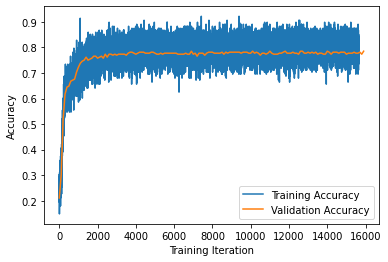

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()